# KERAS PREDICT

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import csv

plt.rcParams['figure.figsize'] = [18, 9]

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos if x.device_type == 'GPU'])

Num GPUs Available:  1
/device:GPU:0
['/device:GPU:0']


In [3]:
def beautifulPlotSetting():
    plt.title('Графики синуса и косинуса', fontsize=18)  # Заголовок графика
    plt.xlabel('X', fontsize=14)  # Подпись оси X
    plt.ylabel('Y', fontsize=14)  # Подпись оси Y
    plt.xticks(fontsize=12)  # Размер шрифта меток по оси X
    plt.yticks(fontsize=12)  # Размер шрифта меток по оси Y
    plt.grid(True)  # Включаем сетку
    plt.legend(fontsize=14)  # Добавляем легенду с крупным шрифтом
    
    
def beautifulPlot(xArray, yArray):
    beautifulPlotSetting()
    plt.plot(xArray, yArray)

def beautifulPlot(yArray):
    beautifulPlotSetting()
    plt.plot(yArray)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Функци для генерации ошибок в процессе работы
def createRiseErrorFile(sourceFilename, newFilename):
    
    data = pd.read_csv(sourceFilename)
    data = data['y'].values.reshape(-1, 1).astype("float32")
    
    # Генерируем исходные данные
    N = 20 * 2500  # Размер массива

    # Генерируем новые значения температуры от 41 до 90 с использованием кубической интерполяции
    new_temperatures = np.linspace(data[160000], 130, num=N)
    t = np.linspace(0, 1, N)
    cs = CubicSpline([0, 1], [data[160000], 130], bc_type='clamped')
    new_temperatures = cs(t)

#     random_deviation = np.random.uniform(-0.1, 0.1, size=N)
#     new_temperatures = new_temperatures + random_deviation

    # Объединяем исходные данные с новыми данными
    combined_data = np.concatenate((data[:160000], new_temperatures[:, np.newaxis]))

    # Построение графика
    plt.plot(combined_data)
    plt.xlabel('Время')
    plt.ylabel('Температура')
    plt.title('Изменение температуры с заданной функцией')
    plt.show()
    
    # Записываем данные в CSV файл
    with open(newFilename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['unique_id', 'ds', 'y'])
        i = 0
        for el in combined_data:
            writer.writerow([i+1, i/20, el[0]])
            i += 1
            
            
def createDropErrorFile(sourceFilename, newFilename):
    
    data = pd.read_csv(sourceFilename)
    data = data['y'].values.reshape(-1, 1).astype("float32")
    
    # Генерируем исходные данные
    N = 20 * 2100  # Размер массив

    # Генерируем новые значения температуры от data[40000] до 31 с использованием кубической интерполяции
    new_temperatures = np.linspace(data[140000], 25, num=N)
    t = np.linspace(0, 1, N)
    cs = CubicSpline([0, 1], [data[140000], 25], bc_type='clamped')
    new_temperatures = cs(t)

#     random_deviation = np.random.uniform(-0.1, 0.1, size=N)
#     new_temperatures = new_temperatures + random_deviation

    # Объединяем исходные данные с новыми данными
    combined_data = np.concatenate((data[:140000], new_temperatures[:, np.newaxis]))

    # Построение графика
    plt.plot(combined_data)
    plt.xlabel('Время')
    plt.ylabel('Температура')
    plt.title('Изменение температуры с заданной функцией')
    plt.show()
    
    # Записываем данные в CSV файл
    with open(newFilename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['unique_id', 'ds', 'y'])
        i = 0
        for el in combined_data:
            writer.writerow([i+1, i/20, el[0]])
            i += 1

In [55]:
# Функция для преобразования данных в формат, пригодный для обучения LSTM
def create_dataset(dataset, time_steps=1, output_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps - output_step):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        b = dataset[(i + time_steps):(i + time_steps + output_step), 0]
        y.append(b)
    return np.array(X), np.array(y)


In [56]:
def normalizeWithWeights(data, center_min, center_max, min_value, max_value):
    print(max_value, center_max, center_min, min_value)
    
    data = [el for el in data]
    data = data - min_value
    center_min -= min_value
    center_max -= min_value
    max_value -= min_value
    min_value = 0
    
    weighs = [0.04, 0.04]
    
    for i in range(len(data)):
#         print(data[i], data[i] > center_min, data[i] < center_max)
        if (data[i] > center_min and data[i] < center_max):
            data[i] = (data[i] - center_min) / (center_max - center_min) * (1 - weighs[0] - weighs[1]) + weighs[0]            
        elif (not data[i] > center_min):
            data[i] = (data[i]) / center_min * weighs[0]
        else:
            data[i] = (data[i]) / (max_value) * weighs[1] + (1 - weighs[1])
    print(np.max(data))
    return data

In [7]:
# Функция читает все файлы и нормирует из в [0, 1]
def getAllData(trainFilenameList, testFilename, time_steps=1, output_step=1):
    rawData = []
    center_min = None
    center_max = None
    for el in trainFilenameList:
        data = pd.read_csv(el)
        data = data['y'].values.reshape(-1, 1).astype("float32")[::200]#[10000:]        
        rawData.append(data)
        
        if (center_min is None):
            center_min = np.min(data)
            center_max = np.max(data)
        
    data = pd.read_csv(testFilename)
    data = data['y'].values.reshape(-1, 1).astype("float32")[::200]#[10000:]\
    rawData.append(data)
    
    if (center_min is None):
        center_min = np.min(data)
        center_max = np.max(data)
    
    
    
    min_value = np.min([arr.min() for arr in rawData])
    max_value = np.max([arr.max() for arr in rawData])
    
    print(min_value, max_value)

    # Нормализуем каждый массив в диапазоне [0, 1]
    
    normalized_arrays = [(arr - min_value) / (max_value - min_value) for arr in rawData]
    
#     normalized_arrays = [normalizeWithWeights(arr, center_min, center_max, min_value, max_value) for arr in rawData]
    
    old_x = 0
    for arr in normalized_arrays:
        plt.plot([x for x in range(old_x, old_x + len(arr))], arr, color='b' if not arr is normalized_arrays[-1] else 'r')
        old_x += len(arr)
    
#     old_x = 0
#     for arr in normalized_arrays:        
#         plt.plot([x for x in range(old_x, old_x + len(arr))], arr, color='green')
#         old_x += len(arr)
    
    trainDataX = None
    trainDataY = None
    for array in normalized_arrays[:-1]:
        if (trainDataX is None):
            trainDataX, trainDataY = create_dataset(array, time_steps, output_step)
        else:
            X, Y = create_dataset(array, time_steps, output_step)
            trainDataX = np.concatenate((trainDataX, X), axis=0)
            trainDataY = np.concatenate((trainDataY, Y), axis=0)
    
    testDataX, testDataY = create_dataset(normalized_arrays[-1], time_steps, output_step)
    
    testRawData = normalized_arrays[-1]
    
    return trainDataX, trainDataY, testDataX, testDataY, testRawData

25.02262 44.754017


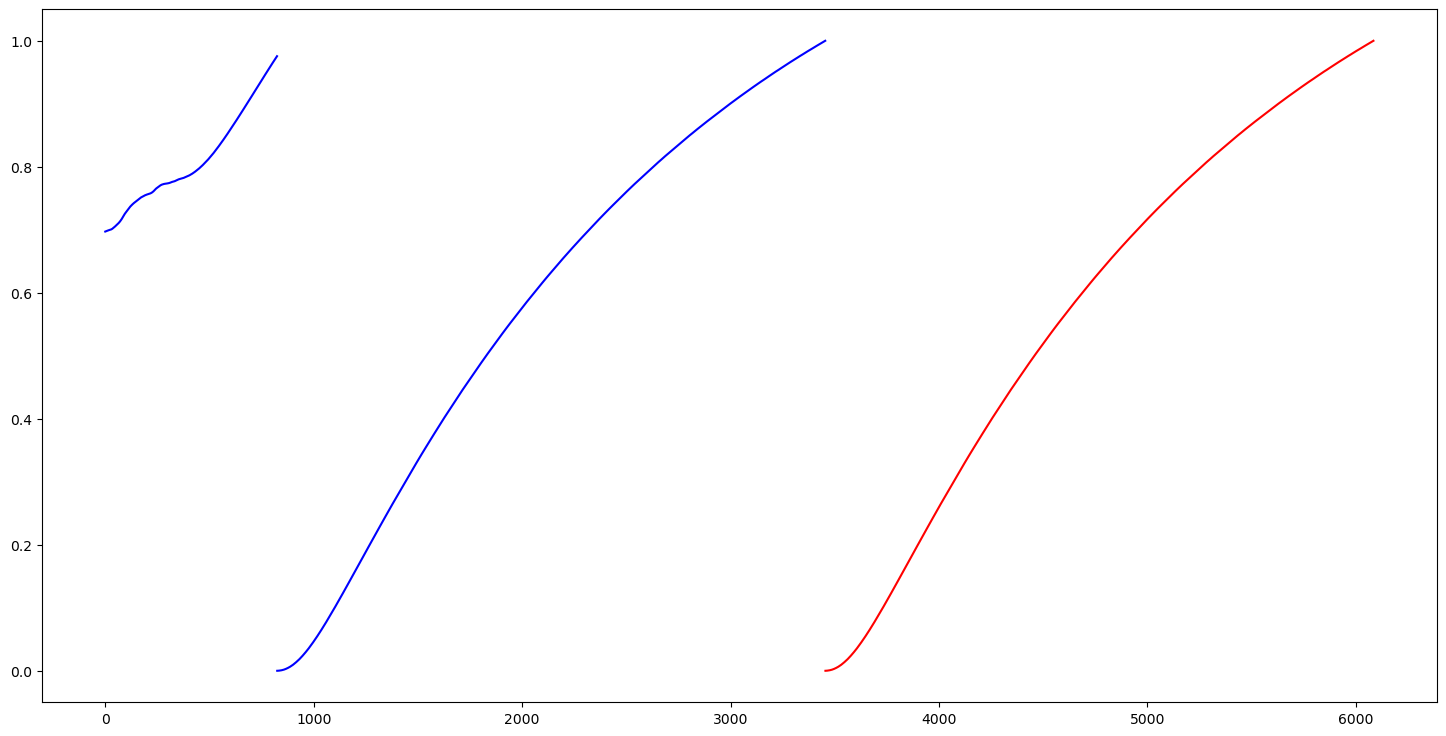

In [65]:
# Задаем количество временных шагов
time_steps = 70
out_steps = 18

# Файлы для обучающей выборки
# trainFiles = ['./Temperature/temp2_norm.csv', './Temperature/temp15_modelOtkazTempDrop.csv', './Temperature/temp14_modelOtkazTempRise.csv']#,
#               './Temperature/temp11_otkaz.csv']

trainFiles = ['./Temperature/temp6_otkaz.csv', './Temperature/temp11_otkaz.csv']#,
# trainFiles = ['./Temperature/temp1_norm.csv', './Temperature/temp3_norm.csv']

# Тестовый файл
testFile = './Temperature/temp11_otkaz.csv'

# Подготовка обучающих и тестовых данных
train_X, train_y, test_X, test_y, normalRawData = getAllData(trainFiles, testFile, time_steps, out_steps)

# # Тестовые данные с возрастающей ошибкой
# _, _, RiseTest_X, RiseTest_y, RiseTestRawData = getAllData(trainFiles + [testFile], './Temperature/temp16_modelOtkazTempRise.csv'
#                                                            , time_steps, out_steps)

# # Тестовые данные с падающей ошибкой
# _, _, DropTest_X, DropTest_y, DropTestRawData = getAllData(trainFiles + [testFile], './Temperature/temp17_modelOtkazTempDrop.csv'
#                                                            , time_steps, out_steps)

25.001068 129.99577
25.001068 129.99577
25.001064 129.99577


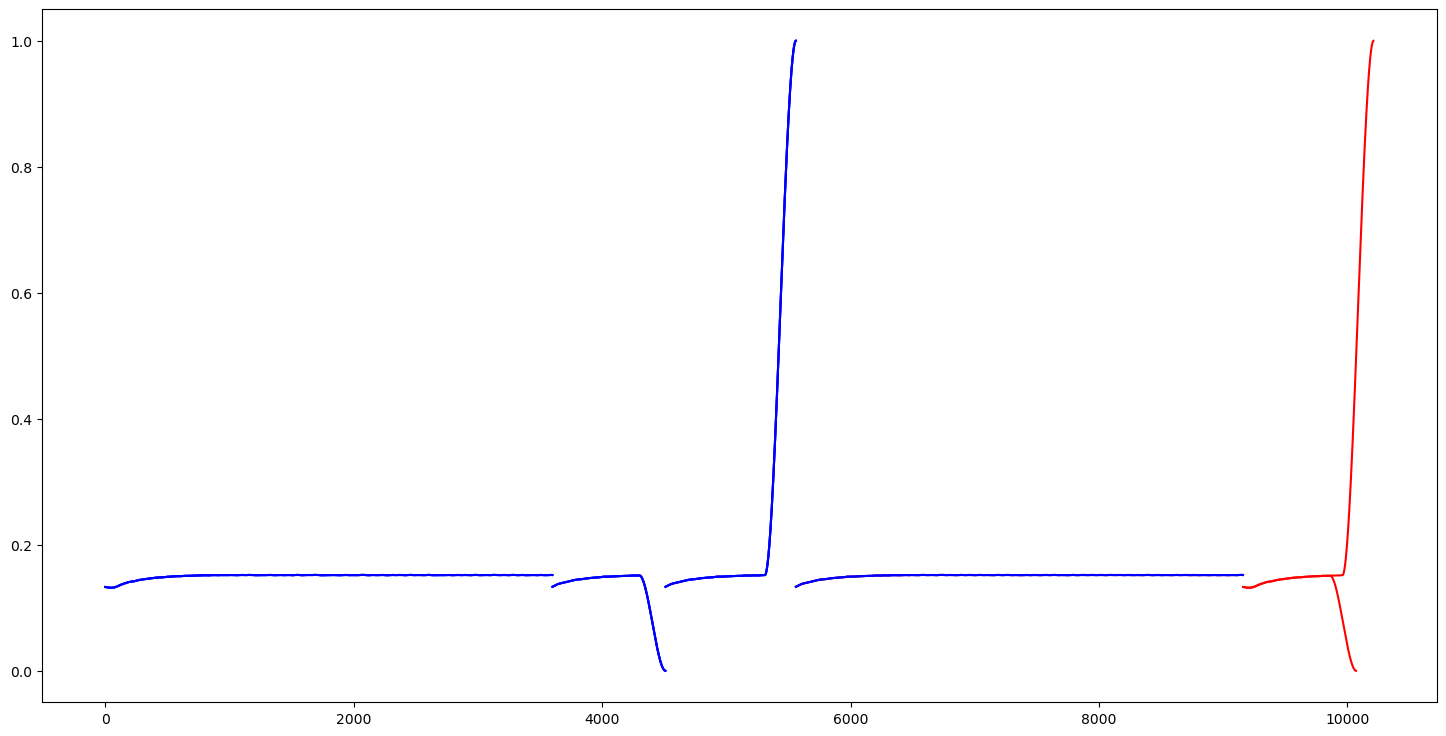

In [9]:
time_steps = 70
out_steps = 18

# Файлы для обучающей выборки
trainFiles = ['./Temperature/temp2_norm.csv', './Temperature/temp15_modelOtkazTempDrop.csv', './Temperature/temp14_modelOtkazTempRise.csv']#,
#               './Temperature/temp11_otkaz.csv']

# trainFiles = ['./Temperature/temp1_norm.csv', './Temperature/temp3_norm.csv']

# Тестовый файл
testFile = './Temperature/temp1_norm.csv'

# Подготовка обучающих и тестовых данных
train_X, train_y, test_X, test_y, normalRawData = getAllData(trainFiles, testFile, time_steps, out_steps)

# Тестовые данные с возрастающей ошибкой
_, _, RiseTest_X, RiseTest_y, RiseTestRawData = getAllData(trainFiles + [testFile], './Temperature/temp16_modelOtkazTempRise.csv'
                                                           , time_steps, out_steps)

# Тестовые данные с падающей ошибкой
_, _, DropTest_X, DropTest_y, DropTestRawData = getAllData(trainFiles + [testFile], './Temperature/temp17_modelOtkazTempDrop.csv'
                                                           , time_steps, out_steps)

maxTest_X = np.concatenate((test_X, RiseTest_X, DropTest_X), axis=0)
maxTest_y = np.concatenate((test_y, RiseTest_y, DropTest_y), axis=0)

X_maxTest = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

In [61]:
print(train_X.shape, train_y.shape)

(3279, 70) (3279, 18)


In [66]:
# Преобразование данных в формат, подходящий для ввода в LSTM
X_train = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
X_test = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
X_dropTest = np.reshape(DropTest_X, (DropTest_X.shape[0], DropTest_X.shape[1], 1))
X_riseTest = np.reshape(RiseTest_X, (RiseTest_X.shape[0], RiseTest_X.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(3279, 70, 1)
(2542, 70, 1)


In [63]:
model = Sequential()
model.add(LSTM(100, input_shape=(time_steps, 1)))
model.add(Dropout(0.2))
model.add(Dense(out_steps))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mean_squared_error', 'mean_absolute_error'])

In [149]:
# Model 2

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
model.add(MaxPooling1D(pool_size = 2))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(out_steps))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mean_squared_error', 'mean_absolute_error'])

In [64]:
# Обучение модели
history = model.fit(X_train, train_y, epochs=1000, batch_size=32, verbose=1, validation_data=(X_test, test_y))


Epoch 1/1000
103/103 [==============================] - 2s 13ms/step - loss: 0.0447 - accuracy: 0.0412 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1324 - val_loss: 1.4379e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.4379e-04 - val_mean_absolute_error: 0.0095
Epoch 2/1000
103/103 [==============================] - 1s 7ms/step - loss: 0.0070 - accuracy: 0.0540 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0620 - val_loss: 8.0362e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.0362e-04 - val_mean_absolute_error: 0.0258
Epoch 3/1000
103/103 [==============================] - 1s 8ms/step - loss: 0.0051 - accuracy: 0.0537 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0524 - val_loss: 2.4319e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4319e-04 - val_mean_absolute_error: 0.0145
Epoch 4/1000
103/103 [==============================] - 1s 8ms/step - loss: 0.0040 - accuracy: 0.0506 - mean_squared_error: 0.0040 - mean_absolute_error:

Epoch 30/1000
103/103 [==============================] - 1s 7ms/step - loss: 7.1849e-04 - accuracy: 0.1070 - mean_squared_error: 7.1849e-04 - mean_absolute_error: 0.0193 - val_loss: 3.6777e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.6777e-05 - val_mean_absolute_error: 0.0056
Epoch 31/1000
103/103 [==============================] - 1s 7ms/step - loss: 6.7136e-04 - accuracy: 0.1016 - mean_squared_error: 6.7136e-04 - mean_absolute_error: 0.0187 - val_loss: 2.7979e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7979e-04 - val_mean_absolute_error: 0.0165
Epoch 32/1000
103/103 [==============================] - 1s 7ms/step - loss: 7.2372e-04 - accuracy: 0.1055 - mean_squared_error: 7.2372e-04 - mean_absolute_error: 0.0193 - val_loss: 6.6501e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 6.6501e-06 - val_mean_absolute_error: 0.0020
Epoch 33/1000
103/103 [==============================] - 1s 7ms/step - loss: 6.7696e-04 - accuracy: 0.1034 - mean_squared_error: 6.

103/103 [==============================] - 1s 7ms/step - loss: 2.9321e-04 - accuracy: 0.1793 - mean_squared_error: 2.9321e-04 - mean_absolute_error: 0.0126 - val_loss: 3.7333e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.7333e-05 - val_mean_absolute_error: 0.0059
Epoch 59/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.8624e-04 - accuracy: 0.1510 - mean_squared_error: 2.8624e-04 - mean_absolute_error: 0.0125 - val_loss: 3.0547e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.0547e-05 - val_mean_absolute_error: 0.0054
Epoch 60/1000
103/103 [==============================] - 1s 8ms/step - loss: 2.7211e-04 - accuracy: 0.1641 - mean_squared_error: 2.7211e-04 - mean_absolute_error: 0.0122 - val_loss: 9.4175e-05 - val_accuracy: 0.8406 - val_mean_squared_error: 9.4175e-05 - val_mean_absolute_error: 0.0094
Epoch 61/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.7530e-04 - accuracy: 0.1494 - mean_squared_error: 2.7530e-04 - mean_ab

103/103 [==============================] - 1s 7ms/step - loss: 2.0098e-04 - accuracy: 0.3690 - mean_squared_error: 2.0098e-04 - mean_absolute_error: 0.0102 - val_loss: 3.8820e-05 - val_accuracy: 0.9757 - val_mean_squared_error: 3.8820e-05 - val_mean_absolute_error: 0.0056
Epoch 87/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.2094e-04 - accuracy: 0.4132 - mean_squared_error: 2.2094e-04 - mean_absolute_error: 0.0107 - val_loss: 1.1226e-04 - val_accuracy: 0.4142 - val_mean_squared_error: 1.1226e-04 - val_mean_absolute_error: 0.0103
Epoch 88/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.1926e-04 - accuracy: 0.4056 - mean_squared_error: 2.1926e-04 - mean_absolute_error: 0.0106 - val_loss: 4.6165e-06 - val_accuracy: 0.5494 - val_mean_squared_error: 4.6165e-06 - val_mean_absolute_error: 0.0019
Epoch 89/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.1366e-04 - accuracy: 0.4251 - mean_squared_error: 2.1366e-04 - mean_absolu

103/103 [==============================] - 1s 8ms/step - loss: 2.0765e-04 - accuracy: 0.9591 - mean_squared_error: 2.0765e-04 - mean_absolute_error: 0.0103 - val_loss: 2.8936e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.8936e-05 - val_mean_absolute_error: 0.0053
Epoch 115/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.0461e-04 - accuracy: 0.9756 - mean_squared_error: 2.0461e-04 - mean_absolute_error: 0.0100 - val_loss: 4.6493e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.6493e-05 - val_mean_absolute_error: 0.0067
Epoch 116/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.3261e-04 - accuracy: 0.9707 - mean_squared_error: 2.3261e-04 - mean_absolute_error: 0.0107 - val_loss: 3.5883e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5883e-05 - val_mean_absolute_error: 0.0052
Epoch 117/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.1625e-04 - accuracy: 0.9729 - mean_squared_error: 2.1625e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 2.1966e-04 - accuracy: 1.0000 - mean_squared_error: 2.1966e-04 - mean_absolute_error: 0.0103 - val_loss: 1.6245e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.6245e-05 - val_mean_absolute_error: 0.0037
Epoch 143/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.1971e-04 - accuracy: 1.0000 - mean_squared_error: 2.1971e-04 - mean_absolute_error: 0.0104 - val_loss: 5.9760e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.9760e-05 - val_mean_absolute_error: 0.0073
Epoch 144/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9455e-04 - accuracy: 1.0000 - mean_squared_error: 1.9455e-04 - mean_absolute_error: 0.0101 - val_loss: 2.2281e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2281e-05 - val_mean_absolute_error: 0.0044
Epoch 145/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9786e-04 - accuracy: 1.0000 - mean_squared_error: 1.9786e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.9484e-04 - accuracy: 1.0000 - mean_squared_error: 1.9484e-04 - mean_absolute_error: 0.0099 - val_loss: 5.9882e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.9882e-06 - val_mean_absolute_error: 0.0021
Epoch 171/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.0230e-04 - accuracy: 1.0000 - mean_squared_error: 2.0230e-04 - mean_absolute_error: 0.0101 - val_loss: 3.2682e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.2682e-06 - val_mean_absolute_error: 0.0015
Epoch 172/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.0171e-04 - accuracy: 1.0000 - mean_squared_error: 2.0171e-04 - mean_absolute_error: 0.0101 - val_loss: 1.4766e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4766e-05 - val_mean_absolute_error: 0.0036
Epoch 173/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.1442e-04 - accuracy: 1.0000 - mean_squared_error: 2.1442e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 2.1654e-04 - accuracy: 1.0000 - mean_squared_error: 2.1654e-04 - mean_absolute_error: 0.0103 - val_loss: 7.6553e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.6553e-06 - val_mean_absolute_error: 0.0025
Epoch 199/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9782e-04 - accuracy: 1.0000 - mean_squared_error: 1.9782e-04 - mean_absolute_error: 0.0101 - val_loss: 2.4529e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.4529e-05 - val_mean_absolute_error: 0.0047
Epoch 200/1000
103/103 [==============================] - 1s 8ms/step - loss: 1.8460e-04 - accuracy: 1.0000 - mean_squared_error: 1.8460e-04 - mean_absolute_error: 0.0095 - val_loss: 3.1470e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.1470e-05 - val_mean_absolute_error: 0.0054
Epoch 201/1000
103/103 [==============================] - 1s 8ms/step - loss: 1.9300e-04 - accuracy: 1.0000 - mean_squared_error: 1.9300e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 2.0156e-04 - accuracy: 1.0000 - mean_squared_error: 2.0156e-04 - mean_absolute_error: 0.0098 - val_loss: 5.6566e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.6566e-05 - val_mean_absolute_error: 0.0071
Epoch 227/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.0526e-04 - accuracy: 1.0000 - mean_squared_error: 2.0526e-04 - mean_absolute_error: 0.0098 - val_loss: 3.0131e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.0131e-06 - val_mean_absolute_error: 0.0013
Epoch 228/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9510e-04 - accuracy: 1.0000 - mean_squared_error: 1.9510e-04 - mean_absolute_error: 0.0098 - val_loss: 2.5018e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.5018e-06 - val_mean_absolute_error: 0.0013
Epoch 229/1000
103/103 [==============================] - 1s 8ms/step - loss: 1.9397e-04 - accuracy: 1.0000 - mean_squared_error: 1.9397e-04 - mean_abs

103/103 [==============================] - 1s 6ms/step - loss: 1.8406e-04 - accuracy: 1.0000 - mean_squared_error: 1.8406e-04 - mean_absolute_error: 0.0094 - val_loss: 4.8016e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.8016e-06 - val_mean_absolute_error: 0.0019
Epoch 255/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9991e-04 - accuracy: 1.0000 - mean_squared_error: 1.9991e-04 - mean_absolute_error: 0.0099 - val_loss: 1.2379e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2379e-06 - val_mean_absolute_error: 8.8612e-04
Epoch 256/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9773e-04 - accuracy: 1.0000 - mean_squared_error: 1.9773e-04 - mean_absolute_error: 0.0098 - val_loss: 3.9938e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.9938e-06 - val_mean_absolute_error: 0.0017
Epoch 257/1000
103/103 [==============================] - 1s 6ms/step - loss: 1.9327e-04 - accuracy: 1.0000 - mean_squared_error: 1.9327e-04 - mean

103/103 [==============================] - 1s 6ms/step - loss: 2.0029e-04 - accuracy: 1.0000 - mean_squared_error: 2.0029e-04 - mean_absolute_error: 0.0099 - val_loss: 6.9845e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 6.9845e-06 - val_mean_absolute_error: 0.0023
Epoch 283/1000
103/103 [==============================] - 1s 6ms/step - loss: 1.9145e-04 - accuracy: 1.0000 - mean_squared_error: 1.9145e-04 - mean_absolute_error: 0.0097 - val_loss: 1.1738e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1738e-06 - val_mean_absolute_error: 9.0127e-04
Epoch 284/1000
103/103 [==============================] - 1s 6ms/step - loss: 1.9042e-04 - accuracy: 1.0000 - mean_squared_error: 1.9042e-04 - mean_absolute_error: 0.0095 - val_loss: 1.5364e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5364e-05 - val_mean_absolute_error: 0.0038
Epoch 285/1000
103/103 [==============================] - 1s 6ms/step - loss: 1.8484e-04 - accuracy: 1.0000 - mean_squared_error: 1.8484e-04 - mean

103/103 [==============================] - 1s 7ms/step - loss: 2.0060e-04 - accuracy: 1.0000 - mean_squared_error: 2.0060e-04 - mean_absolute_error: 0.0097 - val_loss: 8.3896e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 8.3896e-06 - val_mean_absolute_error: 0.0027
Epoch 311/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9721e-04 - accuracy: 1.0000 - mean_squared_error: 1.9721e-04 - mean_absolute_error: 0.0098 - val_loss: 1.4808e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4808e-05 - val_mean_absolute_error: 0.0034
Epoch 312/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9885e-04 - accuracy: 1.0000 - mean_squared_error: 1.9885e-04 - mean_absolute_error: 0.0098 - val_loss: 4.7618e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.7618e-05 - val_mean_absolute_error: 0.0067
Epoch 313/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9807e-04 - accuracy: 1.0000 - mean_squared_error: 1.9807e-04 - mean_abs

103/103 [==============================] - 1s 8ms/step - loss: 1.9935e-04 - accuracy: 1.0000 - mean_squared_error: 1.9935e-04 - mean_absolute_error: 0.0098 - val_loss: 3.5432e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5432e-06 - val_mean_absolute_error: 0.0016
Epoch 339/1000
103/103 [==============================] - 1s 8ms/step - loss: 1.9656e-04 - accuracy: 1.0000 - mean_squared_error: 1.9656e-04 - mean_absolute_error: 0.0097 - val_loss: 3.2590e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.2590e-05 - val_mean_absolute_error: 0.0050
Epoch 340/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8505e-04 - accuracy: 1.0000 - mean_squared_error: 1.8505e-04 - mean_absolute_error: 0.0096 - val_loss: 4.9617e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.9617e-05 - val_mean_absolute_error: 0.0069
Epoch 341/1000
103/103 [==============================] - 1s 6ms/step - loss: 1.9082e-04 - accuracy: 1.0000 - mean_squared_error: 1.9082e-04 - mean_abs

103/103 [==============================] - 1s 8ms/step - loss: 1.8123e-04 - accuracy: 1.0000 - mean_squared_error: 1.8123e-04 - mean_absolute_error: 0.0093 - val_loss: 3.2119e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.2119e-05 - val_mean_absolute_error: 0.0054
Epoch 367/1000
103/103 [==============================] - 1s 8ms/step - loss: 1.8383e-04 - accuracy: 1.0000 - mean_squared_error: 1.8383e-04 - mean_absolute_error: 0.0094 - val_loss: 4.6359e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.6359e-06 - val_mean_absolute_error: 0.0018
Epoch 368/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9268e-04 - accuracy: 1.0000 - mean_squared_error: 1.9268e-04 - mean_absolute_error: 0.0096 - val_loss: 1.8334e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.8334e-06 - val_mean_absolute_error: 0.0011
Epoch 369/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9451e-04 - accuracy: 1.0000 - mean_squared_error: 1.9451e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.9100e-04 - accuracy: 1.0000 - mean_squared_error: 1.9100e-04 - mean_absolute_error: 0.0096 - val_loss: 1.8879e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.8879e-05 - val_mean_absolute_error: 0.0043
Epoch 395/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9125e-04 - accuracy: 1.0000 - mean_squared_error: 1.9125e-04 - mean_absolute_error: 0.0094 - val_loss: 2.6302e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.6302e-06 - val_mean_absolute_error: 0.0014
Epoch 396/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9930e-04 - accuracy: 1.0000 - mean_squared_error: 1.9930e-04 - mean_absolute_error: 0.0097 - val_loss: 1.3968e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.3968e-06 - val_mean_absolute_error: 9.9088e-04
Epoch 397/1000
103/103 [==============================] - 1s 7ms/step - loss: 2.1275e-04 - accuracy: 1.0000 - mean_squared_error: 2.1275e-04 - mean

103/103 [==============================] - 1s 7ms/step - loss: 1.7641e-04 - accuracy: 1.0000 - mean_squared_error: 1.7641e-04 - mean_absolute_error: 0.0093 - val_loss: 1.2227e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2227e-05 - val_mean_absolute_error: 0.0029
Epoch 423/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9558e-04 - accuracy: 1.0000 - mean_squared_error: 1.9558e-04 - mean_absolute_error: 0.0096 - val_loss: 1.1824e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1824e-05 - val_mean_absolute_error: 0.0029
Epoch 424/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9342e-04 - accuracy: 1.0000 - mean_squared_error: 1.9342e-04 - mean_absolute_error: 0.0097 - val_loss: 1.2555e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2555e-05 - val_mean_absolute_error: 0.0034
Epoch 425/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9736e-04 - accuracy: 1.0000 - mean_squared_error: 1.9736e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.7832e-04 - accuracy: 1.0000 - mean_squared_error: 1.7832e-04 - mean_absolute_error: 0.0093 - val_loss: 5.8960e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.8960e-06 - val_mean_absolute_error: 0.0022
Epoch 451/1000
103/103 [==============================] - 1s 8ms/step - loss: 1.8200e-04 - accuracy: 1.0000 - mean_squared_error: 1.8200e-04 - mean_absolute_error: 0.0094 - val_loss: 2.0395e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.0395e-05 - val_mean_absolute_error: 0.0042
Epoch 452/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8071e-04 - accuracy: 1.0000 - mean_squared_error: 1.8071e-04 - mean_absolute_error: 0.0094 - val_loss: 1.2644e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2644e-06 - val_mean_absolute_error: 8.8637e-04
Epoch 453/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8660e-04 - accuracy: 1.0000 - mean_squared_error: 1.8660e-04 - mean

103/103 [==============================] - 1s 7ms/step - loss: 1.9993e-04 - accuracy: 1.0000 - mean_squared_error: 1.9993e-04 - mean_absolute_error: 0.0098 - val_loss: 8.4092e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 8.4092e-06 - val_mean_absolute_error: 0.0027
Epoch 479/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9495e-04 - accuracy: 1.0000 - mean_squared_error: 1.9495e-04 - mean_absolute_error: 0.0095 - val_loss: 2.2324e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2324e-05 - val_mean_absolute_error: 0.0046
Epoch 480/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8274e-04 - accuracy: 1.0000 - mean_squared_error: 1.8274e-04 - mean_absolute_error: 0.0093 - val_loss: 4.4410e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.4410e-05 - val_mean_absolute_error: 0.0065
Epoch 481/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9311e-04 - accuracy: 1.0000 - mean_squared_error: 1.9311e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.9335e-04 - accuracy: 1.0000 - mean_squared_error: 1.9335e-04 - mean_absolute_error: 0.0095 - val_loss: 3.6300e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6300e-06 - val_mean_absolute_error: 0.0016
Epoch 507/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7927e-04 - accuracy: 1.0000 - mean_squared_error: 1.7927e-04 - mean_absolute_error: 0.0093 - val_loss: 3.6848e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6848e-05 - val_mean_absolute_error: 0.0059
Epoch 508/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8657e-04 - accuracy: 1.0000 - mean_squared_error: 1.8657e-04 - mean_absolute_error: 0.0097 - val_loss: 2.6034e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.6034e-05 - val_mean_absolute_error: 0.0042
Epoch 509/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7672e-04 - accuracy: 1.0000 - mean_squared_error: 1.7672e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.7372e-04 - accuracy: 1.0000 - mean_squared_error: 1.7372e-04 - mean_absolute_error: 0.0093 - val_loss: 7.2285e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.2285e-06 - val_mean_absolute_error: 0.0023
Epoch 535/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9395e-04 - accuracy: 1.0000 - mean_squared_error: 1.9395e-04 - mean_absolute_error: 0.0096 - val_loss: 7.8226e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.8226e-06 - val_mean_absolute_error: 0.0025
Epoch 536/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8791e-04 - accuracy: 1.0000 - mean_squared_error: 1.8791e-04 - mean_absolute_error: 0.0094 - val_loss: 9.3654e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 9.3654e-06 - val_mean_absolute_error: 0.0026
Epoch 537/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9403e-04 - accuracy: 1.0000 - mean_squared_error: 1.9403e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.8563e-04 - accuracy: 1.0000 - mean_squared_error: 1.8563e-04 - mean_absolute_error: 0.0094 - val_loss: 1.5569e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5569e-05 - val_mean_absolute_error: 0.0036
Epoch 563/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8275e-04 - accuracy: 1.0000 - mean_squared_error: 1.8275e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1953e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1953e-05 - val_mean_absolute_error: 0.0033
Epoch 564/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8180e-04 - accuracy: 1.0000 - mean_squared_error: 1.8180e-04 - mean_absolute_error: 0.0093 - val_loss: 4.0025e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.0025e-06 - val_mean_absolute_error: 0.0016
Epoch 565/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9697e-04 - accuracy: 1.0000 - mean_squared_error: 1.9697e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.8587e-04 - accuracy: 1.0000 - mean_squared_error: 1.8587e-04 - mean_absolute_error: 0.0095 - val_loss: 1.1309e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1309e-06 - val_mean_absolute_error: 8.8319e-04
Epoch 591/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9456e-04 - accuracy: 1.0000 - mean_squared_error: 1.9456e-04 - mean_absolute_error: 0.0096 - val_loss: 2.6826e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.6826e-05 - val_mean_absolute_error: 0.0049
Epoch 592/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9342e-04 - accuracy: 1.0000 - mean_squared_error: 1.9342e-04 - mean_absolute_error: 0.0097 - val_loss: 1.4893e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4893e-06 - val_mean_absolute_error: 0.0010
Epoch 593/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7820e-04 - accuracy: 1.0000 - mean_squared_error: 1.7820e-04 - mean

103/103 [==============================] - 1s 7ms/step - loss: 1.8864e-04 - accuracy: 1.0000 - mean_squared_error: 1.8864e-04 - mean_absolute_error: 0.0094 - val_loss: 2.3083e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.3083e-06 - val_mean_absolute_error: 0.0013
Epoch 619/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7869e-04 - accuracy: 1.0000 - mean_squared_error: 1.7869e-04 - mean_absolute_error: 0.0092 - val_loss: 1.1309e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1309e-06 - val_mean_absolute_error: 9.0897e-04
Epoch 620/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9077e-04 - accuracy: 1.0000 - mean_squared_error: 1.9077e-04 - mean_absolute_error: 0.0093 - val_loss: 1.5172e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5172e-06 - val_mean_absolute_error: 0.0010
Epoch 621/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9114e-04 - accuracy: 1.0000 - mean_squared_error: 1.9114e-04 - mean

103/103 [==============================] - 1s 7ms/step - loss: 1.8906e-04 - accuracy: 1.0000 - mean_squared_error: 1.8906e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0305e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0305e-06 - val_mean_absolute_error: 8.5919e-04
Epoch 647/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8033e-04 - accuracy: 1.0000 - mean_squared_error: 1.8033e-04 - mean_absolute_error: 0.0093 - val_loss: 5.4723e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.4723e-06 - val_mean_absolute_error: 0.0021
Epoch 648/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8892e-04 - accuracy: 1.0000 - mean_squared_error: 1.8892e-04 - mean_absolute_error: 0.0094 - val_loss: 7.2506e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.2506e-06 - val_mean_absolute_error: 0.0024
Epoch 649/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7704e-04 - accuracy: 1.0000 - mean_squared_error: 1.7704e-04 - mean

103/103 [==============================] - 1s 8ms/step - loss: 1.7236e-04 - accuracy: 1.0000 - mean_squared_error: 1.7236e-04 - mean_absolute_error: 0.0091 - val_loss: 2.7986e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7986e-05 - val_mean_absolute_error: 0.0037
Epoch 675/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9106e-04 - accuracy: 1.0000 - mean_squared_error: 1.9106e-04 - mean_absolute_error: 0.0096 - val_loss: 6.1854e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 6.1854e-05 - val_mean_absolute_error: 0.0077
Epoch 676/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8812e-04 - accuracy: 1.0000 - mean_squared_error: 1.8812e-04 - mean_absolute_error: 0.0091 - val_loss: 3.4407e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.4407e-06 - val_mean_absolute_error: 0.0016
Epoch 677/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7258e-04 - accuracy: 1.0000 - mean_squared_error: 1.7258e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.8599e-04 - accuracy: 1.0000 - mean_squared_error: 1.8599e-04 - mean_absolute_error: 0.0093 - val_loss: 1.7090e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.7090e-05 - val_mean_absolute_error: 0.0036
Epoch 703/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9230e-04 - accuracy: 1.0000 - mean_squared_error: 1.9230e-04 - mean_absolute_error: 0.0095 - val_loss: 3.3119e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.3119e-05 - val_mean_absolute_error: 0.0057
Epoch 704/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8637e-04 - accuracy: 1.0000 - mean_squared_error: 1.8637e-04 - mean_absolute_error: 0.0094 - val_loss: 5.5456e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.5456e-06 - val_mean_absolute_error: 0.0020
Epoch 705/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7433e-04 - accuracy: 1.0000 - mean_squared_error: 1.7433e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.6817e-04 - accuracy: 1.0000 - mean_squared_error: 1.6817e-04 - mean_absolute_error: 0.0091 - val_loss: 3.9629e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.9629e-05 - val_mean_absolute_error: 0.0061
Epoch 731/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8213e-04 - accuracy: 1.0000 - mean_squared_error: 1.8213e-04 - mean_absolute_error: 0.0094 - val_loss: 2.2225e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2225e-06 - val_mean_absolute_error: 0.0012
Epoch 732/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7250e-04 - accuracy: 1.0000 - mean_squared_error: 1.7250e-04 - mean_absolute_error: 0.0089 - val_loss: 1.4038e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4038e-06 - val_mean_absolute_error: 9.9085e-04
Epoch 733/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.6384e-04 - accuracy: 1.0000 - mean_squared_error: 1.6384e-04 - mean

103/103 [==============================] - 1s 7ms/step - loss: 1.8435e-04 - accuracy: 1.0000 - mean_squared_error: 1.8435e-04 - mean_absolute_error: 0.0094 - val_loss: 9.8791e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 9.8791e-06 - val_mean_absolute_error: 0.0028
Epoch 759/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9704e-04 - accuracy: 1.0000 - mean_squared_error: 1.9704e-04 - mean_absolute_error: 0.0097 - val_loss: 2.6010e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.6010e-05 - val_mean_absolute_error: 0.0044
Epoch 760/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8554e-04 - accuracy: 1.0000 - mean_squared_error: 1.8554e-04 - mean_absolute_error: 0.0094 - val_loss: 3.7730e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.7730e-05 - val_mean_absolute_error: 0.0058
Epoch 761/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8509e-04 - accuracy: 1.0000 - mean_squared_error: 1.8509e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.7921e-04 - accuracy: 1.0000 - mean_squared_error: 1.7921e-04 - mean_absolute_error: 0.0091 - val_loss: 1.8197e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.8197e-06 - val_mean_absolute_error: 0.0011
Epoch 787/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8106e-04 - accuracy: 1.0000 - mean_squared_error: 1.8106e-04 - mean_absolute_error: 0.0093 - val_loss: 1.4380e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4380e-05 - val_mean_absolute_error: 0.0036
Epoch 788/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7843e-04 - accuracy: 1.0000 - mean_squared_error: 1.7843e-04 - mean_absolute_error: 0.0093 - val_loss: 4.9361e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.9361e-05 - val_mean_absolute_error: 0.0069
Epoch 789/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8168e-04 - accuracy: 1.0000 - mean_squared_error: 1.8168e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.8018e-04 - accuracy: 1.0000 - mean_squared_error: 1.8018e-04 - mean_absolute_error: 0.0091 - val_loss: 3.5188e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5188e-06 - val_mean_absolute_error: 0.0014
Epoch 815/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8267e-04 - accuracy: 1.0000 - mean_squared_error: 1.8267e-04 - mean_absolute_error: 0.0093 - val_loss: 2.5111e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.5111e-05 - val_mean_absolute_error: 0.0045
Epoch 816/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8065e-04 - accuracy: 1.0000 - mean_squared_error: 1.8065e-04 - mean_absolute_error: 0.0093 - val_loss: 5.4459e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.4459e-05 - val_mean_absolute_error: 0.0071
Epoch 817/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8056e-04 - accuracy: 1.0000 - mean_squared_error: 1.8056e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.9325e-04 - accuracy: 1.0000 - mean_squared_error: 1.9325e-04 - mean_absolute_error: 0.0097 - val_loss: 2.3953e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.3953e-06 - val_mean_absolute_error: 0.0013
Epoch 843/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.6911e-04 - accuracy: 1.0000 - mean_squared_error: 1.6911e-04 - mean_absolute_error: 0.0091 - val_loss: 9.2796e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 9.2796e-06 - val_mean_absolute_error: 0.0027
Epoch 844/1000
103/103 [==============================] - 1s 6ms/step - loss: 1.8721e-04 - accuracy: 1.0000 - mean_squared_error: 1.8721e-04 - mean_absolute_error: 0.0093 - val_loss: 3.2388e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.2388e-05 - val_mean_absolute_error: 0.0056
Epoch 845/1000
103/103 [==============================] - 1s 6ms/step - loss: 1.8008e-04 - accuracy: 1.0000 - mean_squared_error: 1.8008e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 2.0665e-04 - accuracy: 1.0000 - mean_squared_error: 2.0665e-04 - mean_absolute_error: 0.0101 - val_loss: 3.9995e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.9995e-05 - val_mean_absolute_error: 0.0062
Epoch 871/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7388e-04 - accuracy: 1.0000 - mean_squared_error: 1.7388e-04 - mean_absolute_error: 0.0092 - val_loss: 2.5687e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.5687e-05 - val_mean_absolute_error: 0.0048
Epoch 872/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8249e-04 - accuracy: 1.0000 - mean_squared_error: 1.8249e-04 - mean_absolute_error: 0.0092 - val_loss: 2.7597e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7597e-06 - val_mean_absolute_error: 0.0014
Epoch 873/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7432e-04 - accuracy: 1.0000 - mean_squared_error: 1.7432e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.8727e-04 - accuracy: 1.0000 - mean_squared_error: 1.8727e-04 - mean_absolute_error: 0.0093 - val_loss: 2.3359e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.3359e-06 - val_mean_absolute_error: 0.0012
Epoch 899/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8602e-04 - accuracy: 1.0000 - mean_squared_error: 1.8602e-04 - mean_absolute_error: 0.0093 - val_loss: 2.3484e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.3484e-05 - val_mean_absolute_error: 0.0045
Epoch 900/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8718e-04 - accuracy: 1.0000 - mean_squared_error: 1.8718e-04 - mean_absolute_error: 0.0092 - val_loss: 5.5769e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.5769e-06 - val_mean_absolute_error: 0.0018
Epoch 901/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7422e-04 - accuracy: 1.0000 - mean_squared_error: 1.7422e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.8868e-04 - accuracy: 1.0000 - mean_squared_error: 1.8868e-04 - mean_absolute_error: 0.0095 - val_loss: 1.2347e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2347e-06 - val_mean_absolute_error: 8.6177e-04
Epoch 927/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.9169e-04 - accuracy: 1.0000 - mean_squared_error: 1.9169e-04 - mean_absolute_error: 0.0095 - val_loss: 2.0999e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.0999e-05 - val_mean_absolute_error: 0.0039
Epoch 928/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8050e-04 - accuracy: 1.0000 - mean_squared_error: 1.8050e-04 - mean_absolute_error: 0.0093 - val_loss: 1.9317e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.9317e-05 - val_mean_absolute_error: 0.0040
Epoch 929/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7437e-04 - accuracy: 1.0000 - mean_squared_error: 1.7437e-04 - mean

103/103 [==============================] - 1s 7ms/step - loss: 1.7641e-04 - accuracy: 1.0000 - mean_squared_error: 1.7641e-04 - mean_absolute_error: 0.0091 - val_loss: 4.4704e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.4704e-05 - val_mean_absolute_error: 0.0060
Epoch 955/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7504e-04 - accuracy: 1.0000 - mean_squared_error: 1.7504e-04 - mean_absolute_error: 0.0093 - val_loss: 2.0110e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.0110e-06 - val_mean_absolute_error: 0.0011
Epoch 956/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8009e-04 - accuracy: 1.0000 - mean_squared_error: 1.8009e-04 - mean_absolute_error: 0.0093 - val_loss: 6.5095e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 6.5095e-05 - val_mean_absolute_error: 0.0079
Epoch 957/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7554e-04 - accuracy: 1.0000 - mean_squared_error: 1.7554e-04 - mean_abs

103/103 [==============================] - 1s 7ms/step - loss: 1.8112e-04 - accuracy: 1.0000 - mean_squared_error: 1.8112e-04 - mean_absolute_error: 0.0094 - val_loss: 1.1056e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1056e-06 - val_mean_absolute_error: 8.9592e-04
Epoch 983/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.8912e-04 - accuracy: 1.0000 - mean_squared_error: 1.8912e-04 - mean_absolute_error: 0.0094 - val_loss: 1.2818e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2818e-05 - val_mean_absolute_error: 0.0035
Epoch 984/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7773e-04 - accuracy: 1.0000 - mean_squared_error: 1.7773e-04 - mean_absolute_error: 0.0091 - val_loss: 2.9931e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9931e-06 - val_mean_absolute_error: 0.0014
Epoch 985/1000
103/103 [==============================] - 1s 7ms/step - loss: 1.7305e-04 - accuracy: 1.0000 - mean_squared_error: 1.7305e-04 - mean

In [163]:
model.save("model_400ep_32bat_noErr")

INFO:tensorflow:Assets written to: model_400ep_32bat_noErr\assets


INFO:tensorflow:Assets written to: model_400ep_32bat_noErr\assets


In [511]:
# model = keras.models.load_model("./models/tsf_riseDropModelWithWeightNoramal_800ep_70ts_18os")
model = keras.models.load_model("./model_400ep_32bat_noErr")

In [40]:
# Оценка модели на тестовых данных
model.evaluate(X_test, test_y)

# Оценка модели на тестовых данных
model.evaluate(X_dropTest, DropTest_y)

# Оценка модели на тестовых данных
model.evaluate(X_riseTest, RiseTest_y)


31/31 [==============================] - 0s 3ms/step - loss: 3.5930e-04 - accuracy: 0.8784 - mean_squared_error: 3.5930e-04 - mean_absolute_error: 0.0106


[0.00035930488957092166,
 0.8783783912658691,
 0.00035930488957092166,
 0.010622741654515266]

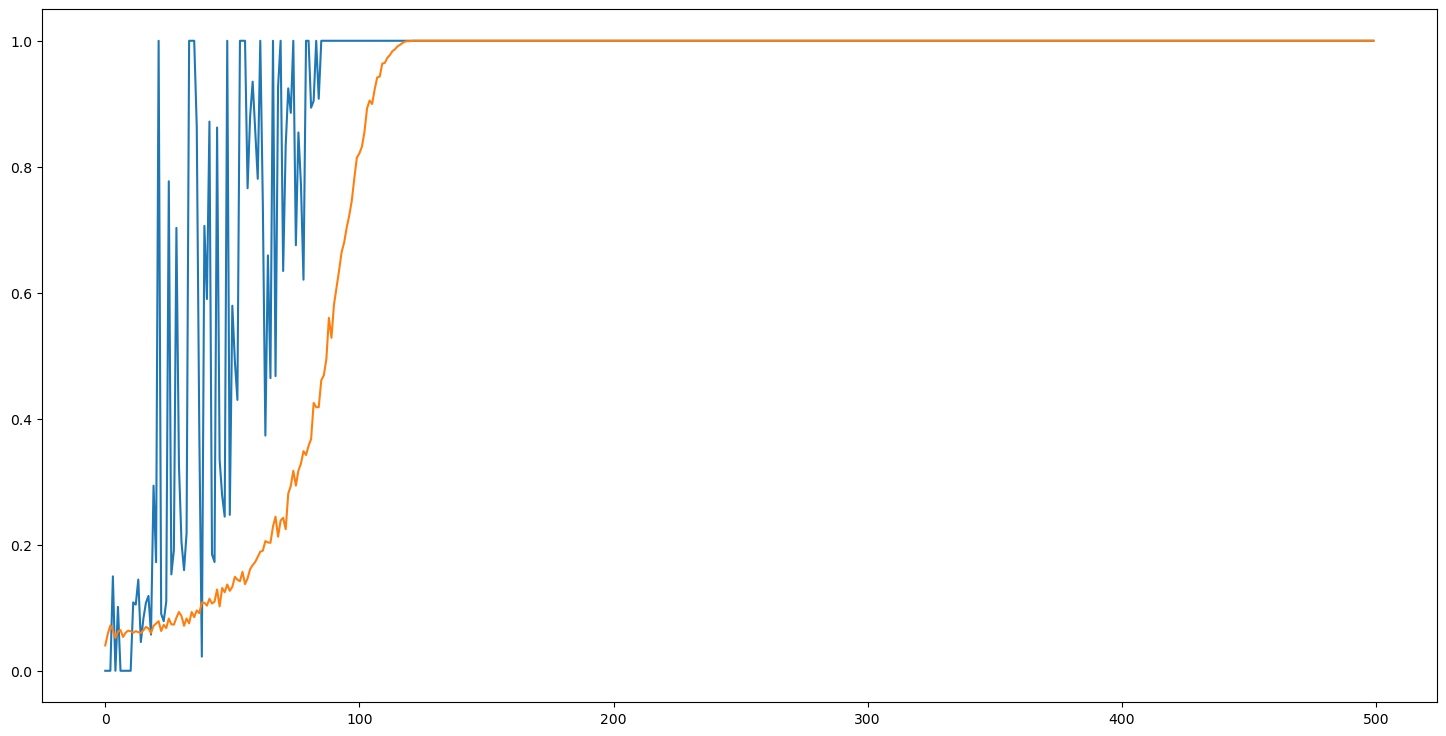

In [32]:
# Точность
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

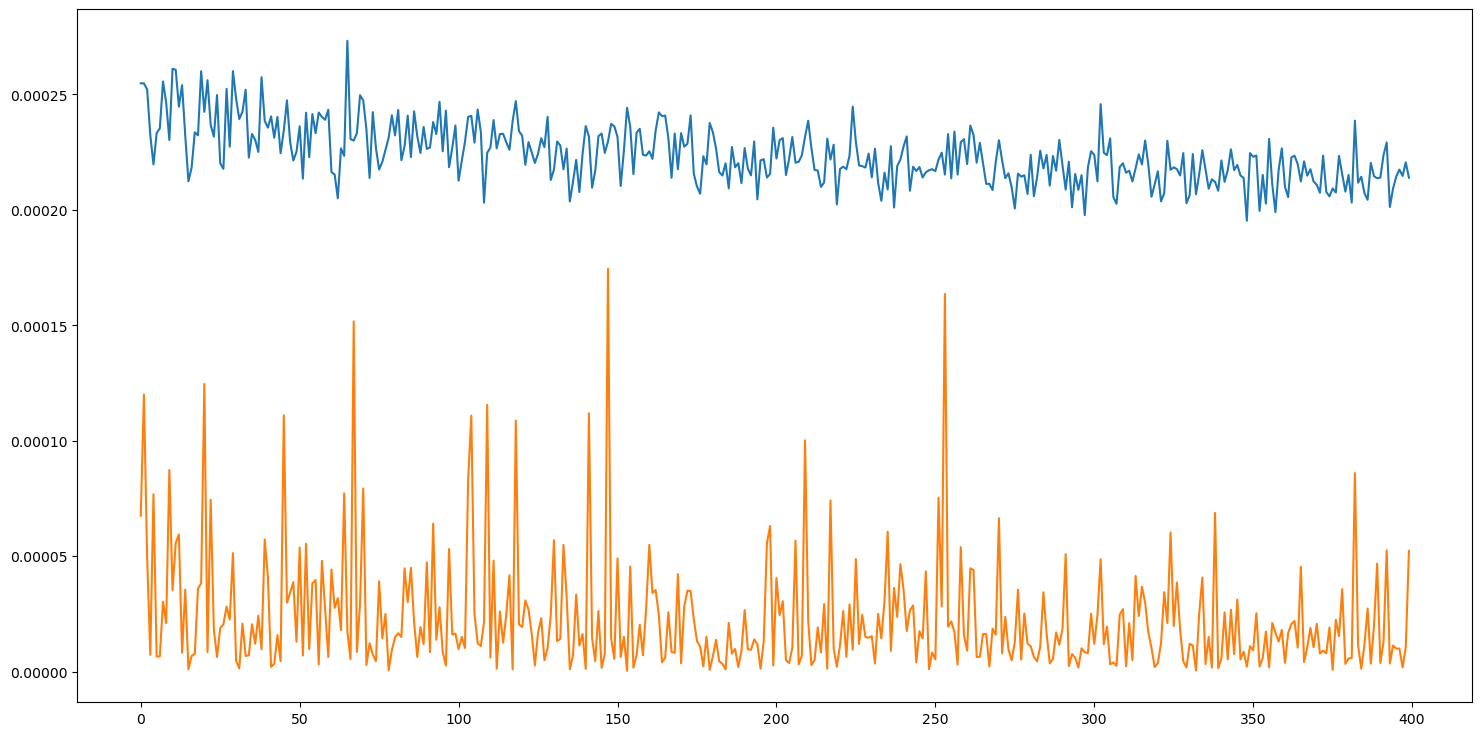

In [33]:
# Cреднеквадратичная ошибка
plt.plot(history.history['mean_squared_error'][100:])
plt.plot(history.history['val_mean_squared_error'][100:])

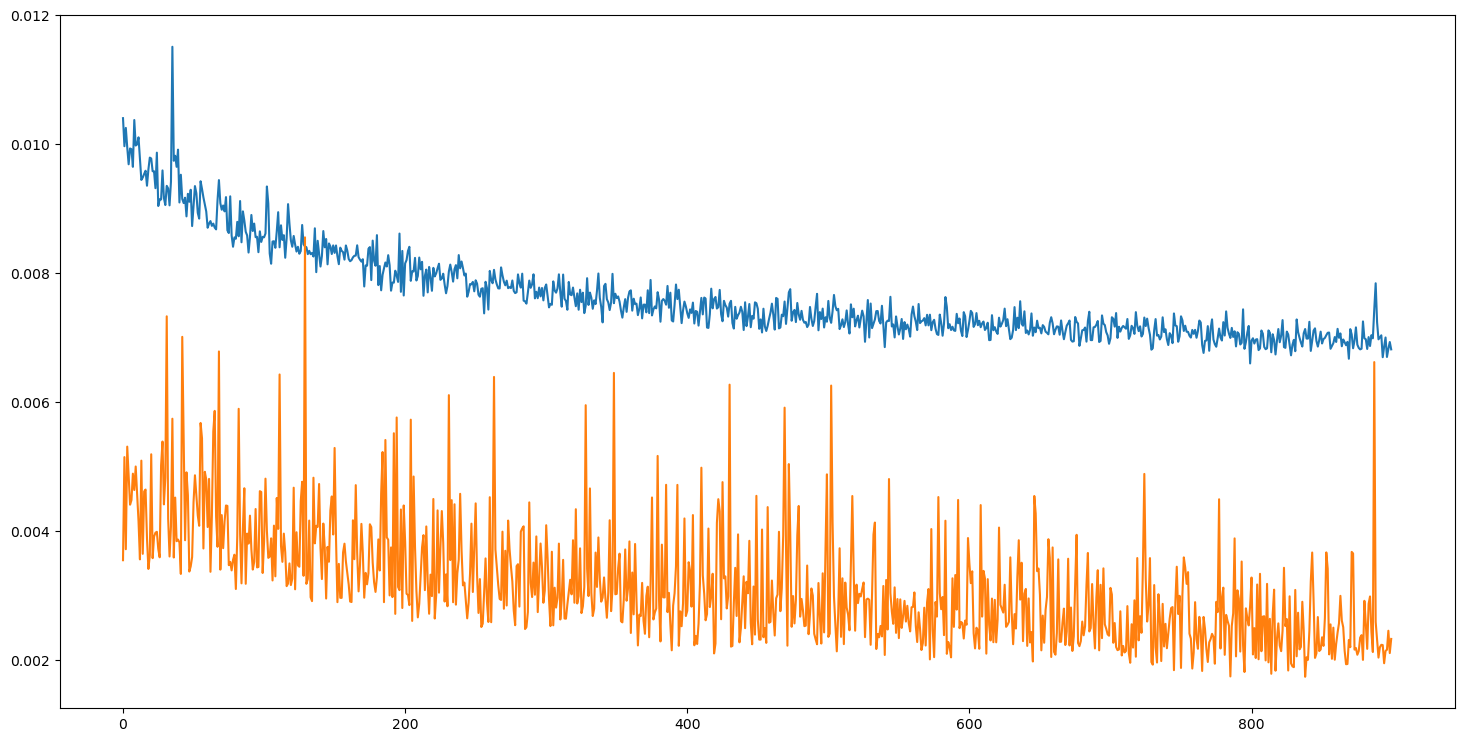

In [325]:
# Cредняя абсолютная ошибка
plt.plot(history.history['mean_absolute_error'][100:])
plt.plot(history.history['val_mean_absolute_error'][100:])

798 / 800 (1)							

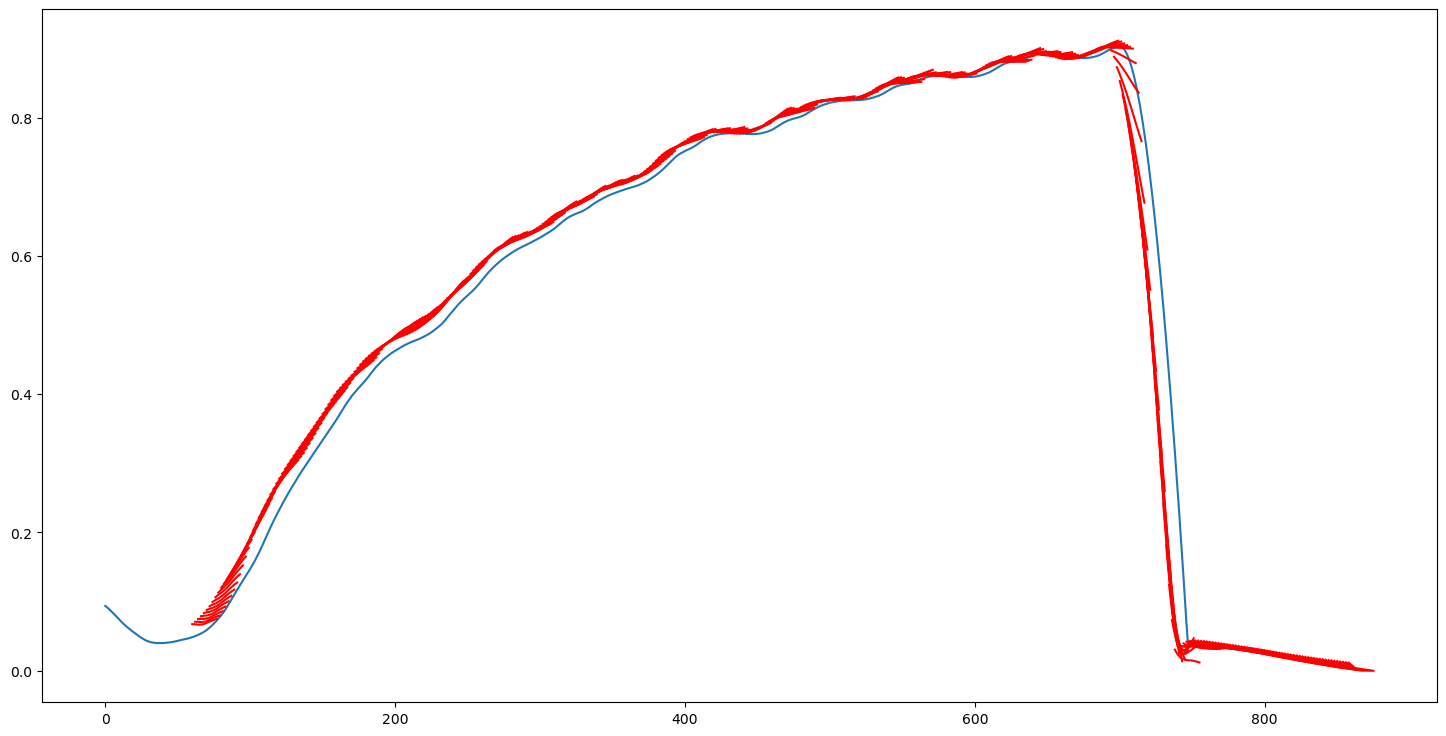

In [425]:
start_pos = 0
prediction_distance = out_steps // 9
test_distance = 800

plt.plot([x for x in range(start_pos , test_distance)], DropTestRawData[start_pos:test_distance])
for i in range(start_pos, test_distance, prediction_distance):
    print(f"\r{i} / {test_distance} ({(test_distance - i)//prediction_distance })\t\t\t\t\t", end="")
    x_value = X_dropTest[i].reshape((1, time_steps, 1))
    plt.plot([x + 60 for x in range(i , i + out_steps)], model.predict(x_value, verbose=0)[0], color='r')

1498 / 1500 (1)							

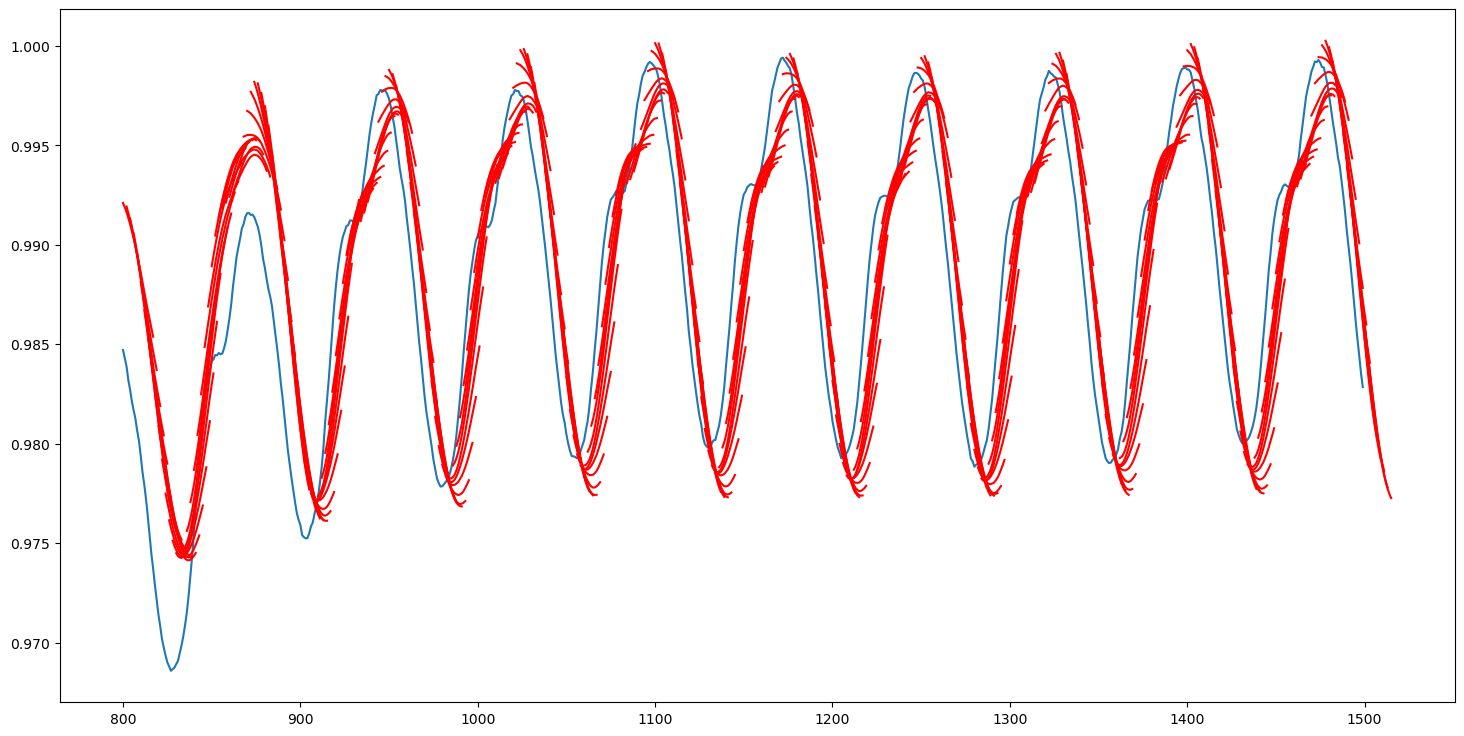

In [525]:
start_pos = 800
prediction_distance = out_steps // 9
test_distance = 1500

plt.plot([x for x in range(start_pos , test_distance)], normalRawData[start_pos:test_distance])
for i in range(start_pos, test_distance, prediction_distance):
    print(f"\r{i} / {test_distance} ({(test_distance - i)//prediction_distance })\t\t\t\t\t", end="")
    x_value = X_test[i].reshape((1, time_steps, 1))
    plt.plot([x for x in range(i , i + out_steps)], model.predict(x_value, verbose=0)[0], color='r')

948 / 950 (1)							

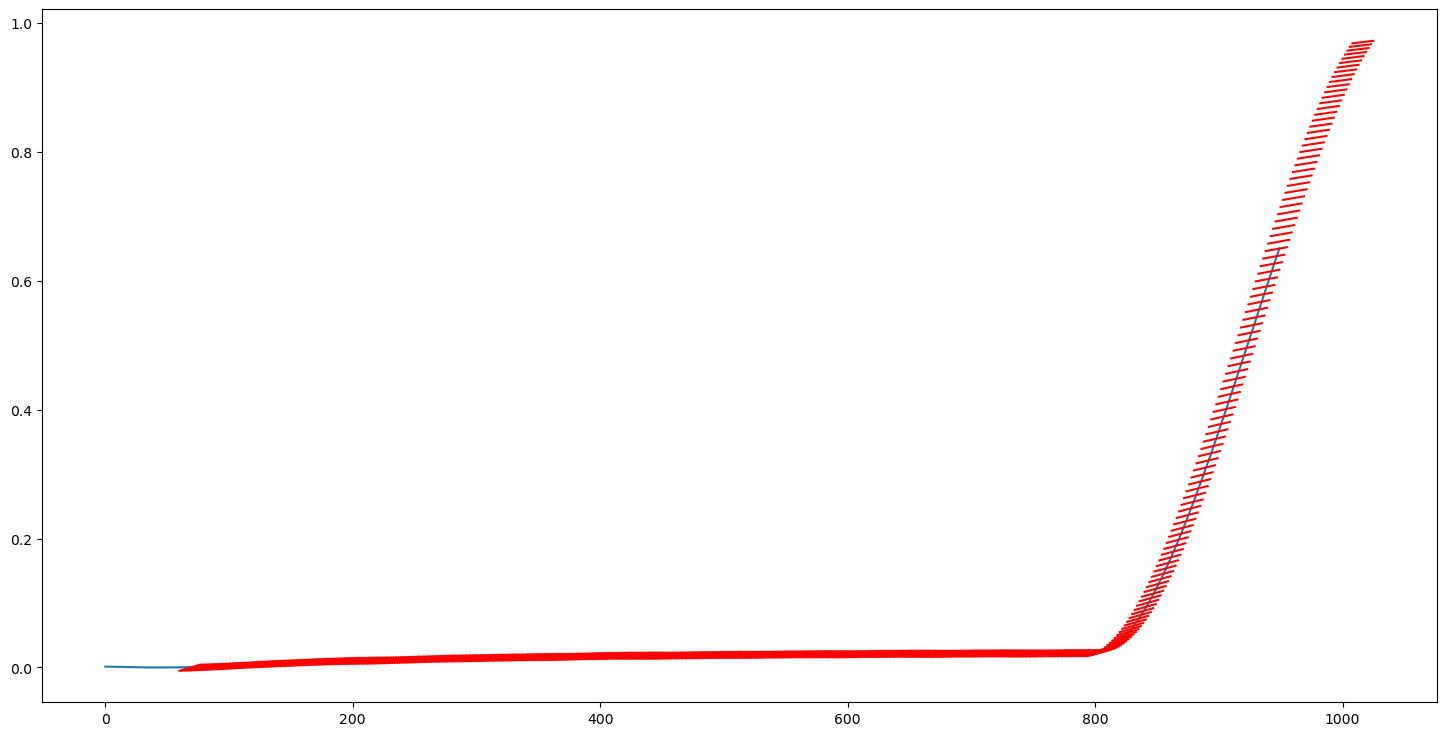

In [538]:
start_pos = 0
prediction_distance = out_steps // 9
test_distance = 950

plt.plot([x for x in range(start_pos , test_distance)], RiseTestRawData[start_pos:test_distance])
for i in range(start_pos, test_distance, prediction_distance):
    print(f"\r{i} / {test_distance} ({(test_distance - i)//prediction_distance })\t\t\t\t\t", end="")
    x_value = X_riseTest[i].reshape((1, time_steps, 1))
    plt.plot([x + 60 for x in range(i , i + out_steps)], model.predict(x_value, verbose=0)[0], color='r')

1998 / 2000 (0)						

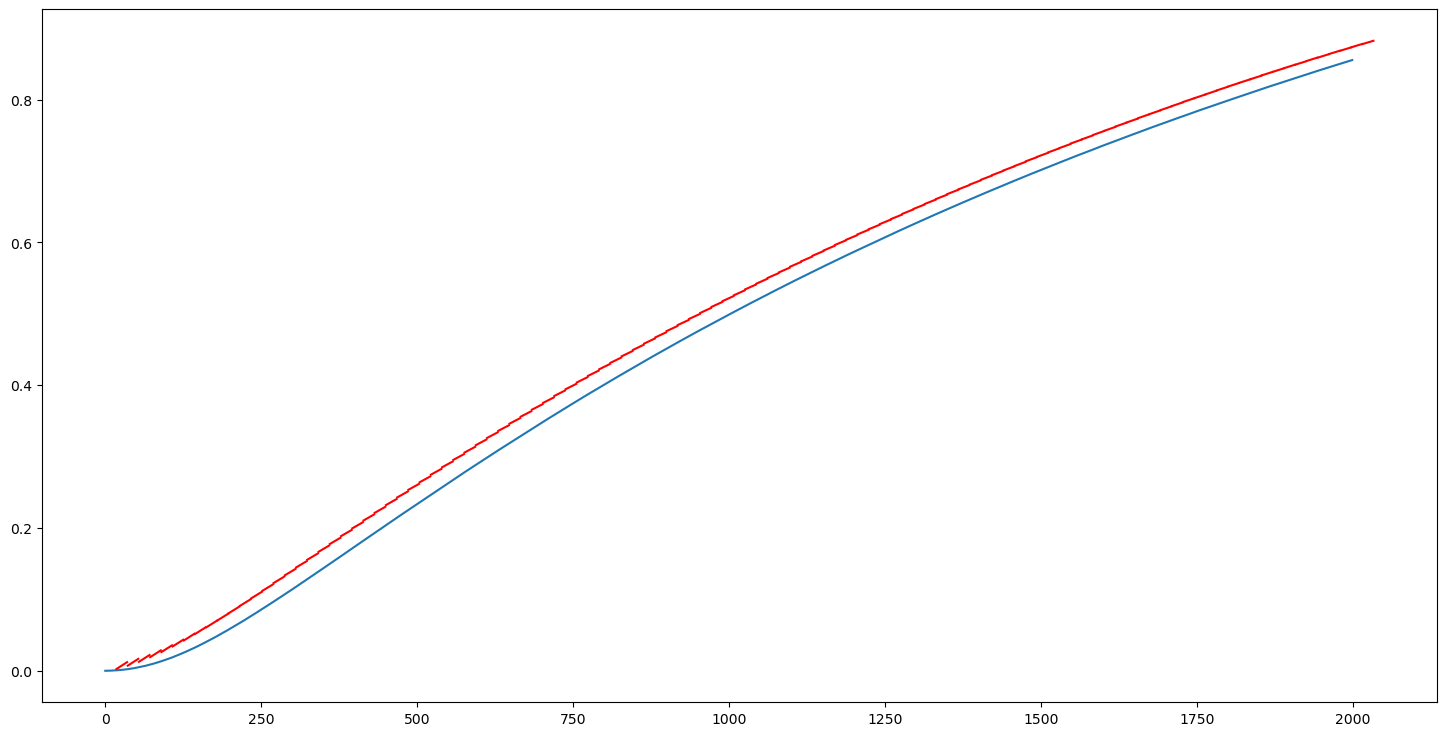

In [551]:
start_pos = 0
prediction_distance = out_steps // 1
test_distance = 2000


predictions = []
plt.plot([x for x in range(start_pos , test_distance)], normalRawData[start_pos:test_distance])
for i in range(start_pos, test_distance, prediction_distance):
    print(f"\r{i} / {test_distance} ({(test_distance - i)//prediction_distance })\t\t\t\t\t", end="")
    x_value = X_test[i].reshape((1, time_steps, 1))
    predictions.append(model.predict(x_value, verbose=0)[0][-1])
    plt.plot([x + 18 for x in range(i , i + out_steps)], model.predict(x_value, verbose=0)[0], color='r')

99 / 100					

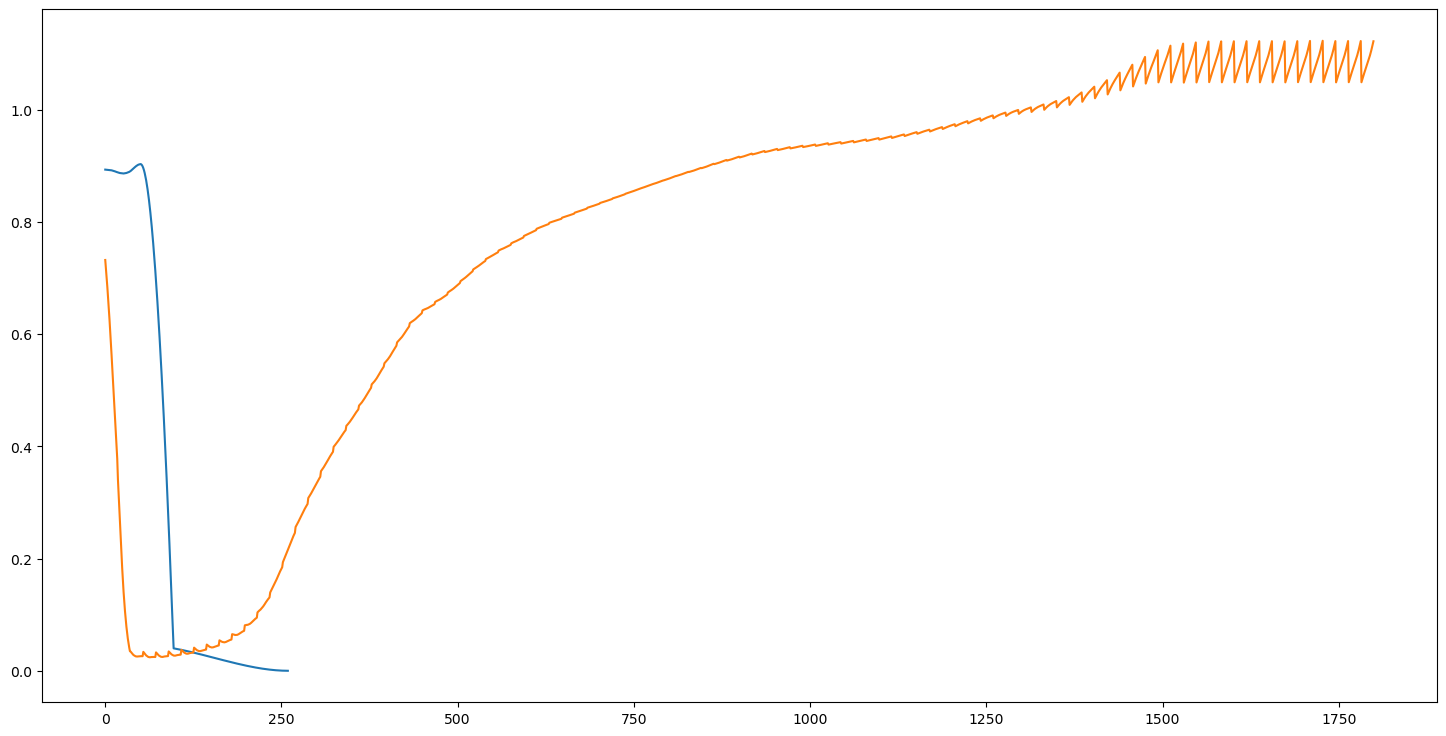

In [440]:
start_pos = 650
prediction_distance = out_steps
test_distance = 100

x_value = X_dropTest[start_pos].reshape((1, time_steps, 1))

plt.plot(DropTestRawData[start_pos:start_pos + test_distance * prediction_distance])

predictions = []
for i in range(test_distance):
    print(f"\r{i} / {test_distance}\t\t\t\t\t", end="")
    
    prediction = model.predict(x_value, verbose=0)
    prediction = prediction.reshape(out_steps, 1)
    
#     print(i)
#     print(x_value)
#     print(prediction)
    for el in prediction:
        predictions.append(el[0])
#     plt.plot([x for x in range(i, i + prediction_distance)], prediction[0], color='r')
    
    x_value = np.roll(x_value, -out_steps, axis=1)
    x_value[0][-out_steps:] = prediction
       
plt.plot(predictions)

99 / 100					

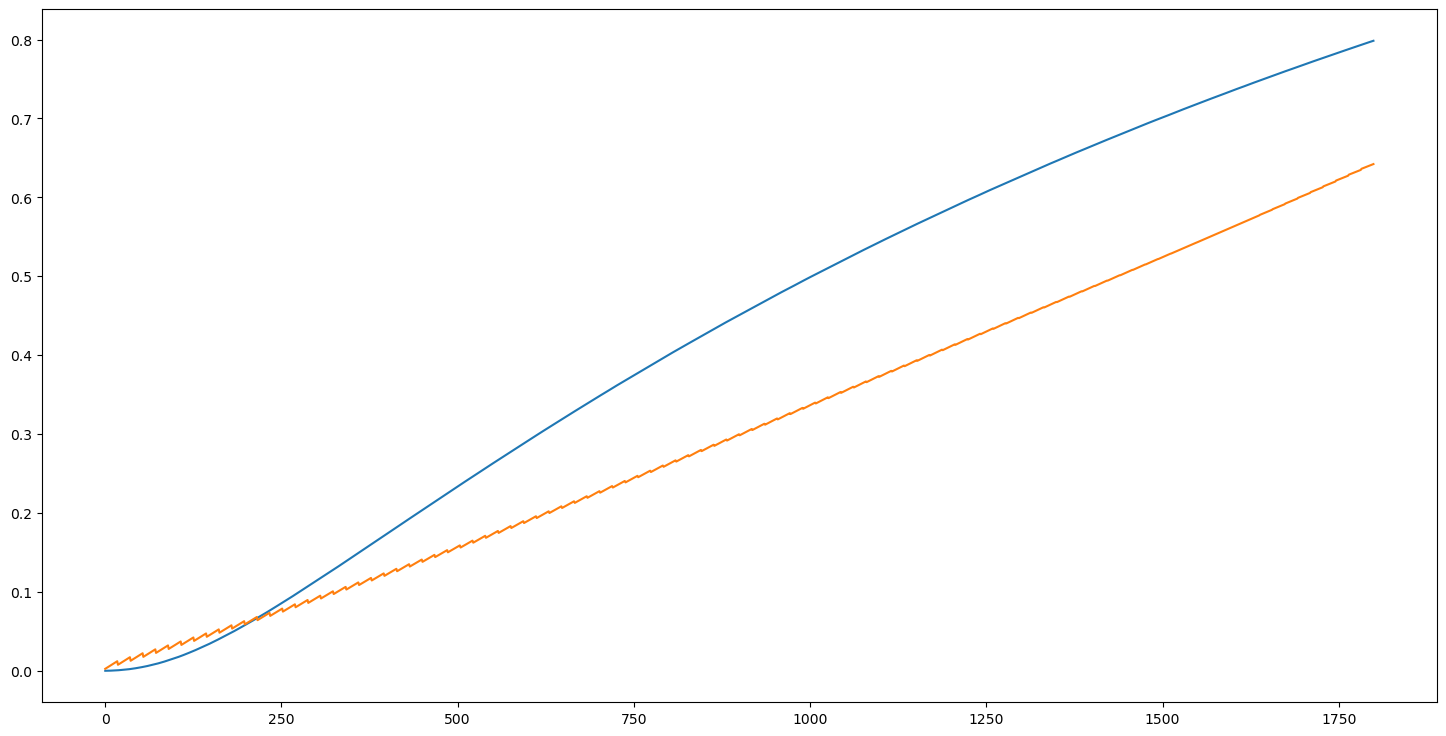

In [572]:
start_pos = 0
prediction_distance = out_steps
test_distance = 100

x_value = X_test[start_pos].reshape((1, time_steps, 1))

plt.plot(normalRawData[start_pos:start_pos + test_distance * prediction_distance])

predictions = []
for i in range(test_distance):
    print(f"\r{i} / {test_distance}\t\t\t\t\t", end="")
    
    prediction = model.predict(x_value, verbose=0)
    prediction = prediction.reshape(out_steps, 1)
    
#     print(i)
#     print(x_value)
#     print(prediction)
    for el in prediction:
        predictions.append(el[0])
#     plt.plot([x for x in range(i, i + prediction_distance)], prediction[0], color='r')
    
    x_value = np.roll(x_value, -out_steps, axis=1)
    x_value[0][-out_steps:] = prediction
       
plt.plot(predictions)

In [22]:
def predictNvalue(x_data, N = 180):

    x_value = x_data.reshape((1, time_steps, 1))

    predictions = None
    old_value = 0
    while True:

        prediction = model.predict(x_value, verbose=0)        

        
        prediction = prediction.reshape(out_steps)
        
        if (predictions is None):
            predictions = prediction
        else:
            predictions = np.concatenate((predictions, prediction), axis=0)
            
        x_value = np.roll(x_value, -out_steps, axis=1)
        prediction = prediction[max(0, out_steps - x_value.shape[1]):]
        x_value[0][-min(out_steps, x_value.shape[1]):] = prediction.reshape(min(out_steps, x_value.shape[1]), 1)


        
        old_value += out_steps
        if old_value >= N:
            break
    return predictions[:N]
       

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

25.02262 44.754017


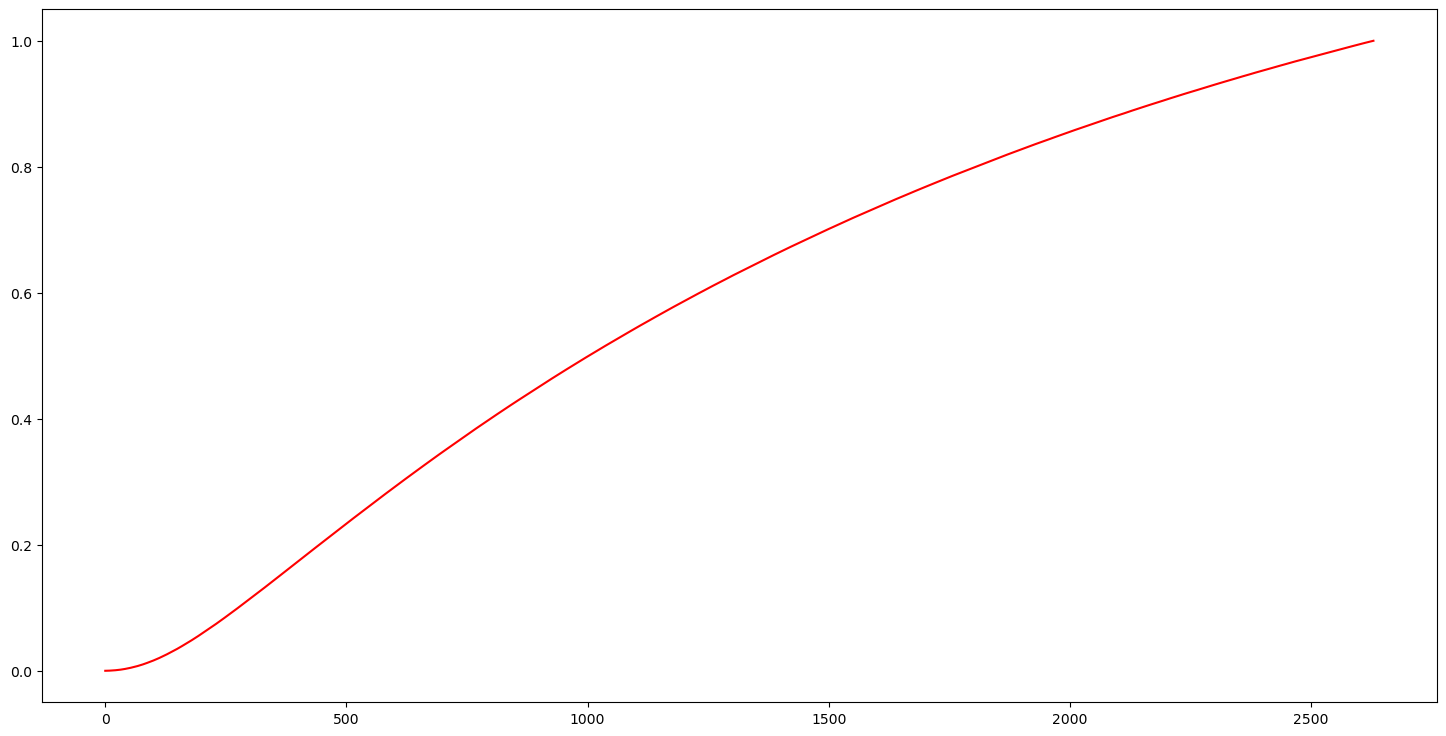

In [573]:
time_steps = 70
y_out_steps = 180
out_steps = 18

# Файлы для обучающей выборки
trainFiles = ['./Temperature/temp2_norm.csv', './Temperature/temp15_modelOtkazTempDrop.csv', './Temperature/temp14_modelOtkazTempRise.csv']#,
#               './Temperature/temp11_otkaz.csv']

# trainFiles = ['./Temperature/temp1_norm.csv', './Temperature/temp3_norm.csv']

# Тестовый файл
testFile = './Temperature/temp11_otkaz.csv'

# Подготовка обучающих и тестовых данных
train_X, train_y, test_X_180, test_y_180, normalRawData = getAllData([], testFile, time_steps, y_out_steps)

test_X_180 = test_X_180[::3]
test_y_180 = test_y_180[::3]

# # Тестовые данные с возрастающей ошибкой
# _, _, RiseTest_X, RiseTest_y, RiseTestRawData = getAllData(trainFiles + [testFile], './Temperature/temp16_modelOtkazTempRise.csv'
#                                                            , time_steps, y_out_steps)

# # Тестовые данные с падающей ошибкой
# _, _, DropTest_X, DropTest_y, DropTestRawData = getAllData(trainFiles + [testFile], './Temperature/temp17_modelOtkazTempDrop.csv'
#                                                            , time_steps, y_out_steps)

# maxTest_X = np.concatenate((test_X[:1000], RiseTest_X, DropTest_X), axis=0)
# maxTest_y = np.concatenate((test_y[:1000], RiseTest_y, DropTest_y), axis=0)

# print(test_X[:1000].shape, RiseTest_X.shape, DropTest_X.shape, maxTest_X.shape)
# print(test_y[:1000].shape, RiseTest_y.shape, DropTest_y.shape, maxTest_y.shape)

X_test_180 = np.reshape(test_X_180, (test_X_180.shape[0], test_X_180.shape[1], 1))

In [569]:
predictions = None
counter = 0
for el in X_test:    
    print(f"\r{counter} / {len(X_test)}\t\t\t\t\t\t", end='')
    counter += 1
    prediction = predictNvalue(el, 180).reshape(1, 180, 1)
    if (predictions is None):
        predictions = prediction
    else:
        predictions = np.concatenate((predictions, prediction), axis=0)
print(predictions.shape)

793 / 794						(794, 180, 1)


In [570]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error, max_error
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])
print(predictions.shape)

print(mean_absolute_error(test_y, predictions))
print(mean_squared_error(test_y, predictions))
print(mean_absolute_percentage_error(test_y, predictions))
print(median_absolute_error(test_y, predictions))
# print(max_error(maxTest_y, predictions))

(794, 180)
0.01546136
0.00038090977
0.047941808
0.016508304



200 / 380 (1)					

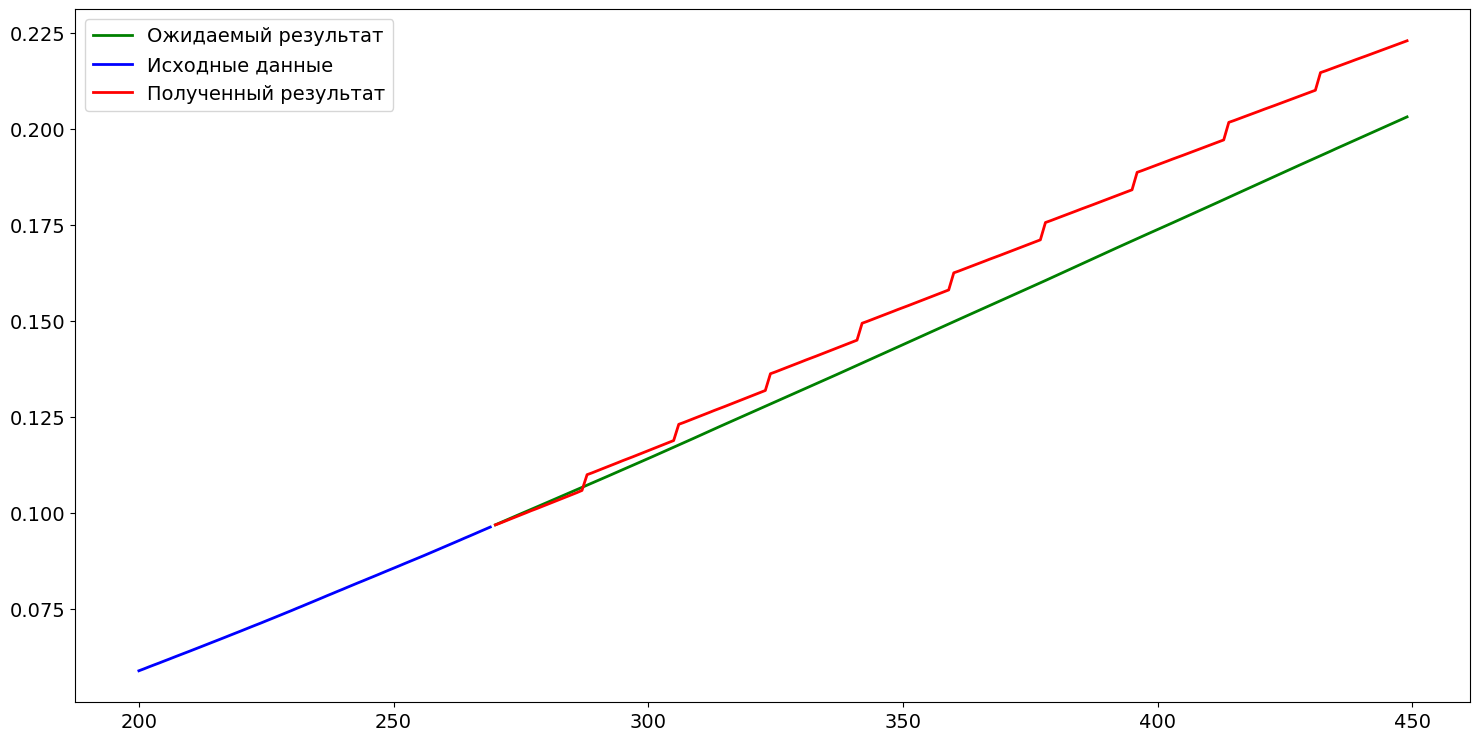

In [95]:
start_pos = 200
prediction_distance = 180#out_steps // 1
test_distance = 380

plt.rcParams['figure.figsize'] = [18, 9]
# plt.title(title, fontsize=18)  # Заголовок графика\n",
# plt.xlabel(xLabelName, fontsize=14)  # Подпись оси X\n",
# plt.ylabel(yLabelName, fontsize=14)  # Подпись оси Y\n",
plt.xticks(fontsize=14)  # Размер шрифта меток по оси X\n",
plt.yticks(fontsize=14)  # Размер шрифта меток по оси Y\n",
plt.grid(False)  # Включаем сетку\n",
  # Добавляем легенду с крупным шрифтом\n",

temp = None
plt.plot([x + 70 for x in range(start_pos , test_distance)], normalRawData[start_pos + 70:test_distance + 70], color = 'green', label='Ожидаемый результат', linewidth = 2)
for i in range(start_pos, test_distance, prediction_distance):
    print(f"\r{i} / {test_distance} ({(test_distance - i)//prediction_distance })\t\t\t\t\t", end="")
    x_value = X_test[i].reshape((1, time_steps, 1))
    plt.plot([x for x in range(i , i + 70)], x_value[0], color='b', label='Исходные данные', linewidth = 2)
    temp = predictNvalue(x_value, 180) - 0.004
    plt.plot([x +70 for x in range(i , i + 180)], predictNvalue(x_value, 180) - 0.004, color='red', label='Полученный результат', linewidth = 2)

plt.legend(fontsize=14)

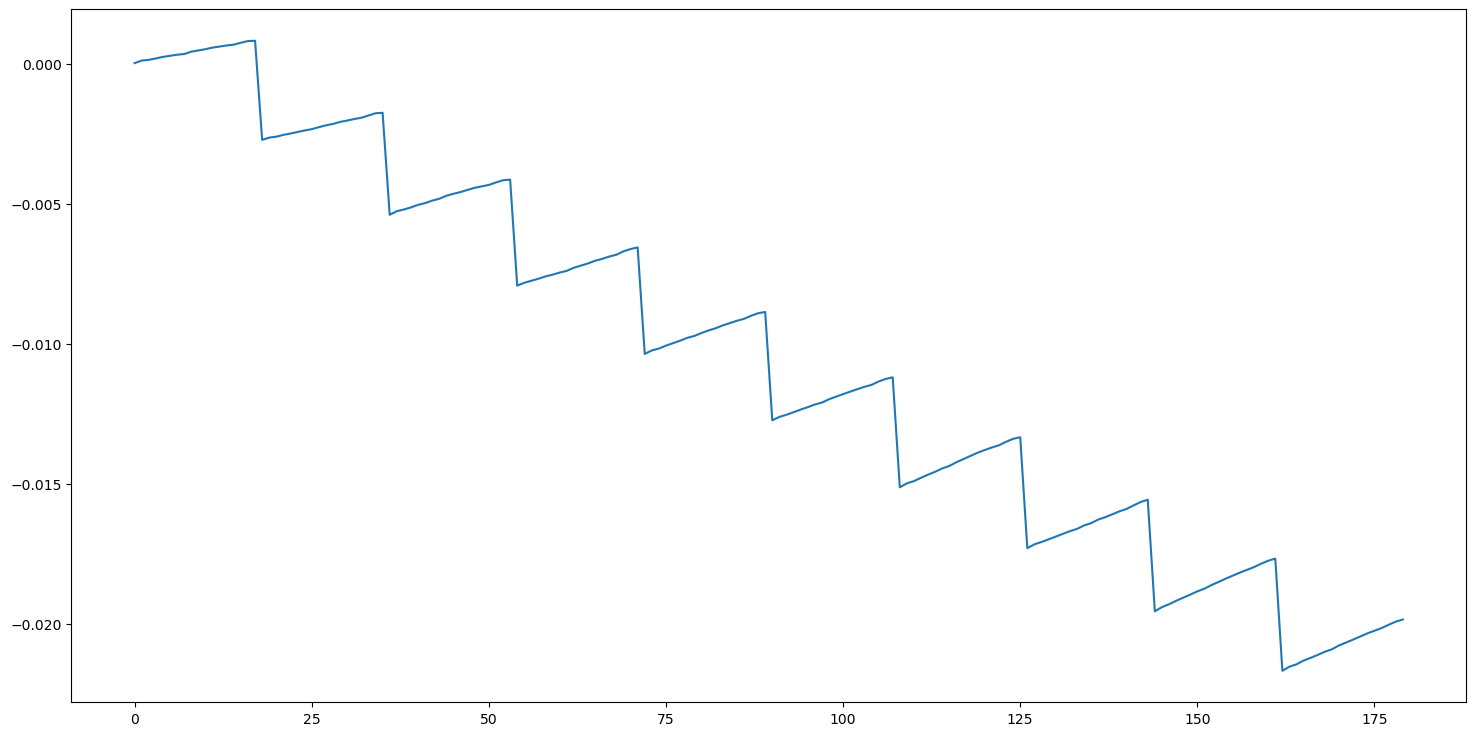

In [100]:
temp = temp.reshape(temp.shape[0])
nrw = normalRawData.reshape(normalRawData.shape[0])
plt.plot(nrw[start_pos + 70:test_distance + 70] - temp)

25.02262 44.754017
2379 / 2380						

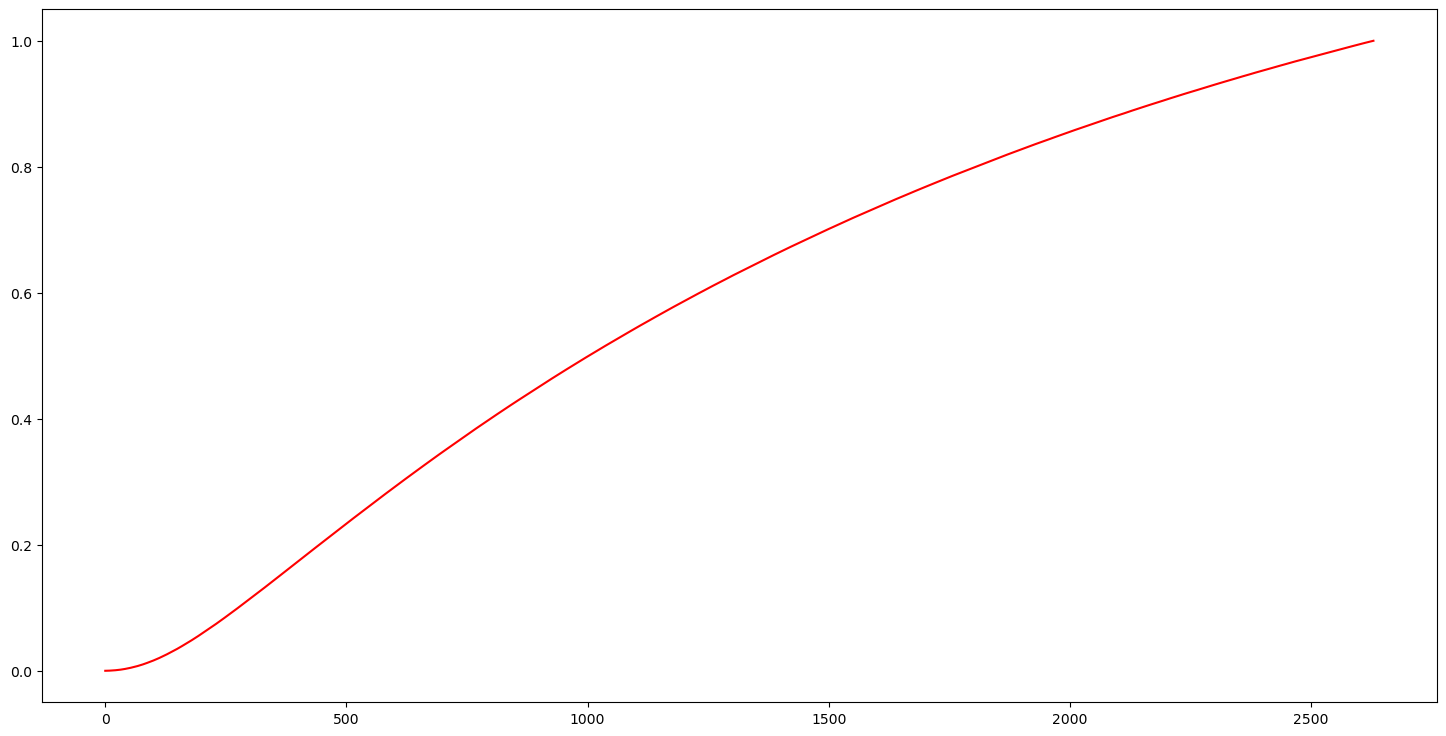

In [101]:
# Подготовка обучающих и тестовых данных
testFile = './Temperature/temp11_otkaz.csv'
_, _, test_X_180, test_y_180, normalRawData_180 = getAllData([], testFile, time_steps, 180)

test_X_180 = test_X_180
test_y_180 = test_y_180

X_test_180 = np.reshape(test_X_180, (test_X_180.shape[0], test_X_180.shape[1], 1))

predictions = None
counter = 0
for el in X_test_180:    
    print(f"\r{counter} / {len(X_test_180)}\t\t\t\t\t\t", end='')
    counter += 1
    prediction = predictNvalue(el, 180).reshape(1, 180, 1)
    if (predictions is None):
        predictions = prediction
    else:
        predictions = np.concatenate((predictions, prediction), axis=0)

predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

In [105]:
import statistics

for t in [1, 6, 12, 18, 30, 60, 120, 180]:
    mae = 0
    mse = 0
    medae_list = []
    max_e = 0
    for i in range(len(test_y_180)):
        mae += abs(test_y_180[i][t-1] - predictions[i][t-1])
        max_e = max(max_e, abs(test_y_180[i][t-1] - predictions[i][t-1]))
        medae_list.append(abs(test_y_180[i][t-1] - predictions[i][t-1]))
        mse += (test_y_180[i][t-1] - predictions[i][t-1]) ** 2
#     print(f"mae[{t}] = {mae / len(test_y_180)}")
    print(f"max[{t}] = {max_e}")
#     print(f"med_ae[{t}] = {statistics.median(medae_list)}")
#     print(f"mse[{t}] = {mse / len(test_y_180)}")

max[1] = 0.004446104168891907
max[6] = 0.005438506603240967
max[12] = 0.007215661928057671
max[18] = 0.008955555036664009
max[30] = 0.015299737453460693
max[60] = 0.02762429229915142
max[120] = 0.04334850609302521
max[180] = 0.05408567190170288


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error


# Задаем количество временных шагов
time_steps_list = [18, 30, 70, 120, 180]
out_steps = 18

metrics_by_time_steps = {}

for time_steps in time_steps_list:
    # Файлы для обучающей выборки
    trainFiles = ['./Temperature/temp6_otkaz.csv', './Temperature/temp11_otkaz.csv']#,

    # trainFiles = ['./Temperature/temp1_norm.csv', './Temperature/temp3_norm.csv']

    # Тестовый файл
    testFile = './Temperature/temp11_otkaz.csv'

    # Подготовка обучающих и тестовых данных
    train_X, train_y, test_X, test_y, normalRawData = getAllData(trainFiles, testFile, time_steps, out_steps)



    # Преобразование данных в формат, подходящий для ввода в LSTM
    X_train = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    X_test = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

    print(X_train.shape)
    print(X_test.shape)

    model = Sequential()
    model.add(LSTM(100, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(out_steps))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mean_squared_error', 'mean_absolute_error'])

    history = model.fit(X_train, train_y, epochs=500, batch_size=32, verbose=1, validation_data=(X_test, test_y))

    model.save(f"./models/tsf_riseDropModelWithWeightNoramal_800ep_{time_steps}ts_{out_steps}os")
    
    plt.clf()
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.savefig(f'./screens/tsf_acc_{time_steps}ts_{out_steps}os.png')
    
    plt.clf()
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.savefig(f'./screens/tsf_mse_{time_steps}ts_{out_steps}os.png')
    
    plt.clf()
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.savefig(f'./screens/tsf_mae_{time_steps}ts_{out_steps}os.png')
    
    # Подготовка обучающих и тестовых данных
    _, _, test_X_180, test_y_180, normalRawData = getAllData([], testFile, time_steps, 180)

    test_X_180 = test_X_180[::10]
    test_y_180 = test_y_180[::10]

    # # Тестовые данные с возрастающей ошибкой
    # _, _, RiseTest_X, RiseTest_y, RiseTestRawData = getAllData(trainFiles + [testFile], './Temperature/temp16_modelOtkazTempRise.csv'
    #                                                            , time_steps, y_out_steps)

    # # Тестовые данные с падающей ошибкой
    # _, _, DropTest_X, DropTest_y, DropTestRawData = getAllData(trainFiles + [testFile], './Temperature/temp17_modelOtkazTempDrop.csv'
    #                                                            , time_steps, y_out_steps)

    # maxTest_X = np.concatenate((test_X[:1000], RiseTest_X, DropTest_X), axis=0)
    # maxTest_y = np.concatenate((test_y[:1000], RiseTest_y, DropTest_y), axis=0)

    # print(test_X[:1000].shape, RiseTest_X.shape, DropTest_X.shape, maxTest_X.shape)
    # print(test_y[:1000].shape, RiseTest_y.shape, DropTest_y.shape, maxTest_y.shape)

    X_test_180 = np.reshape(test_X_180, (test_X_180.shape[0], test_X_180.shape[1], 1))
    
    predictions = None
    counter = 0
    for el in X_test_180:    
        print(f"\r{counter} / {len(X_test_180)}\t\t\t\t\t\t", end='')
        counter += 1
        prediction = predictNvalue(el, 180).reshape(1, 180, 1)
        if (predictions is None):
            predictions = prediction
        else:
            predictions = np.concatenate((predictions, prediction), axis=0)
    
    predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])
    metrics_by_time_steps[time_steps] = {'mean_absolute_error': mean_absolute_error(test_y_180, predictions),
                                        'mean_squared_error': mean_squared_error(test_y_180, predictions), 
                                        'mean_absolute_percentage_error': mean_absolute_percentage_error(test_y_180, predictions),
                                        median_absolute_error : median_absolute_error(test_y_180, predictions)}
    
    print(mean_absolute_error(test_y_180, predictions))
    print(mean_squared_error(test_y_180, predictions))
    print(mean_absolute_percentage_error(test_y_180, predictions))
    print(median_absolute_error(test_y_180, predictions))

print(metrics_by_time_steps)

25.02262 46.16884
(3203, 120, 1)
(539, 120, 1)
Epoch 1/500
101/101 [==============================] - 2s 13ms/step - loss: 0.0306 - accuracy: 0.1864 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1101 - val_loss: 5.9778e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.9778e-04 - val_mean_absolute_error: 0.0226
Epoch 2/500
101/101 [==============================] - 1s 9ms/step - loss: 0.0053 - accuracy: 0.1680 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0540 - val_loss: 6.4389e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.4389e-04 - val_mean_absolute_error: 0.0245
Epoch 3/500
101/101 [==============================] - 1s 9ms/step - loss: 0.0043 - accuracy: 0.1464 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0482 - val_loss: 3.7562e-04 - val_accuracy: 0.2004 - val_mean_squared_error: 3.7562e-04 - val_mean_absolute_error: 0.0185
Epoch 4/500
101/101 [==============================] - 1s 9ms/step - loss: 0.0036 - accuracy: 0.1542 - mean_squar

Epoch 30/500
101/101 [==============================] - 1s 8ms/step - loss: 7.2517e-04 - accuracy: 0.1911 - mean_squared_error: 7.2517e-04 - mean_absolute_error: 0.0194 - val_loss: 2.1470e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1470e-04 - val_mean_absolute_error: 0.0145
Epoch 31/500
101/101 [==============================] - 1s 8ms/step - loss: 7.3005e-04 - accuracy: 0.2086 - mean_squared_error: 7.3005e-04 - mean_absolute_error: 0.0196 - val_loss: 5.3258e-06 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.3258e-06 - val_mean_absolute_error: 0.0018
Epoch 32/500
101/101 [==============================] - 1s 8ms/step - loss: 6.8382e-04 - accuracy: 0.2104 - mean_squared_error: 6.8382e-04 - mean_absolute_error: 0.0188 - val_loss: 3.3806e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.3806e-06 - val_mean_absolute_error: 0.0013
Epoch 33/500
101/101 [==============================] - 1s 8ms/step - loss: 6.4917e-04 - accuracy: 0.2135 - mean_squared_error: 6.4917

101/101 [==============================] - 1s 8ms/step - loss: 2.6802e-04 - accuracy: 0.3057 - mean_squared_error: 2.6802e-04 - mean_absolute_error: 0.0120 - val_loss: 2.4218e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.4218e-04 - val_mean_absolute_error: 0.0155
Epoch 59/500
101/101 [==============================] - 1s 8ms/step - loss: 2.7751e-04 - accuracy: 0.2751 - mean_squared_error: 2.7751e-04 - mean_absolute_error: 0.0123 - val_loss: 8.4686e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.4686e-05 - val_mean_absolute_error: 0.0091
Epoch 60/500
101/101 [==============================] - 1s 8ms/step - loss: 2.6368e-04 - accuracy: 0.2747 - mean_squared_error: 2.6368e-04 - mean_absolute_error: 0.0120 - val_loss: 3.4217e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.4217e-05 - val_mean_absolute_error: 0.0055
Epoch 61/500
101/101 [==============================] - 1s 7ms/step - loss: 2.7141e-04 - accuracy: 0.3194 - mean_squared_error: 2.7141e-04 - mean_a

101/101 [==============================] - 1s 9ms/step - loss: 2.1568e-04 - accuracy: 0.4315 - mean_squared_error: 2.1568e-04 - mean_absolute_error: 0.0106 - val_loss: 4.9989e-05 - val_accuracy: 0.3284 - val_mean_squared_error: 4.9989e-05 - val_mean_absolute_error: 0.0070
Epoch 87/500
101/101 [==============================] - 1s 8ms/step - loss: 1.9853e-04 - accuracy: 0.4858 - mean_squared_error: 1.9853e-04 - mean_absolute_error: 0.0102 - val_loss: 3.4474e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.4474e-05 - val_mean_absolute_error: 0.0058
Epoch 88/500
101/101 [==============================] - 1s 7ms/step - loss: 2.2891e-04 - accuracy: 0.3924 - mean_squared_error: 2.2891e-04 - mean_absolute_error: 0.0108 - val_loss: 3.0441e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.0441e-05 - val_mean_absolute_error: 0.0053
Epoch 89/500
101/101 [==============================] - 1s 8ms/step - loss: 2.1491e-04 - accuracy: 0.4683 - mean_squared_error: 2.1491e-04 - mean_absolute_

101/101 [==============================] - 1s 9ms/step - loss: 1.8885e-04 - accuracy: 0.7228 - mean_squared_error: 1.8885e-04 - mean_absolute_error: 0.0098 - val_loss: 2.2406e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2406e-05 - val_mean_absolute_error: 0.0047
Epoch 115/500
101/101 [==============================] - 1s 9ms/step - loss: 1.9289e-04 - accuracy: 0.7106 - mean_squared_error: 1.9289e-04 - mean_absolute_error: 0.0099 - val_loss: 2.2155e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2155e-05 - val_mean_absolute_error: 0.0046
Epoch 116/500
101/101 [==============================] - 1s 9ms/step - loss: 1.9815e-04 - accuracy: 0.7093 - mean_squared_error: 1.9815e-04 - mean_absolute_error: 0.0100 - val_loss: 8.5858e-06 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.5858e-06 - val_mean_absolute_error: 0.0028
Epoch 117/500
101/101 [==============================] - 1s 9ms/step - loss: 2.0302e-04 - accuracy: 0.6915 - mean_squared_error: 2.0302e-04 - mean_ab

101/101 [==============================] - 1s 9ms/step - loss: 1.8871e-04 - accuracy: 0.9438 - mean_squared_error: 1.8871e-04 - mean_absolute_error: 0.0096 - val_loss: 5.6837e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.6837e-05 - val_mean_absolute_error: 0.0074
Epoch 143/500
101/101 [==============================] - 1s 9ms/step - loss: 1.9724e-04 - accuracy: 0.9732 - mean_squared_error: 1.9724e-04 - mean_absolute_error: 0.0098 - val_loss: 2.5034e-07 - val_accuracy: 1.0000 - val_mean_squared_error: 2.5034e-07 - val_mean_absolute_error: 3.9111e-04
Epoch 144/500
101/101 [==============================] - 1s 8ms/step - loss: 2.1222e-04 - accuracy: 0.9479 - mean_squared_error: 2.1222e-04 - mean_absolute_error: 0.0104 - val_loss: 4.5903e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.5903e-05 - val_mean_absolute_error: 0.0067
Epoch 145/500
101/101 [==============================] - 1s 8ms/step - loss: 1.9018e-04 - accuracy: 0.9363 - mean_squared_error: 1.9018e-04 - mean_ab

101/101 [==============================] - 1s 9ms/step - loss: 1.9902e-04 - accuracy: 1.0000 - mean_squared_error: 1.9902e-04 - mean_absolute_error: 0.0100 - val_loss: 3.6947e-07 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6947e-07 - val_mean_absolute_error: 5.2265e-04
Epoch 171/500
101/101 [==============================] - 1s 9ms/step - loss: 2.0319e-04 - accuracy: 1.0000 - mean_squared_error: 2.0319e-04 - mean_absolute_error: 0.0100 - val_loss: 1.0627e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0627e-06 - val_mean_absolute_error: 8.9159e-04
Epoch 172/500
101/101 [==============================] - 1s 9ms/step - loss: 1.9435e-04 - accuracy: 1.0000 - mean_squared_error: 1.9435e-04 - mean_absolute_error: 0.0098 - val_loss: 4.2372e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.2372e-06 - val_mean_absolute_error: 0.0020
Epoch 173/500
101/101 [==============================] - 1s 9ms/step - loss: 2.1698e-04 - accuracy: 1.0000 - mean_squared_error: 2.1698e-04 - mea

101/101 [==============================] - 1s 9ms/step - loss: 2.0509e-04 - accuracy: 1.0000 - mean_squared_error: 2.0509e-04 - mean_absolute_error: 0.0098 - val_loss: 1.5476e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5476e-04 - val_mean_absolute_error: 0.0124
Epoch 199/500
101/101 [==============================] - 1s 9ms/step - loss: 1.9411e-04 - accuracy: 1.0000 - mean_squared_error: 1.9411e-04 - mean_absolute_error: 0.0098 - val_loss: 3.7204e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.7204e-06 - val_mean_absolute_error: 0.0019
Epoch 200/500
101/101 [==============================] - 1s 9ms/step - loss: 1.7679e-04 - accuracy: 1.0000 - mean_squared_error: 1.7679e-04 - mean_absolute_error: 0.0092 - val_loss: 8.7228e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 8.7228e-06 - val_mean_absolute_error: 0.0026
Epoch 201/500
101/101 [==============================] - 1s 9ms/step - loss: 1.9064e-04 - accuracy: 1.0000 - mean_squared_error: 1.9064e-04 - mean_absolu

101/101 [==============================] - 1s 8ms/step - loss: 2.0080e-04 - accuracy: 1.0000 - mean_squared_error: 2.0080e-04 - mean_absolute_error: 0.0099 - val_loss: 8.0542e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 8.0542e-06 - val_mean_absolute_error: 0.0028
Epoch 227/500
101/101 [==============================] - 1s 8ms/step - loss: 2.1181e-04 - accuracy: 1.0000 - mean_squared_error: 2.1181e-04 - mean_absolute_error: 0.0102 - val_loss: 6.9783e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 6.9783e-05 - val_mean_absolute_error: 0.0083
Epoch 228/500
101/101 [==============================] - 1s 8ms/step - loss: 1.8046e-04 - accuracy: 1.0000 - mean_squared_error: 1.8046e-04 - mean_absolute_error: 0.0094 - val_loss: 3.0188e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.0188e-06 - val_mean_absolute_error: 0.0016
Epoch 229/500
101/101 [==============================] - 1s 8ms/step - loss: 1.8448e-04 - accuracy: 1.0000 - mean_squared_error: 1.8448e-04 - mean_absolu

101/101 [==============================] - 1s 9ms/step - loss: 1.8111e-04 - accuracy: 1.0000 - mean_squared_error: 1.8111e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1020e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1020e-06 - val_mean_absolute_error: 8.5812e-04
Epoch 255/500
101/101 [==============================] - 1s 8ms/step - loss: 1.9041e-04 - accuracy: 1.0000 - mean_squared_error: 1.9041e-04 - mean_absolute_error: 0.0096 - val_loss: 2.0388e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.0388e-06 - val_mean_absolute_error: 0.0014
Epoch 256/500
101/101 [==============================] - 1s 9ms/step - loss: 1.6598e-04 - accuracy: 1.0000 - mean_squared_error: 1.6598e-04 - mean_absolute_error: 0.0090 - val_loss: 1.0403e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0403e-05 - val_mean_absolute_error: 0.0032
Epoch 257/500
101/101 [==============================] - 1s 9ms/step - loss: 1.8062e-04 - accuracy: 1.0000 - mean_squared_error: 1.8062e-04 - mean_ab

101/101 [==============================] - 1s 9ms/step - loss: 1.7935e-04 - accuracy: 1.0000 - mean_squared_error: 1.7935e-04 - mean_absolute_error: 0.0094 - val_loss: 1.8572e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.8572e-06 - val_mean_absolute_error: 0.0012
Epoch 283/500
101/101 [==============================] - 1s 9ms/step - loss: 1.8922e-04 - accuracy: 1.0000 - mean_squared_error: 1.8922e-04 - mean_absolute_error: 0.0094 - val_loss: 4.7275e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.7275e-06 - val_mean_absolute_error: 0.0021
Epoch 284/500
101/101 [==============================] - 1s 8ms/step - loss: 1.9073e-04 - accuracy: 1.0000 - mean_squared_error: 1.9073e-04 - mean_absolute_error: 0.0094 - val_loss: 3.6958e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6958e-06 - val_mean_absolute_error: 0.0018
Epoch 285/500
101/101 [==============================] - 1s 9ms/step - loss: 1.9372e-04 - accuracy: 1.0000 - mean_squared_error: 1.9372e-04 - mean_absolu

101/101 [==============================] - 1s 7ms/step - loss: 1.8341e-04 - accuracy: 1.0000 - mean_squared_error: 1.8341e-04 - mean_absolute_error: 0.0094 - val_loss: 7.4627e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 7.4627e-05 - val_mean_absolute_error: 0.0086
Epoch 311/500
101/101 [==============================] - 1s 7ms/step - loss: 2.0185e-04 - accuracy: 1.0000 - mean_squared_error: 2.0185e-04 - mean_absolute_error: 0.0102 - val_loss: 1.4968e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4968e-05 - val_mean_absolute_error: 0.0037
Epoch 312/500
101/101 [==============================] - 1s 7ms/step - loss: 1.7545e-04 - accuracy: 1.0000 - mean_squared_error: 1.7545e-04 - mean_absolute_error: 0.0092 - val_loss: 1.4208e-07 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4208e-07 - val_mean_absolute_error: 3.0936e-04
Epoch 313/500
101/101 [==============================] - 1s 7ms/step - loss: 1.8286e-04 - accuracy: 1.0000 - mean_squared_error: 1.8286e-04 - mean_ab

101/101 [==============================] - 1s 7ms/step - loss: 1.7664e-04 - accuracy: 1.0000 - mean_squared_error: 1.7664e-04 - mean_absolute_error: 0.0092 - val_loss: 1.4699e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4699e-04 - val_mean_absolute_error: 0.0119
Epoch 339/500
101/101 [==============================] - 1s 7ms/step - loss: 1.7796e-04 - accuracy: 1.0000 - mean_squared_error: 1.7796e-04 - mean_absolute_error: 0.0092 - val_loss: 2.1485e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.1485e-06 - val_mean_absolute_error: 0.0012
Epoch 340/500
101/101 [==============================] - 1s 7ms/step - loss: 1.8627e-04 - accuracy: 1.0000 - mean_squared_error: 1.8627e-04 - mean_absolute_error: 0.0094 - val_loss: 8.5411e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 8.5411e-06 - val_mean_absolute_error: 0.0026
Epoch 341/500
101/101 [==============================] - 1s 7ms/step - loss: 1.8952e-04 - accuracy: 1.0000 - mean_squared_error: 1.8952e-04 - mean_absolu

101/101 [==============================] - 1s 7ms/step - loss: 1.8640e-04 - accuracy: 1.0000 - mean_squared_error: 1.8640e-04 - mean_absolute_error: 0.0096 - val_loss: 5.5421e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.5421e-06 - val_mean_absolute_error: 0.0023
Epoch 367/500
101/101 [==============================] - 1s 7ms/step - loss: 1.6873e-04 - accuracy: 1.0000 - mean_squared_error: 1.6873e-04 - mean_absolute_error: 0.0091 - val_loss: 2.8726e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.8726e-05 - val_mean_absolute_error: 0.0053
Epoch 368/500
101/101 [==============================] - 1s 7ms/step - loss: 1.7358e-04 - accuracy: 1.0000 - mean_squared_error: 1.7358e-04 - mean_absolute_error: 0.0091 - val_loss: 2.9975e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9975e-06 - val_mean_absolute_error: 0.0017
Epoch 369/500
101/101 [==============================] - 1s 7ms/step - loss: 1.8042e-04 - accuracy: 1.0000 - mean_squared_error: 1.8042e-04 - mean_absolu

101/101 [==============================] - 1s 8ms/step - loss: 1.7315e-04 - accuracy: 1.0000 - mean_squared_error: 1.7315e-04 - mean_absolute_error: 0.0091 - val_loss: 7.3289e-07 - val_accuracy: 1.0000 - val_mean_squared_error: 7.3289e-07 - val_mean_absolute_error: 7.7774e-04
Epoch 395/500
101/101 [==============================] - 1s 8ms/step - loss: 1.8405e-04 - accuracy: 1.0000 - mean_squared_error: 1.8405e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0991e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0991e-05 - val_mean_absolute_error: 0.0033
Epoch 396/500
101/101 [==============================] - 1s 8ms/step - loss: 1.8035e-04 - accuracy: 1.0000 - mean_squared_error: 1.8035e-04 - mean_absolute_error: 0.0094 - val_loss: 5.2265e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.2265e-06 - val_mean_absolute_error: 0.0022
Epoch 397/500
101/101 [==============================] - 1s 8ms/step - loss: 1.7211e-04 - accuracy: 1.0000 - mean_squared_error: 1.7211e-04 - mean_ab

101/101 [==============================] - 1s 8ms/step - loss: 1.8713e-04 - accuracy: 1.0000 - mean_squared_error: 1.8713e-04 - mean_absolute_error: 0.0094 - val_loss: 5.3089e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.3089e-06 - val_mean_absolute_error: 0.0023
Epoch 423/500
101/101 [==============================] - 1s 8ms/step - loss: 1.8573e-04 - accuracy: 1.0000 - mean_squared_error: 1.8573e-04 - mean_absolute_error: 0.0093 - val_loss: 2.1314e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.1314e-06 - val_mean_absolute_error: 0.0014
Epoch 424/500
101/101 [==============================] - 1s 8ms/step - loss: 1.6080e-04 - accuracy: 1.0000 - mean_squared_error: 1.6080e-04 - mean_absolute_error: 0.0088 - val_loss: 1.1229e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1229e-05 - val_mean_absolute_error: 0.0033
Epoch 425/500
101/101 [==============================] - 1s 8ms/step - loss: 1.8421e-04 - accuracy: 1.0000 - mean_squared_error: 1.8421e-04 - mean_absolu

101/101 [==============================] - 1s 8ms/step - loss: 1.7861e-04 - accuracy: 1.0000 - mean_squared_error: 1.7861e-04 - mean_absolute_error: 0.0092 - val_loss: 9.9773e-07 - val_accuracy: 1.0000 - val_mean_squared_error: 9.9773e-07 - val_mean_absolute_error: 9.3828e-04
Epoch 451/500
101/101 [==============================] - 1s 8ms/step - loss: 1.7889e-04 - accuracy: 1.0000 - mean_squared_error: 1.7889e-04 - mean_absolute_error: 0.0093 - val_loss: 5.2947e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.2947e-06 - val_mean_absolute_error: 0.0023
Epoch 452/500
101/101 [==============================] - 1s 8ms/step - loss: 1.7692e-04 - accuracy: 1.0000 - mean_squared_error: 1.7692e-04 - mean_absolute_error: 0.0091 - val_loss: 3.5596e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5596e-06 - val_mean_absolute_error: 0.0018
Epoch 453/500
101/101 [==============================] - 1s 8ms/step - loss: 1.8197e-04 - accuracy: 1.0000 - mean_squared_error: 1.8197e-04 - mean_ab

101/101 [==============================] - 1s 8ms/step - loss: 1.9325e-04 - accuracy: 1.0000 - mean_squared_error: 1.9325e-04 - mean_absolute_error: 0.0096 - val_loss: 4.0841e-07 - val_accuracy: 1.0000 - val_mean_squared_error: 4.0841e-07 - val_mean_absolute_error: 5.5550e-04
Epoch 479/500
101/101 [==============================] - 1s 8ms/step - loss: 1.7261e-04 - accuracy: 1.0000 - mean_squared_error: 1.7261e-04 - mean_absolute_error: 0.0092 - val_loss: 2.7828e-07 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7828e-07 - val_mean_absolute_error: 4.3682e-04
Epoch 480/500
101/101 [==============================] - 1s 8ms/step - loss: 1.8064e-04 - accuracy: 1.0000 - mean_squared_error: 1.8064e-04 - mean_absolute_error: 0.0092 - val_loss: 8.4424e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 8.4424e-06 - val_mean_absolute_error: 0.0029
Epoch 481/500
101/101 [==============================] - 1s 8ms/step - loss: 1.7314e-04 - accuracy: 1.0000 - mean_squared_error: 1.7314e-04 - mea

INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_6os\assets


INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_6os\assets


25.02262 44.754017
232 / 233						0.029503917
0.0012223575
0.08638222
0.030271785
25.02262 46.16884
(3179, 120, 1)
(527, 120, 1)
Epoch 1/500
100/100 [==============================] - 2s 12ms/step - loss: 0.0483 - accuracy: 0.0953 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1389 - val_loss: 0.0010 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0285
Epoch 2/500
100/100 [==============================] - 1s 9ms/step - loss: 0.0075 - accuracy: 0.0755 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0641 - val_loss: 2.1950e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1950e-04 - val_mean_absolute_error: 0.0118
Epoch 3/500
100/100 [==============================] - 1s 8ms/step - loss: 0.0053 - accuracy: 0.0617 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0538 - val_loss: 0.0010 - val_accuracy: 0.0531 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0311
Epoch 4/500
100/100 [==========================

Epoch 30/500
100/100 [==============================] - 1s 8ms/step - loss: 7.8573e-04 - accuracy: 0.1434 - mean_squared_error: 7.8573e-04 - mean_absolute_error: 0.0202 - val_loss: 1.8581e-04 - val_accuracy: 0.0797 - val_mean_squared_error: 1.8581e-04 - val_mean_absolute_error: 0.0135
Epoch 31/500
100/100 [==============================] - 1s 8ms/step - loss: 7.1075e-04 - accuracy: 0.1456 - mean_squared_error: 7.1075e-04 - mean_absolute_error: 0.0191 - val_loss: 2.1030e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1030e-05 - val_mean_absolute_error: 0.0040
Epoch 32/500
100/100 [==============================] - 1s 8ms/step - loss: 7.2658e-04 - accuracy: 0.1466 - mean_squared_error: 7.2658e-04 - mean_absolute_error: 0.0194 - val_loss: 6.3025e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.3025e-04 - val_mean_absolute_error: 0.0249
Epoch 33/500
100/100 [==============================] - 1s 8ms/step - loss: 7.5048e-04 - accuracy: 0.1419 - mean_squared_error: 7.5048

100/100 [==============================] - 1s 8ms/step - loss: 2.7877e-04 - accuracy: 0.2045 - mean_squared_error: 2.7877e-04 - mean_absolute_error: 0.0123 - val_loss: 2.3930e-06 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.3930e-06 - val_mean_absolute_error: 0.0012
Epoch 59/500
100/100 [==============================] - 1s 8ms/step - loss: 2.7402e-04 - accuracy: 0.2369 - mean_squared_error: 2.7402e-04 - mean_absolute_error: 0.0122 - val_loss: 1.2781e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.2781e-04 - val_mean_absolute_error: 0.0111
Epoch 60/500
100/100 [==============================] - 1s 8ms/step - loss: 2.7223e-04 - accuracy: 0.2224 - mean_squared_error: 2.7223e-04 - mean_absolute_error: 0.0122 - val_loss: 6.0006e-05 - val_accuracy: 0.0114 - val_mean_squared_error: 6.0006e-05 - val_mean_absolute_error: 0.0076
Epoch 61/500
100/100 [==============================] - 1s 8ms/step - loss: 2.7262e-04 - accuracy: 0.2432 - mean_squared_error: 2.7262e-04 - mean_a

100/100 [==============================] - 1s 8ms/step - loss: 2.2477e-04 - accuracy: 0.3567 - mean_squared_error: 2.2477e-04 - mean_absolute_error: 0.0110 - val_loss: 1.0180e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.0180e-05 - val_mean_absolute_error: 0.0030
Epoch 87/500
100/100 [==============================] - 1s 8ms/step - loss: 2.1069e-04 - accuracy: 0.3536 - mean_squared_error: 2.1069e-04 - mean_absolute_error: 0.0105 - val_loss: 3.9287e-05 - val_accuracy: 0.8653 - val_mean_squared_error: 3.9287e-05 - val_mean_absolute_error: 0.0060
Epoch 88/500
100/100 [==============================] - 1s 8ms/step - loss: 2.1727e-04 - accuracy: 0.3592 - mean_squared_error: 2.1727e-04 - mean_absolute_error: 0.0107 - val_loss: 8.3718e-05 - val_accuracy: 0.7514 - val_mean_squared_error: 8.3718e-05 - val_mean_absolute_error: 0.0090
Epoch 89/500
100/100 [==============================] - 1s 8ms/step - loss: 2.2509e-04 - accuracy: 0.3721 - mean_squared_error: 2.2509e-04 - mean_absol

100/100 [==============================] - 1s 10ms/step - loss: 2.2001e-04 - accuracy: 0.8037 - mean_squared_error: 2.2001e-04 - mean_absolute_error: 0.0107 - val_loss: 1.4224e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4224e-05 - val_mean_absolute_error: 0.0036
Epoch 115/500
100/100 [==============================] - 1s 9ms/step - loss: 1.8738e-04 - accuracy: 0.7845 - mean_squared_error: 1.8738e-04 - mean_absolute_error: 0.0097 - val_loss: 1.1253e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1253e-05 - val_mean_absolute_error: 0.0032
Epoch 116/500
100/100 [==============================] - 1s 10ms/step - loss: 2.0734e-04 - accuracy: 0.8452 - mean_squared_error: 2.0734e-04 - mean_absolute_error: 0.0101 - val_loss: 3.5013e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5013e-06 - val_mean_absolute_error: 0.0017
Epoch 117/500
100/100 [==============================] - 1s 10ms/step - loss: 2.0292e-04 - accuracy: 0.8628 - mean_squared_error: 2.0292e-04 - mean_abs

100/100 [==============================] - 1s 9ms/step - loss: 1.8513e-04 - accuracy: 1.0000 - mean_squared_error: 1.8513e-04 - mean_absolute_error: 0.0096 - val_loss: 1.0952e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0952e-06 - val_mean_absolute_error: 8.5335e-04
Epoch 143/500
100/100 [==============================] - 1s 9ms/step - loss: 1.9969e-04 - accuracy: 1.0000 - mean_squared_error: 1.9969e-04 - mean_absolute_error: 0.0098 - val_loss: 2.7287e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7287e-05 - val_mean_absolute_error: 0.0051
Epoch 144/500
100/100 [==============================] - 1s 9ms/step - loss: 1.9169e-04 - accuracy: 1.0000 - mean_squared_error: 1.9169e-04 - mean_absolute_error: 0.0098 - val_loss: 7.7309e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.7309e-06 - val_mean_absolute_error: 0.0026
Epoch 145/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7761e-04 - accuracy: 1.0000 - mean_squared_error: 1.7761e-04 - mean_ab

100/100 [==============================] - 1s 7ms/step - loss: 1.8245e-04 - accuracy: 1.0000 - mean_squared_error: 1.8245e-04 - mean_absolute_error: 0.0096 - val_loss: 2.2906e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2906e-05 - val_mean_absolute_error: 0.0046
Epoch 171/500
100/100 [==============================] - 1s 7ms/step - loss: 1.9113e-04 - accuracy: 1.0000 - mean_squared_error: 1.9113e-04 - mean_absolute_error: 0.0095 - val_loss: 2.1942e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.1942e-05 - val_mean_absolute_error: 0.0046
Epoch 172/500
100/100 [==============================] - 1s 7ms/step - loss: 2.0204e-04 - accuracy: 1.0000 - mean_squared_error: 2.0204e-04 - mean_absolute_error: 0.0099 - val_loss: 1.9767e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.9767e-05 - val_mean_absolute_error: 0.0041
Epoch 173/500
100/100 [==============================] - 1s 7ms/step - loss: 2.0043e-04 - accuracy: 1.0000 - mean_squared_error: 2.0043e-04 - mean_absolu

100/100 [==============================] - 1s 7ms/step - loss: 1.8855e-04 - accuracy: 1.0000 - mean_squared_error: 1.8855e-04 - mean_absolute_error: 0.0097 - val_loss: 4.7719e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.7719e-05 - val_mean_absolute_error: 0.0068
Epoch 199/500
100/100 [==============================] - 1s 7ms/step - loss: 1.9037e-04 - accuracy: 1.0000 - mean_squared_error: 1.9037e-04 - mean_absolute_error: 0.0096 - val_loss: 3.2333e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.2333e-06 - val_mean_absolute_error: 0.0015
Epoch 200/500
100/100 [==============================] - 1s 7ms/step - loss: 1.7761e-04 - accuracy: 1.0000 - mean_squared_error: 1.7761e-04 - mean_absolute_error: 0.0094 - val_loss: 1.5827e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5827e-06 - val_mean_absolute_error: 0.0011
Epoch 201/500
100/100 [==============================] - 1s 7ms/step - loss: 1.9181e-04 - accuracy: 1.0000 - mean_squared_error: 1.9181e-04 - mean_absolu

100/100 [==============================] - 1s 7ms/step - loss: 1.9918e-04 - accuracy: 1.0000 - mean_squared_error: 1.9918e-04 - mean_absolute_error: 0.0098 - val_loss: 1.9709e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.9709e-06 - val_mean_absolute_error: 0.0012
Epoch 227/500
100/100 [==============================] - 1s 7ms/step - loss: 2.0213e-04 - accuracy: 1.0000 - mean_squared_error: 2.0213e-04 - mean_absolute_error: 0.0098 - val_loss: 2.9057e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9057e-05 - val_mean_absolute_error: 0.0052
Epoch 228/500
100/100 [==============================] - 1s 7ms/step - loss: 1.9614e-04 - accuracy: 1.0000 - mean_squared_error: 1.9614e-04 - mean_absolute_error: 0.0098 - val_loss: 2.9445e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9445e-05 - val_mean_absolute_error: 0.0053
Epoch 229/500
100/100 [==============================] - 1s 7ms/step - loss: 1.8583e-04 - accuracy: 1.0000 - mean_squared_error: 1.8583e-04 - mean_absolu

100/100 [==============================] - 1s 7ms/step - loss: 2.0028e-04 - accuracy: 1.0000 - mean_squared_error: 2.0028e-04 - mean_absolute_error: 0.0100 - val_loss: 1.7124e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.7124e-04 - val_mean_absolute_error: 0.0128
Epoch 255/500
100/100 [==============================] - 1s 7ms/step - loss: 1.7550e-04 - accuracy: 1.0000 - mean_squared_error: 1.7550e-04 - mean_absolute_error: 0.0093 - val_loss: 1.9422e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.9422e-06 - val_mean_absolute_error: 0.0011
Epoch 256/500
100/100 [==============================] - 1s 7ms/step - loss: 1.8036e-04 - accuracy: 1.0000 - mean_squared_error: 1.8036e-04 - mean_absolute_error: 0.0094 - val_loss: 1.2215e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2215e-05 - val_mean_absolute_error: 0.0031
Epoch 257/500
100/100 [==============================] - 1s 7ms/step - loss: 1.9074e-04 - accuracy: 1.0000 - mean_squared_error: 1.9074e-04 - mean_absolu

Epoch 283/500
100/100 [==============================] - 1s 7ms/step - loss: 1.9574e-04 - accuracy: 1.0000 - mean_squared_error: 1.9574e-04 - mean_absolute_error: 0.0098 - val_loss: 1.2391e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2391e-04 - val_mean_absolute_error: 0.0110
Epoch 284/500
100/100 [==============================] - 1s 7ms/step - loss: 1.9875e-04 - accuracy: 1.0000 - mean_squared_error: 1.9875e-04 - mean_absolute_error: 0.0095 - val_loss: 1.4898e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4898e-05 - val_mean_absolute_error: 0.0037
Epoch 285/500
100/100 [==============================] - 1s 7ms/step - loss: 1.8195e-04 - accuracy: 1.0000 - mean_squared_error: 1.8195e-04 - mean_absolute_error: 0.0093 - val_loss: 1.5641e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5641e-06 - val_mean_absolute_error: 9.9625e-04
Epoch 286/500
100/100 [==============================] - 1s 7ms/step - loss: 1.9700e-04 - accuracy: 1.0000 - mean_squared_error: 1.9700

100/100 [==============================] - 1s 9ms/step - loss: 1.7418e-04 - accuracy: 1.0000 - mean_squared_error: 1.7418e-04 - mean_absolute_error: 0.0091 - val_loss: 2.3311e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.3311e-05 - val_mean_absolute_error: 0.0047
Epoch 312/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7312e-04 - accuracy: 1.0000 - mean_squared_error: 1.7312e-04 - mean_absolute_error: 0.0091 - val_loss: 1.4091e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4091e-06 - val_mean_absolute_error: 9.8265e-04
Epoch 313/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7990e-04 - accuracy: 1.0000 - mean_squared_error: 1.7990e-04 - mean_absolute_error: 0.0092 - val_loss: 9.9630e-07 - val_accuracy: 1.0000 - val_mean_squared_error: 9.9630e-07 - val_mean_absolute_error: 8.2243e-04
Epoch 314/500
100/100 [==============================] - 1s 9ms/step - loss: 1.8850e-04 - accuracy: 1.0000 - mean_squared_error: 1.8850e-04 - mea

100/100 [==============================] - 1s 9ms/step - loss: 2.0061e-04 - accuracy: 1.0000 - mean_squared_error: 2.0061e-04 - mean_absolute_error: 0.0099 - val_loss: 4.7407e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.7407e-06 - val_mean_absolute_error: 0.0018
Epoch 340/500
100/100 [==============================] - 1s 9ms/step - loss: 1.8113e-04 - accuracy: 1.0000 - mean_squared_error: 1.8113e-04 - mean_absolute_error: 0.0094 - val_loss: 1.0579e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0579e-06 - val_mean_absolute_error: 8.2840e-04
Epoch 341/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7828e-04 - accuracy: 1.0000 - mean_squared_error: 1.7828e-04 - mean_absolute_error: 0.0092 - val_loss: 1.0886e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0886e-05 - val_mean_absolute_error: 0.0031
Epoch 342/500
100/100 [==============================] - 1s 9ms/step - loss: 1.9822e-04 - accuracy: 1.0000 - mean_squared_error: 1.9822e-04 - mean_ab

100/100 [==============================] - 1s 9ms/step - loss: 1.7989e-04 - accuracy: 1.0000 - mean_squared_error: 1.7989e-04 - mean_absolute_error: 0.0091 - val_loss: 1.5570e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5570e-06 - val_mean_absolute_error: 9.8953e-04
Epoch 368/500
100/100 [==============================] - 1s 9ms/step - loss: 2.0995e-04 - accuracy: 1.0000 - mean_squared_error: 2.0995e-04 - mean_absolute_error: 0.0100 - val_loss: 1.5674e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5674e-05 - val_mean_absolute_error: 0.0037
Epoch 369/500
100/100 [==============================] - 1s 9ms/step - loss: 1.8725e-04 - accuracy: 1.0000 - mean_squared_error: 1.8725e-04 - mean_absolute_error: 0.0095 - val_loss: 3.3921e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.3921e-06 - val_mean_absolute_error: 0.0015
Epoch 370/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7215e-04 - accuracy: 1.0000 - mean_squared_error: 1.7215e-04 - mean_ab

100/100 [==============================] - 1s 9ms/step - loss: 1.7446e-04 - accuracy: 1.0000 - mean_squared_error: 1.7446e-04 - mean_absolute_error: 0.0093 - val_loss: 4.0415e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.0415e-06 - val_mean_absolute_error: 0.0018
Epoch 396/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7683e-04 - accuracy: 1.0000 - mean_squared_error: 1.7683e-04 - mean_absolute_error: 0.0094 - val_loss: 6.7222e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 6.7222e-05 - val_mean_absolute_error: 0.0080
Epoch 397/500
100/100 [==============================] - 1s 9ms/step - loss: 1.8071e-04 - accuracy: 1.0000 - mean_squared_error: 1.8071e-04 - mean_absolute_error: 0.0095 - val_loss: 2.5706e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.5706e-05 - val_mean_absolute_error: 0.0048
Epoch 398/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7527e-04 - accuracy: 1.0000 - mean_squared_error: 1.7527e-04 - mean_absolu

100/100 [==============================] - 1s 9ms/step - loss: 1.8365e-04 - accuracy: 1.0000 - mean_squared_error: 1.8365e-04 - mean_absolute_error: 0.0095 - val_loss: 1.2705e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2705e-05 - val_mean_absolute_error: 0.0032
Epoch 424/500
100/100 [==============================] - 1s 9ms/step - loss: 1.8577e-04 - accuracy: 1.0000 - mean_squared_error: 1.8577e-04 - mean_absolute_error: 0.0097 - val_loss: 2.4312e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 2.4312e-06 - val_mean_absolute_error: 0.0013
Epoch 425/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7076e-04 - accuracy: 1.0000 - mean_squared_error: 1.7076e-04 - mean_absolute_error: 0.0091 - val_loss: 4.4795e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.4795e-05 - val_mean_absolute_error: 0.0064
Epoch 426/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7165e-04 - accuracy: 1.0000 - mean_squared_error: 1.7165e-04 - mean_absolu

100/100 [==============================] - 1s 9ms/step - loss: 1.9187e-04 - accuracy: 1.0000 - mean_squared_error: 1.9187e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0220e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0220e-06 - val_mean_absolute_error: 8.6138e-04
Epoch 452/500
100/100 [==============================] - 1s 9ms/step - loss: 1.7499e-04 - accuracy: 1.0000 - mean_squared_error: 1.7499e-04 - mean_absolute_error: 0.0093 - val_loss: 7.5997e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.5997e-06 - val_mean_absolute_error: 0.0026
Epoch 453/500
100/100 [==============================] - 1s 9ms/step - loss: 1.9261e-04 - accuracy: 1.0000 - mean_squared_error: 1.9261e-04 - mean_absolute_error: 0.0096 - val_loss: 3.1226e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.1226e-05 - val_mean_absolute_error: 0.0055
Epoch 454/500
100/100 [==============================] - 1s 10ms/step - loss: 1.8330e-04 - accuracy: 1.0000 - mean_squared_error: 1.8330e-04 - mean_a

100/100 [==============================] - 1s 8ms/step - loss: 1.7446e-04 - accuracy: 1.0000 - mean_squared_error: 1.7446e-04 - mean_absolute_error: 0.0092 - val_loss: 6.8352e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 6.8352e-05 - val_mean_absolute_error: 0.0081
Epoch 480/500
100/100 [==============================] - 1s 8ms/step - loss: 1.9913e-04 - accuracy: 1.0000 - mean_squared_error: 1.9913e-04 - mean_absolute_error: 0.0097 - val_loss: 5.5607e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.5607e-06 - val_mean_absolute_error: 0.0019
Epoch 481/500
100/100 [==============================] - 1s 8ms/step - loss: 1.7373e-04 - accuracy: 1.0000 - mean_squared_error: 1.7373e-04 - mean_absolute_error: 0.0093 - val_loss: 7.0663e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.0663e-06 - val_mean_absolute_error: 0.0025
Epoch 482/500
100/100 [==============================] - 1s 8ms/step - loss: 1.7300e-04 - accuracy: 1.0000 - mean_squared_error: 1.7300e-04 - mean_absolu

INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_18os\assets


INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_18os\assets


25.02262 44.754017
232 / 233						0.01657908
0.00046049856
0.04370277
0.016687036
25.02262 46.16884
(3143, 120, 1)
(509, 120, 1)
Epoch 1/500
99/99 [==============================] - 2s 11ms/step - loss: 0.0620 - accuracy: 0.0235 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1588 - val_loss: 2.1902e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.1902e-04 - val_mean_absolute_error: 0.0124
Epoch 2/500
99/99 [==============================] - 1s 9ms/step - loss: 0.0082 - accuracy: 0.0436 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0674 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0348
Epoch 3/500
99/99 [==============================] - 1s 9ms/step - loss: 0.0056 - accuracy: 0.0353 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0555 - val_loss: 6.7953e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.7953e-04 - val_mean_absolute_error: 0.0246
Epoch 4/500
99/99 [======================

Epoch 30/500
99/99 [==============================] - 1s 7ms/step - loss: 8.0071e-04 - accuracy: 0.0948 - mean_squared_error: 8.0071e-04 - mean_absolute_error: 0.0203 - val_loss: 1.6549e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.6549e-05 - val_mean_absolute_error: 0.0034
Epoch 31/500
99/99 [==============================] - 1s 7ms/step - loss: 7.7320e-04 - accuracy: 0.1028 - mean_squared_error: 7.7320e-04 - mean_absolute_error: 0.0200 - val_loss: 1.3051e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.3051e-05 - val_mean_absolute_error: 0.0030
Epoch 32/500
99/99 [==============================] - 1s 8ms/step - loss: 8.1723e-04 - accuracy: 0.1273 - mean_squared_error: 8.1723e-04 - mean_absolute_error: 0.0205 - val_loss: 1.9912e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.9912e-05 - val_mean_absolute_error: 0.0037
Epoch 33/500
99/99 [==============================] - 1s 7ms/step - loss: 7.5433e-04 - accuracy: 0.1180 - mean_squared_error: 7.5433e-04

Epoch 59/500
99/99 [==============================] - 1s 9ms/step - loss: 2.9971e-04 - accuracy: 0.1919 - mean_squared_error: 2.9971e-04 - mean_absolute_error: 0.0127 - val_loss: 1.5146e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5146e-05 - val_mean_absolute_error: 0.0033
Epoch 60/500
99/99 [==============================] - 1s 9ms/step - loss: 2.9685e-04 - accuracy: 0.1855 - mean_squared_error: 2.9685e-04 - mean_absolute_error: 0.0126 - val_loss: 5.2648e-06 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.2648e-06 - val_mean_absolute_error: 0.0020
Epoch 61/500
99/99 [==============================] - 1s 9ms/step - loss: 3.0634e-04 - accuracy: 0.2014 - mean_squared_error: 3.0634e-04 - mean_absolute_error: 0.0129 - val_loss: 6.7109e-06 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 6.7109e-06 - val_mean_absolute_error: 0.0021
Epoch 62/500
99/99 [==============================] - 1s 9ms/step - loss: 2.8110e-04 - accuracy: 0.2148 - mean_squared_error: 2.8110e-04 - m

Epoch 88/500
99/99 [==============================] - 1s 9ms/step - loss: 2.0913e-04 - accuracy: 0.3910 - mean_squared_error: 2.0913e-04 - mean_absolute_error: 0.0104 - val_loss: 1.7110e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.7110e-04 - val_mean_absolute_error: 0.0126
Epoch 89/500
99/99 [==============================] - 1s 9ms/step - loss: 2.0657e-04 - accuracy: 0.3255 - mean_squared_error: 2.0657e-04 - mean_absolute_error: 0.0104 - val_loss: 3.7965e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.7965e-04 - val_mean_absolute_error: 0.0191
Epoch 90/500
99/99 [==============================] - 1s 9ms/step - loss: 2.1671e-04 - accuracy: 0.3831 - mean_squared_error: 2.1671e-04 - mean_absolute_error: 0.0108 - val_loss: 7.3248e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 7.3248e-05 - val_mean_absolute_error: 0.0083
Epoch 91/500
99/99 [==============================] - 1s 9ms/step - loss: 2.0140e-04 - accuracy: 0.3716 - mean_squared_error: 2.0140e-04 - mean_abso

Epoch 117/500
99/99 [==============================] - 1s 9ms/step - loss: 2.0064e-04 - accuracy: 0.8715 - mean_squared_error: 2.0064e-04 - mean_absolute_error: 0.0100 - val_loss: 5.0222e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 5.0222e-06 - val_mean_absolute_error: 0.0019
Epoch 118/500
99/99 [==============================] - 1s 9ms/step - loss: 2.0864e-04 - accuracy: 0.8912 - mean_squared_error: 2.0864e-04 - mean_absolute_error: 0.0102 - val_loss: 1.3828e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.3828e-04 - val_mean_absolute_error: 0.0114
Epoch 119/500
99/99 [==============================] - 1s 9ms/step - loss: 2.0779e-04 - accuracy: 0.8890 - mean_squared_error: 2.0779e-04 - mean_absolute_error: 0.0102 - val_loss: 2.2462e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2462e-05 - val_mean_absolute_error: 0.0043
Epoch 120/500
99/99 [==============================] - 1s 10ms/step - loss: 1.9800e-04 - accuracy: 0.9055 - mean_squared_error: 1.9800e-04 - mean

Epoch 146/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9710e-04 - accuracy: 1.0000 - mean_squared_error: 1.9710e-04 - mean_absolute_error: 0.0098 - val_loss: 7.3225e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.3225e-06 - val_mean_absolute_error: 0.0022
Epoch 147/500
99/99 [==============================] - 1s 10ms/step - loss: 2.1076e-04 - accuracy: 1.0000 - mean_squared_error: 2.1076e-04 - mean_absolute_error: 0.0103 - val_loss: 8.1528e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 8.1528e-05 - val_mean_absolute_error: 0.0087
Epoch 148/500
99/99 [==============================] - 1s 10ms/step - loss: 2.0453e-04 - accuracy: 1.0000 - mean_squared_error: 2.0453e-04 - mean_absolute_error: 0.0101 - val_loss: 1.9588e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.9588e-05 - val_mean_absolute_error: 0.0040
Epoch 149/500
99/99 [==============================] - 1s 9ms/step - loss: 2.0439e-04 - accuracy: 1.0000 - mean_squared_error: 2.0439e-04 - mea

Epoch 175/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9923e-04 - accuracy: 1.0000 - mean_squared_error: 1.9923e-04 - mean_absolute_error: 0.0099 - val_loss: 1.3600e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.3600e-05 - val_mean_absolute_error: 0.0032
Epoch 176/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8206e-04 - accuracy: 1.0000 - mean_squared_error: 1.8206e-04 - mean_absolute_error: 0.0096 - val_loss: 8.7943e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 8.7943e-05 - val_mean_absolute_error: 0.0092
Epoch 177/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9227e-04 - accuracy: 1.0000 - mean_squared_error: 1.9227e-04 - mean_absolute_error: 0.0099 - val_loss: 6.0099e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 6.0099e-05 - val_mean_absolute_error: 0.0075
Epoch 178/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9543e-04 - accuracy: 1.0000 - mean_squared_error: 1.9543e-04 - mean_

Epoch 204/500
99/99 [==============================] - 1s 9ms/step - loss: 1.7979e-04 - accuracy: 1.0000 - mean_squared_error: 1.7979e-04 - mean_absolute_error: 0.0095 - val_loss: 1.0345e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0345e-04 - val_mean_absolute_error: 0.0098
Epoch 205/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8509e-04 - accuracy: 1.0000 - mean_squared_error: 1.8509e-04 - mean_absolute_error: 0.0098 - val_loss: 1.3488e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.3488e-05 - val_mean_absolute_error: 0.0031
Epoch 206/500
99/99 [==============================] - 1s 9ms/step - loss: 1.7584e-04 - accuracy: 1.0000 - mean_squared_error: 1.7584e-04 - mean_absolute_error: 0.0095 - val_loss: 1.2720e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2720e-05 - val_mean_absolute_error: 0.0029
Epoch 207/500
99/99 [==============================] - 1s 9ms/step - loss: 2.0605e-04 - accuracy: 1.0000 - mean_squared_error: 2.0605e-04 - mean_

Epoch 233/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9711e-04 - accuracy: 1.0000 - mean_squared_error: 1.9711e-04 - mean_absolute_error: 0.0098 - val_loss: 1.2158e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2158e-04 - val_mean_absolute_error: 0.0109
Epoch 234/500
99/99 [==============================] - 1s 9ms/step - loss: 1.7025e-04 - accuracy: 1.0000 - mean_squared_error: 1.7025e-04 - mean_absolute_error: 0.0092 - val_loss: 7.0850e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 7.0850e-06 - val_mean_absolute_error: 0.0022
Epoch 235/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9342e-04 - accuracy: 1.0000 - mean_squared_error: 1.9342e-04 - mean_absolute_error: 0.0100 - val_loss: 5.8455e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.8455e-05 - val_mean_absolute_error: 0.0074
Epoch 236/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9219e-04 - accuracy: 1.0000 - mean_squared_error: 1.9219e-04 - mean_

Epoch 262/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8249e-04 - accuracy: 1.0000 - mean_squared_error: 1.8249e-04 - mean_absolute_error: 0.0095 - val_loss: 1.7567e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.7567e-05 - val_mean_absolute_error: 0.0038
Epoch 263/500
99/99 [==============================] - 1s 9ms/step - loss: 1.7792e-04 - accuracy: 1.0000 - mean_squared_error: 1.7792e-04 - mean_absolute_error: 0.0093 - val_loss: 2.6232e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.6232e-05 - val_mean_absolute_error: 0.0045
Epoch 264/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9142e-04 - accuracy: 1.0000 - mean_squared_error: 1.9142e-04 - mean_absolute_error: 0.0097 - val_loss: 1.1357e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1357e-04 - val_mean_absolute_error: 0.0103
Epoch 265/500
99/99 [==============================] - 1s 9ms/step - loss: 1.7827e-04 - accuracy: 1.0000 - mean_squared_error: 1.7827e-04 - mean_

Epoch 291/500
99/99 [==============================] - 1s 10ms/step - loss: 1.9621e-04 - accuracy: 1.0000 - mean_squared_error: 1.9621e-04 - mean_absolute_error: 0.0098 - val_loss: 4.7175e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.7175e-06 - val_mean_absolute_error: 0.0018
Epoch 292/500
99/99 [==============================] - 1s 10ms/step - loss: 1.9705e-04 - accuracy: 1.0000 - mean_squared_error: 1.9705e-04 - mean_absolute_error: 0.0097 - val_loss: 8.8389e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 8.8389e-05 - val_mean_absolute_error: 0.0091
Epoch 293/500
99/99 [==============================] - 1s 10ms/step - loss: 1.8209e-04 - accuracy: 1.0000 - mean_squared_error: 1.8209e-04 - mean_absolute_error: 0.0095 - val_loss: 1.6071e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.6071e-04 - val_mean_absolute_error: 0.0125
Epoch 294/500
99/99 [==============================] - 1s 10ms/step - loss: 1.9727e-04 - accuracy: 1.0000 - mean_squared_error: 1.9727e-04 - m

Epoch 320/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8801e-04 - accuracy: 1.0000 - mean_squared_error: 1.8801e-04 - mean_absolute_error: 0.0096 - val_loss: 4.8551e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.8551e-06 - val_mean_absolute_error: 0.0019
Epoch 321/500
99/99 [==============================] - 1s 10ms/step - loss: 1.7356e-04 - accuracy: 1.0000 - mean_squared_error: 1.7356e-04 - mean_absolute_error: 0.0092 - val_loss: 9.7170e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 9.7170e-05 - val_mean_absolute_error: 0.0096
Epoch 322/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8034e-04 - accuracy: 1.0000 - mean_squared_error: 1.8034e-04 - mean_absolute_error: 0.0094 - val_loss: 3.6438e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6438e-06 - val_mean_absolute_error: 0.0016
Epoch 323/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8166e-04 - accuracy: 1.0000 - mean_squared_error: 1.8166e-04 - mean

Epoch 349/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8248e-04 - accuracy: 1.0000 - mean_squared_error: 1.8248e-04 - mean_absolute_error: 0.0093 - val_loss: 4.4353e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.4353e-05 - val_mean_absolute_error: 0.0063
Epoch 350/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9740e-04 - accuracy: 1.0000 - mean_squared_error: 1.9740e-04 - mean_absolute_error: 0.0097 - val_loss: 1.9372e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.9372e-05 - val_mean_absolute_error: 0.0039
Epoch 351/500
99/99 [==============================] - 1s 9ms/step - loss: 1.6412e-04 - accuracy: 1.0000 - mean_squared_error: 1.6412e-04 - mean_absolute_error: 0.0091 - val_loss: 3.8048e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.8048e-06 - val_mean_absolute_error: 0.0016
Epoch 352/500
99/99 [==============================] - 1s 9ms/step - loss: 1.7996e-04 - accuracy: 1.0000 - mean_squared_error: 1.7996e-04 - mean_

Epoch 378/500
99/99 [==============================] - 1s 9ms/step - loss: 1.6888e-04 - accuracy: 1.0000 - mean_squared_error: 1.6888e-04 - mean_absolute_error: 0.0093 - val_loss: 3.4448e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 3.4448e-06 - val_mean_absolute_error: 0.0016
Epoch 379/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8394e-04 - accuracy: 1.0000 - mean_squared_error: 1.8394e-04 - mean_absolute_error: 0.0094 - val_loss: 6.8122e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 6.8122e-06 - val_mean_absolute_error: 0.0022
Epoch 380/500
99/99 [==============================] - 1s 9ms/step - loss: 1.6699e-04 - accuracy: 1.0000 - mean_squared_error: 1.6699e-04 - mean_absolute_error: 0.0091 - val_loss: 3.7776e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.7776e-05 - val_mean_absolute_error: 0.0057
Epoch 381/500
99/99 [==============================] - 1s 9ms/step - loss: 1.9391e-04 - accuracy: 1.0000 - mean_squared_error: 1.9391e-04 - mean_

Epoch 407/500
99/99 [==============================] - 1s 10ms/step - loss: 1.7700e-04 - accuracy: 1.0000 - mean_squared_error: 1.7700e-04 - mean_absolute_error: 0.0092 - val_loss: 4.6839e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.6839e-06 - val_mean_absolute_error: 0.0017
Epoch 408/500
99/99 [==============================] - 1s 10ms/step - loss: 2.0385e-04 - accuracy: 1.0000 - mean_squared_error: 2.0385e-04 - mean_absolute_error: 0.0098 - val_loss: 1.0990e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0990e-04 - val_mean_absolute_error: 0.0102
Epoch 409/500
99/99 [==============================] - 1s 10ms/step - loss: 1.6896e-04 - accuracy: 1.0000 - mean_squared_error: 1.6896e-04 - mean_absolute_error: 0.0092 - val_loss: 6.1447e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 6.1447e-06 - val_mean_absolute_error: 0.0020
Epoch 410/500
99/99 [==============================] - 1s 10ms/step - loss: 1.7594e-04 - accuracy: 1.0000 - mean_squared_error: 1.7594e-04 - m

Epoch 436/500
99/99 [==============================] - 1s 10ms/step - loss: 1.8466e-04 - accuracy: 1.0000 - mean_squared_error: 1.8466e-04 - mean_absolute_error: 0.0093 - val_loss: 4.1050e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.1050e-06 - val_mean_absolute_error: 0.0017
Epoch 437/500
99/99 [==============================] - 1s 10ms/step - loss: 1.7649e-04 - accuracy: 1.0000 - mean_squared_error: 1.7649e-04 - mean_absolute_error: 0.0093 - val_loss: 1.5222e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5222e-05 - val_mean_absolute_error: 0.0033
Epoch 438/500
99/99 [==============================] - 1s 10ms/step - loss: 1.8278e-04 - accuracy: 1.0000 - mean_squared_error: 1.8278e-04 - mean_absolute_error: 0.0096 - val_loss: 1.8534e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.8534e-05 - val_mean_absolute_error: 0.0038
Epoch 439/500
99/99 [==============================] - 1s 9ms/step - loss: 1.8345e-04 - accuracy: 1.0000 - mean_squared_error: 1.8345e-04 - me

Epoch 465/500
99/99 [==============================] - 1s 10ms/step - loss: 1.7641e-04 - accuracy: 1.0000 - mean_squared_error: 1.7641e-04 - mean_absolute_error: 0.0091 - val_loss: 3.5229e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5229e-05 - val_mean_absolute_error: 0.0055
Epoch 466/500
99/99 [==============================] - 1s 10ms/step - loss: 1.8019e-04 - accuracy: 1.0000 - mean_squared_error: 1.8019e-04 - mean_absolute_error: 0.0092 - val_loss: 6.7373e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 6.7373e-06 - val_mean_absolute_error: 0.0022
Epoch 467/500
99/99 [==============================] - 1s 10ms/step - loss: 1.6651e-04 - accuracy: 1.0000 - mean_squared_error: 1.6651e-04 - mean_absolute_error: 0.0092 - val_loss: 9.8309e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 9.8309e-06 - val_mean_absolute_error: 0.0025
Epoch 468/500
99/99 [==============================] - 1s 10ms/step - loss: 1.7170e-04 - accuracy: 1.0000 - mean_squared_error: 1.7170e-04 - m

Epoch 494/500
99/99 [==============================] - 1s 8ms/step - loss: 1.7481e-04 - accuracy: 1.0000 - mean_squared_error: 1.7481e-04 - mean_absolute_error: 0.0092 - val_loss: 1.1260e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1260e-05 - val_mean_absolute_error: 0.0029
Epoch 495/500
99/99 [==============================] - 1s 8ms/step - loss: 1.8101e-04 - accuracy: 1.0000 - mean_squared_error: 1.8101e-04 - mean_absolute_error: 0.0092 - val_loss: 4.9734e-06 - val_accuracy: 1.0000 - val_mean_squared_error: 4.9734e-06 - val_mean_absolute_error: 0.0018
Epoch 496/500
99/99 [==============================] - 1s 8ms/step - loss: 1.7706e-04 - accuracy: 1.0000 - mean_squared_error: 1.7706e-04 - mean_absolute_error: 0.0093 - val_loss: 1.1353e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1353e-05 - val_mean_absolute_error: 0.0028
Epoch 497/500
99/99 [==============================] - 1s 8ms/step - loss: 1.9095e-04 - accuracy: 1.0000 - mean_squared_error: 1.9095e-04 - mean_

INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_36os\assets


INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_36os\assets


25.02262 44.754017
232 / 233						0.010382609
0.00017519755
0.0277759
0.010446784
25.02262 46.16884
(3071, 120, 1)
(473, 120, 1)
Epoch 1/500
96/96 [==============================] - 2s 12ms/step - loss: 0.0706 - accuracy: 0.0247 - mean_squared_error: 0.0706 - mean_absolute_error: 0.1715 - val_loss: 0.0060 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0757
Epoch 2/500
96/96 [==============================] - 1s 9ms/step - loss: 0.0091 - accuracy: 0.0160 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0707 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0381
Epoch 3/500
96/96 [==============================] - 1s 8ms/step - loss: 0.0061 - accuracy: 0.0195 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0577 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0317
Epoch 4/500
96/96 [==============================] - 1s 9

Epoch 30/500
96/96 [==============================] - 1s 8ms/step - loss: 8.2101e-04 - accuracy: 0.1052 - mean_squared_error: 8.2101e-04 - mean_absolute_error: 0.0208 - val_loss: 5.6009e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.6009e-04 - val_mean_absolute_error: 0.0231
Epoch 31/500
96/96 [==============================] - 1s 9ms/step - loss: 8.9271e-04 - accuracy: 0.1006 - mean_squared_error: 8.9271e-04 - mean_absolute_error: 0.0214 - val_loss: 2.0421e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.0421e-05 - val_mean_absolute_error: 0.0037
Epoch 32/500
96/96 [==============================] - 1s 8ms/step - loss: 8.1866e-04 - accuracy: 0.1084 - mean_squared_error: 8.1866e-04 - mean_absolute_error: 0.0207 - val_loss: 1.6072e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.6072e-04 - val_mean_absolute_error: 0.0120
Epoch 33/500
96/96 [==============================] - 1s 9ms/step - loss: 8.5097e-04 - accuracy: 0.1107 - mean_squared_error: 8.5097e-04

96/96 [==============================] - 1s 7ms/step - loss: 3.3624e-04 - accuracy: 0.1794 - mean_squared_error: 3.3624e-04 - mean_absolute_error: 0.0134 - val_loss: 5.7888e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 5.7888e-05 - val_mean_absolute_error: 0.0064
Epoch 59/500
96/96 [==============================] - 1s 8ms/step - loss: 3.6208e-04 - accuracy: 0.1911 - mean_squared_error: 3.6208e-04 - mean_absolute_error: 0.0139 - val_loss: 8.8543e-05 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.8543e-05 - val_mean_absolute_error: 0.0084
Epoch 60/500
96/96 [==============================] - 1s 8ms/step - loss: 3.2161e-04 - accuracy: 0.2185 - mean_squared_error: 3.2161e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3153e-04 - val_accuracy: 0.8013 - val_mean_squared_error: 1.3153e-04 - val_mean_absolute_error: 0.0106
Epoch 61/500
96/96 [==============================] - 1s 8ms/step - loss: 3.0525e-04 - accuracy: 0.2162 - mean_squared_error: 3.0525e-04 - mean_absolute_

Epoch 87/500
96/96 [==============================] - 1s 8ms/step - loss: 2.2460e-04 - accuracy: 0.3722 - mean_squared_error: 2.2460e-04 - mean_absolute_error: 0.0110 - val_loss: 1.0291e-04 - val_accuracy: 0.5962 - val_mean_squared_error: 1.0291e-04 - val_mean_absolute_error: 0.0093
Epoch 88/500
96/96 [==============================] - 1s 8ms/step - loss: 2.2723e-04 - accuracy: 0.3663 - mean_squared_error: 2.2723e-04 - mean_absolute_error: 0.0111 - val_loss: 7.2409e-05 - val_accuracy: 0.1734 - val_mean_squared_error: 7.2409e-05 - val_mean_absolute_error: 0.0074
Epoch 89/500
96/96 [==============================] - 1s 8ms/step - loss: 2.1359e-04 - accuracy: 0.4223 - mean_squared_error: 2.1359e-04 - mean_absolute_error: 0.0106 - val_loss: 1.4911e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4911e-04 - val_mean_absolute_error: 0.0113
Epoch 90/500
96/96 [==============================] - 1s 8ms/step - loss: 2.1757e-04 - accuracy: 0.4093 - mean_squared_error: 2.1757e-04 - mean_abso

Epoch 116/500
96/96 [==============================] - 1s 8ms/step - loss: 2.1340e-04 - accuracy: 0.8746 - mean_squared_error: 2.1340e-04 - mean_absolute_error: 0.0102 - val_loss: 1.1198e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1198e-04 - val_mean_absolute_error: 0.0097
Epoch 117/500
96/96 [==============================] - 1s 9ms/step - loss: 2.2133e-04 - accuracy: 0.8779 - mean_squared_error: 2.2133e-04 - mean_absolute_error: 0.0107 - val_loss: 4.2580e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.2580e-05 - val_mean_absolute_error: 0.0055
Epoch 118/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9968e-04 - accuracy: 0.9056 - mean_squared_error: 1.9968e-04 - mean_absolute_error: 0.0099 - val_loss: 3.6583e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6583e-04 - val_mean_absolute_error: 0.0186
Epoch 119/500
96/96 [==============================] - 1s 9ms/step - loss: 2.1339e-04 - accuracy: 0.9329 - mean_squared_error: 2.1339e-04 - mean_

Epoch 145/500
96/96 [==============================] - 1s 8ms/step - loss: 1.9463e-04 - accuracy: 1.0000 - mean_squared_error: 1.9463e-04 - mean_absolute_error: 0.0099 - val_loss: 2.2089e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2089e-04 - val_mean_absolute_error: 0.0143
Epoch 146/500
96/96 [==============================] - 1s 8ms/step - loss: 1.8594e-04 - accuracy: 1.0000 - mean_squared_error: 1.8594e-04 - mean_absolute_error: 0.0098 - val_loss: 5.3340e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.3340e-05 - val_mean_absolute_error: 0.0063
Epoch 147/500
96/96 [==============================] - 1s 8ms/step - loss: 1.9537e-04 - accuracy: 1.0000 - mean_squared_error: 1.9537e-04 - mean_absolute_error: 0.0099 - val_loss: 1.7838e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.7838e-04 - val_mean_absolute_error: 0.0127
Epoch 148/500
96/96 [==============================] - 1s 8ms/step - loss: 1.9565e-04 - accuracy: 1.0000 - mean_squared_error: 1.9565e-04 - mean_

Epoch 174/500
96/96 [==============================] - 1s 7ms/step - loss: 2.0867e-04 - accuracy: 1.0000 - mean_squared_error: 2.0867e-04 - mean_absolute_error: 0.0101 - val_loss: 1.1123e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1123e-04 - val_mean_absolute_error: 0.0096
Epoch 175/500
96/96 [==============================] - 1s 9ms/step - loss: 2.0032e-04 - accuracy: 1.0000 - mean_squared_error: 2.0032e-04 - mean_absolute_error: 0.0100 - val_loss: 4.3829e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 4.3829e-05 - val_mean_absolute_error: 0.0057
Epoch 176/500
96/96 [==============================] - 1s 9ms/step - loss: 2.0190e-04 - accuracy: 1.0000 - mean_squared_error: 2.0190e-04 - mean_absolute_error: 0.0101 - val_loss: 1.1277e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1277e-04 - val_mean_absolute_error: 0.0099
Epoch 177/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9668e-04 - accuracy: 1.0000 - mean_squared_error: 1.9668e-04 - mean_

Epoch 203/500
96/96 [==============================] - 1s 9ms/step - loss: 1.8326e-04 - accuracy: 1.0000 - mean_squared_error: 1.8326e-04 - mean_absolute_error: 0.0096 - val_loss: 1.7426e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.7426e-04 - val_mean_absolute_error: 0.0126
Epoch 204/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9439e-04 - accuracy: 1.0000 - mean_squared_error: 1.9439e-04 - mean_absolute_error: 0.0098 - val_loss: 2.7392e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7392e-05 - val_mean_absolute_error: 0.0042
Epoch 205/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9005e-04 - accuracy: 1.0000 - mean_squared_error: 1.9005e-04 - mean_absolute_error: 0.0097 - val_loss: 1.0981e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0981e-04 - val_mean_absolute_error: 0.0098
Epoch 206/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9834e-04 - accuracy: 1.0000 - mean_squared_error: 1.9834e-04 - mean_

Epoch 232/500
96/96 [==============================] - 1s 7ms/step - loss: 1.7327e-04 - accuracy: 1.0000 - mean_squared_error: 1.7327e-04 - mean_absolute_error: 0.0094 - val_loss: 1.3099e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.3099e-04 - val_mean_absolute_error: 0.0107
Epoch 233/500
96/96 [==============================] - 1s 7ms/step - loss: 1.9655e-04 - accuracy: 1.0000 - mean_squared_error: 1.9655e-04 - mean_absolute_error: 0.0100 - val_loss: 6.1579e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 6.1579e-05 - val_mean_absolute_error: 0.0070
Epoch 234/500
96/96 [==============================] - 1s 7ms/step - loss: 1.8911e-04 - accuracy: 1.0000 - mean_squared_error: 1.8911e-04 - mean_absolute_error: 0.0096 - val_loss: 5.6719e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.6719e-05 - val_mean_absolute_error: 0.0064
Epoch 235/500
96/96 [==============================] - 1s 8ms/step - loss: 1.9102e-04 - accuracy: 1.0000 - mean_squared_error: 1.9102e-04 - mean_

Epoch 261/500
96/96 [==============================] - 1s 8ms/step - loss: 1.8952e-04 - accuracy: 1.0000 - mean_squared_error: 1.8952e-04 - mean_absolute_error: 0.0095 - val_loss: 3.1521e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.1521e-05 - val_mean_absolute_error: 0.0045
Epoch 262/500
96/96 [==============================] - 1s 8ms/step - loss: 1.8312e-04 - accuracy: 1.0000 - mean_squared_error: 1.8312e-04 - mean_absolute_error: 0.0097 - val_loss: 1.0341e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0341e-04 - val_mean_absolute_error: 0.0093
Epoch 263/500
96/96 [==============================] - 1s 7ms/step - loss: 1.9146e-04 - accuracy: 1.0000 - mean_squared_error: 1.9146e-04 - mean_absolute_error: 0.0098 - val_loss: 8.3748e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 8.3748e-05 - val_mean_absolute_error: 0.0084
Epoch 264/500
96/96 [==============================] - 1s 7ms/step - loss: 2.0088e-04 - accuracy: 1.0000 - mean_squared_error: 2.0088e-04 - mean_

Epoch 290/500
96/96 [==============================] - 1s 7ms/step - loss: 1.8465e-04 - accuracy: 1.0000 - mean_squared_error: 1.8465e-04 - mean_absolute_error: 0.0097 - val_loss: 1.6109e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.6109e-04 - val_mean_absolute_error: 0.0119
Epoch 291/500
96/96 [==============================] - 1s 7ms/step - loss: 1.8473e-04 - accuracy: 1.0000 - mean_squared_error: 1.8473e-04 - mean_absolute_error: 0.0095 - val_loss: 3.0821e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.0821e-05 - val_mean_absolute_error: 0.0045
Epoch 292/500
96/96 [==============================] - 1s 7ms/step - loss: 1.8601e-04 - accuracy: 1.0000 - mean_squared_error: 1.8601e-04 - mean_absolute_error: 0.0097 - val_loss: 3.9969e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 3.9969e-05 - val_mean_absolute_error: 0.0051
Epoch 293/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9795e-04 - accuracy: 1.0000 - mean_squared_error: 1.9795e-04 - mean_

Epoch 319/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9460e-04 - accuracy: 1.0000 - mean_squared_error: 1.9460e-04 - mean_absolute_error: 0.0099 - val_loss: 1.0726e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0726e-04 - val_mean_absolute_error: 0.0095
Epoch 320/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9237e-04 - accuracy: 1.0000 - mean_squared_error: 1.9237e-04 - mean_absolute_error: 0.0099 - val_loss: 7.0000e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 7.0000e-05 - val_mean_absolute_error: 0.0073
Epoch 321/500
96/96 [==============================] - 1s 9ms/step - loss: 1.8740e-04 - accuracy: 1.0000 - mean_squared_error: 1.8740e-04 - mean_absolute_error: 0.0096 - val_loss: 1.8367e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.8367e-04 - val_mean_absolute_error: 0.0128
Epoch 322/500
96/96 [==============================] - 1s 9ms/step - loss: 1.9606e-04 - accuracy: 1.0000 - mean_squared_error: 1.9606e-04 - mean_

Epoch 348/500
96/96 [==============================] - 1s 9ms/step - loss: 1.8747e-04 - accuracy: 1.0000 - mean_squared_error: 1.8747e-04 - mean_absolute_error: 0.0097 - val_loss: 1.4723e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.4723e-04 - val_mean_absolute_error: 0.0113
Epoch 349/500
96/96 [==============================] - 1s 9ms/step - loss: 1.7774e-04 - accuracy: 1.0000 - mean_squared_error: 1.7774e-04 - mean_absolute_error: 0.0094 - val_loss: 7.5379e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 7.5379e-05 - val_mean_absolute_error: 0.0077
Epoch 350/500
96/96 [==============================] - 1s 9ms/step - loss: 1.8512e-04 - accuracy: 1.0000 - mean_squared_error: 1.8512e-04 - mean_absolute_error: 0.0097 - val_loss: 2.5069e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.5069e-05 - val_mean_absolute_error: 0.0040
Epoch 351/500
96/96 [==============================] - 1s 9ms/step - loss: 1.8039e-04 - accuracy: 1.0000 - mean_squared_error: 1.8039e-04 - mean_

Epoch 377/500
96/96 [==============================] - 1s 8ms/step - loss: 1.7836e-04 - accuracy: 1.0000 - mean_squared_error: 1.7836e-04 - mean_absolute_error: 0.0094 - val_loss: 9.3451e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 9.3451e-05 - val_mean_absolute_error: 0.0086
Epoch 378/500
96/96 [==============================] - 1s 8ms/step - loss: 1.9037e-04 - accuracy: 1.0000 - mean_squared_error: 1.9037e-04 - mean_absolute_error: 0.0096 - val_loss: 5.4935e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.4935e-05 - val_mean_absolute_error: 0.0064
Epoch 379/500
96/96 [==============================] - 1s 8ms/step - loss: 1.8469e-04 - accuracy: 1.0000 - mean_squared_error: 1.8469e-04 - mean_absolute_error: 0.0095 - val_loss: 1.2248e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2248e-04 - val_mean_absolute_error: 0.0104
Epoch 380/500
96/96 [==============================] - 1s 9ms/step - loss: 1.7828e-04 - accuracy: 1.0000 - mean_squared_error: 1.7828e-04 - mean_

Epoch 406/500
96/96 [==============================] - 1s 8ms/step - loss: 1.8559e-04 - accuracy: 1.0000 - mean_squared_error: 1.8559e-04 - mean_absolute_error: 0.0097 - val_loss: 6.3532e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 6.3532e-05 - val_mean_absolute_error: 0.0071
Epoch 407/500
96/96 [==============================] - 1s 8ms/step - loss: 1.8581e-04 - accuracy: 1.0000 - mean_squared_error: 1.8581e-04 - mean_absolute_error: 0.0098 - val_loss: 2.4293e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.4293e-05 - val_mean_absolute_error: 0.0040
Epoch 408/500
96/96 [==============================] - 1s 8ms/step - loss: 1.7637e-04 - accuracy: 1.0000 - mean_squared_error: 1.7637e-04 - mean_absolute_error: 0.0094 - val_loss: 1.1729e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1729e-04 - val_mean_absolute_error: 0.0101
Epoch 409/500
96/96 [==============================] - 1s 8ms/step - loss: 1.7851e-04 - accuracy: 1.0000 - mean_squared_error: 1.7851e-04 - mean_

Epoch 435/500
96/96 [==============================] - 1s 8ms/step - loss: 1.8927e-04 - accuracy: 1.0000 - mean_squared_error: 1.8927e-04 - mean_absolute_error: 0.0098 - val_loss: 1.2012e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2012e-04 - val_mean_absolute_error: 0.0101
Epoch 436/500
96/96 [==============================] - 1s 8ms/step - loss: 1.9864e-04 - accuracy: 1.0000 - mean_squared_error: 1.9864e-04 - mean_absolute_error: 0.0098 - val_loss: 2.3619e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.3619e-04 - val_mean_absolute_error: 0.0149
Epoch 437/500
96/96 [==============================] - 1s 8ms/step - loss: 1.8878e-04 - accuracy: 1.0000 - mean_squared_error: 1.8878e-04 - mean_absolute_error: 0.0098 - val_loss: 2.1543e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.1543e-05 - val_mean_absolute_error: 0.0038
Epoch 438/500
96/96 [==============================] - 1s 8ms/step - loss: 1.7936e-04 - accuracy: 1.0000 - mean_squared_error: 1.7936e-04 - mean_

Epoch 464/500
96/96 [==============================] - 1s 9ms/step - loss: 1.8209e-04 - accuracy: 1.0000 - mean_squared_error: 1.8209e-04 - mean_absolute_error: 0.0096 - val_loss: 2.1558e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.1558e-05 - val_mean_absolute_error: 0.0038
Epoch 465/500
96/96 [==============================] - 1s 9ms/step - loss: 1.7903e-04 - accuracy: 1.0000 - mean_squared_error: 1.7903e-04 - mean_absolute_error: 0.0095 - val_loss: 5.5508e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 5.5508e-05 - val_mean_absolute_error: 0.0063
Epoch 466/500
96/96 [==============================] - 1s 9ms/step - loss: 1.7109e-04 - accuracy: 1.0000 - mean_squared_error: 1.7109e-04 - mean_absolute_error: 0.0091 - val_loss: 2.3977e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 2.3977e-05 - val_mean_absolute_error: 0.0039
Epoch 467/500
96/96 [==============================] - 1s 10ms/step - loss: 1.7705e-04 - accuracy: 1.0000 - mean_squared_error: 1.7705e-04 - mean

Epoch 493/500
96/96 [==============================] - 1s 10ms/step - loss: 1.8490e-04 - accuracy: 1.0000 - mean_squared_error: 1.8490e-04 - mean_absolute_error: 0.0093 - val_loss: 1.5828e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5828e-05 - val_mean_absolute_error: 0.0034
Epoch 494/500
96/96 [==============================] - 1s 10ms/step - loss: 1.8548e-04 - accuracy: 1.0000 - mean_squared_error: 1.8548e-04 - mean_absolute_error: 0.0096 - val_loss: 7.8666e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 7.8666e-05 - val_mean_absolute_error: 0.0080
Epoch 495/500
96/96 [==============================] - 1s 10ms/step - loss: 1.6898e-04 - accuracy: 1.0000 - mean_squared_error: 1.6898e-04 - mean_absolute_error: 0.0093 - val_loss: 8.4439e-05 - val_accuracy: 1.0000 - val_mean_squared_error: 8.4439e-05 - val_mean_absolute_error: 0.0082
Epoch 496/500
96/96 [==============================] - 1s 11ms/step - loss: 1.7888e-04 - accuracy: 1.0000 - mean_squared_error: 1.7888e-04 - m

INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_72os\assets


INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_72os\assets


25.02262 44.754017
232 / 233						0.0049956082
3.3017277e-05
0.011687686
0.0054125367
25.02262 46.16884
(2927, 120, 1)
(401, 120, 1)
Epoch 1/500
92/92 [==============================] - 2s 12ms/step - loss: 0.0708 - accuracy: 0.0109 - mean_squared_error: 0.0708 - mean_absolute_error: 0.1710 - val_loss: 0.0034 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0566
Epoch 2/500
92/92 [==============================] - 1s 9ms/step - loss: 0.0074 - accuracy: 0.0174 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0646 - val_loss: 0.0044 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0655
Epoch 3/500
92/92 [==============================] - 1s 10ms/step - loss: 0.0052 - accuracy: 0.0304 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0541 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0395
Epoch 4/500
92/92 [==============================] -

Epoch 30/500
92/92 [==============================] - 1s 8ms/step - loss: 9.2872e-04 - accuracy: 0.1483 - mean_squared_error: 9.2872e-04 - mean_absolute_error: 0.0220 - val_loss: 2.9250e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.9250e-04 - val_mean_absolute_error: 0.0150
Epoch 31/500
92/92 [==============================] - 1s 8ms/step - loss: 8.2706e-04 - accuracy: 0.1261 - mean_squared_error: 8.2706e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0339
Epoch 32/500
92/92 [==============================] - 1s 8ms/step - loss: 8.6857e-04 - accuracy: 0.1353 - mean_squared_error: 8.6857e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0011 - val_accuracy: 1.0000 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0327
Epoch 33/500
92/92 [==============================] - 1s 9ms/step - loss: 7.8687e-04 - accuracy: 0.1350 - mean_squared_error: 7.8687e-04 - mean_absolute_err

Epoch 59/500
92/92 [==============================] - 1s 9ms/step - loss: 3.8052e-04 - accuracy: 0.2767 - mean_squared_error: 3.8052e-04 - mean_absolute_error: 0.0140 - val_loss: 4.6329e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 4.6329e-04 - val_mean_absolute_error: 0.0201
Epoch 60/500
92/92 [==============================] - 1s 9ms/step - loss: 3.9475e-04 - accuracy: 0.2556 - mean_squared_error: 3.9475e-04 - mean_absolute_error: 0.0143 - val_loss: 3.9484e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.9484e-04 - val_mean_absolute_error: 0.0179
Epoch 61/500
92/92 [==============================] - 1s 9ms/step - loss: 3.5031e-04 - accuracy: 0.2361 - mean_squared_error: 3.5031e-04 - mean_absolute_error: 0.0135 - val_loss: 5.1915e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 5.1915e-04 - val_mean_absolute_error: 0.0210
Epoch 62/500
92/92 [==============================] - 1s 9ms/step - loss: 3.6423e-04 - accuracy: 0.2597 - mean_squared_error: 3.6423e-04 - mean_

Epoch 88/500
92/92 [==============================] - 1s 7ms/step - loss: 2.4321e-04 - accuracy: 0.4780 - mean_squared_error: 2.4321e-04 - mean_absolute_error: 0.0115 - val_loss: 3.0678e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.0678e-04 - val_mean_absolute_error: 0.0151
Epoch 89/500
92/92 [==============================] - 1s 7ms/step - loss: 2.4510e-04 - accuracy: 0.4499 - mean_squared_error: 2.4510e-04 - mean_absolute_error: 0.0116 - val_loss: 3.7163e-04 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.7163e-04 - val_mean_absolute_error: 0.0175
Epoch 90/500
92/92 [==============================] - 1s 7ms/step - loss: 2.2979e-04 - accuracy: 0.4776 - mean_squared_error: 2.2979e-04 - mean_absolute_error: 0.0111 - val_loss: 3.6550e-04 - val_accuracy: 0.1870 - val_mean_squared_error: 3.6550e-04 - val_mean_absolute_error: 0.0169
Epoch 91/500
92/92 [==============================] - 1s 7ms/step - loss: 2.1695e-04 - accuracy: 0.4944 - mean_squared_error: 2.1695e-04 - mean_

Epoch 117/500
92/92 [==============================] - 1s 10ms/step - loss: 2.1828e-04 - accuracy: 0.8333 - mean_squared_error: 2.1828e-04 - mean_absolute_error: 0.0105 - val_loss: 4.1872e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 4.1872e-04 - val_mean_absolute_error: 0.0186
Epoch 118/500
92/92 [==============================] - 1s 9ms/step - loss: 2.2626e-04 - accuracy: 0.8521 - mean_squared_error: 2.2626e-04 - mean_absolute_error: 0.0108 - val_loss: 3.5606e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5606e-04 - val_mean_absolute_error: 0.0172
Epoch 119/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1449e-04 - accuracy: 0.8606 - mean_squared_error: 2.1449e-04 - mean_absolute_error: 0.0105 - val_loss: 2.0356e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.0356e-04 - val_mean_absolute_error: 0.0119
Epoch 120/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0124e-04 - accuracy: 0.8818 - mean_squared_error: 2.0124e-04 - mean

Epoch 146/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1845e-04 - accuracy: 1.0000 - mean_squared_error: 2.1845e-04 - mean_absolute_error: 0.0106 - val_loss: 4.0954e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 4.0954e-04 - val_mean_absolute_error: 0.0185
Epoch 147/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1022e-04 - accuracy: 1.0000 - mean_squared_error: 2.1022e-04 - mean_absolute_error: 0.0105 - val_loss: 3.6366e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6366e-04 - val_mean_absolute_error: 0.0171
Epoch 148/500
92/92 [==============================] - 1s 9ms/step - loss: 2.3394e-04 - accuracy: 1.0000 - mean_squared_error: 2.3394e-04 - mean_absolute_error: 0.0109 - val_loss: 2.8084e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.8084e-04 - val_mean_absolute_error: 0.0145
Epoch 149/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1049e-04 - accuracy: 1.0000 - mean_squared_error: 2.1049e-04 - mean_

Epoch 175/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1215e-04 - accuracy: 1.0000 - mean_squared_error: 2.1215e-04 - mean_absolute_error: 0.0103 - val_loss: 2.8391e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.8391e-04 - val_mean_absolute_error: 0.0150
Epoch 176/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1580e-04 - accuracy: 1.0000 - mean_squared_error: 2.1580e-04 - mean_absolute_error: 0.0106 - val_loss: 4.3006e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 4.3006e-04 - val_mean_absolute_error: 0.0191
Epoch 177/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9710e-04 - accuracy: 1.0000 - mean_squared_error: 1.9710e-04 - mean_absolute_error: 0.0101 - val_loss: 3.6951e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6951e-04 - val_mean_absolute_error: 0.0174
Epoch 178/500
92/92 [==============================] - 1s 9ms/step - loss: 2.2884e-04 - accuracy: 1.0000 - mean_squared_error: 2.2884e-04 - mean_

Epoch 204/500
92/92 [==============================] - 1s 10ms/step - loss: 2.1241e-04 - accuracy: 1.0000 - mean_squared_error: 2.1241e-04 - mean_absolute_error: 0.0103 - val_loss: 2.7830e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7830e-04 - val_mean_absolute_error: 0.0145
Epoch 205/500
92/92 [==============================] - 1s 10ms/step - loss: 2.1291e-04 - accuracy: 1.0000 - mean_squared_error: 2.1291e-04 - mean_absolute_error: 0.0104 - val_loss: 3.0688e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.0688e-04 - val_mean_absolute_error: 0.0158
Epoch 206/500
92/92 [==============================] - 1s 10ms/step - loss: 2.1869e-04 - accuracy: 1.0000 - mean_squared_error: 2.1869e-04 - mean_absolute_error: 0.0105 - val_loss: 2.2661e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.2661e-04 - val_mean_absolute_error: 0.0126
Epoch 207/500
92/92 [==============================] - 1s 10ms/step - loss: 2.0773e-04 - accuracy: 1.0000 - mean_squared_error: 2.0773e-04 - m

Epoch 233/500
92/92 [==============================] - 1s 9ms/step - loss: 2.2482e-04 - accuracy: 1.0000 - mean_squared_error: 2.2482e-04 - mean_absolute_error: 0.0109 - val_loss: 2.1588e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.1588e-04 - val_mean_absolute_error: 0.0123
Epoch 234/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1512e-04 - accuracy: 1.0000 - mean_squared_error: 2.1512e-04 - mean_absolute_error: 0.0105 - val_loss: 3.4417e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.4417e-04 - val_mean_absolute_error: 0.0166
Epoch 235/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1266e-04 - accuracy: 1.0000 - mean_squared_error: 2.1266e-04 - mean_absolute_error: 0.0104 - val_loss: 1.5772e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5772e-04 - val_mean_absolute_error: 0.0103
Epoch 236/500
92/92 [==============================] - 1s 9ms/step - loss: 2.2243e-04 - accuracy: 1.0000 - mean_squared_error: 2.2243e-04 - mean_

Epoch 262/500
92/92 [==============================] - 1s 9ms/step - loss: 2.3429e-04 - accuracy: 1.0000 - mean_squared_error: 2.3429e-04 - mean_absolute_error: 0.0109 - val_loss: 3.5169e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5169e-04 - val_mean_absolute_error: 0.0168
Epoch 263/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1792e-04 - accuracy: 1.0000 - mean_squared_error: 2.1792e-04 - mean_absolute_error: 0.0107 - val_loss: 2.9810e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9810e-04 - val_mean_absolute_error: 0.0149
Epoch 264/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1179e-04 - accuracy: 1.0000 - mean_squared_error: 2.1179e-04 - mean_absolute_error: 0.0104 - val_loss: 1.9039e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.9039e-04 - val_mean_absolute_error: 0.0114
Epoch 265/500
92/92 [==============================] - 1s 9ms/step - loss: 2.2480e-04 - accuracy: 1.0000 - mean_squared_error: 2.2480e-04 - mean_

Epoch 291/500
92/92 [==============================] - 1s 10ms/step - loss: 2.2208e-04 - accuracy: 1.0000 - mean_squared_error: 2.2208e-04 - mean_absolute_error: 0.0106 - val_loss: 3.2247e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.2247e-04 - val_mean_absolute_error: 0.0161
Epoch 292/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9165e-04 - accuracy: 1.0000 - mean_squared_error: 1.9165e-04 - mean_absolute_error: 0.0100 - val_loss: 1.8554e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.8554e-04 - val_mean_absolute_error: 0.0115
Epoch 293/500
92/92 [==============================] - 1s 10ms/step - loss: 2.0801e-04 - accuracy: 1.0000 - mean_squared_error: 2.0801e-04 - mean_absolute_error: 0.0103 - val_loss: 3.6831e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6831e-04 - val_mean_absolute_error: 0.0175
Epoch 294/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0987e-04 - accuracy: 1.0000 - mean_squared_error: 2.0987e-04 - mea

Epoch 320/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1460e-04 - accuracy: 1.0000 - mean_squared_error: 2.1460e-04 - mean_absolute_error: 0.0105 - val_loss: 1.6905e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.6905e-04 - val_mean_absolute_error: 0.0108
Epoch 321/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0753e-04 - accuracy: 1.0000 - mean_squared_error: 2.0753e-04 - mean_absolute_error: 0.0101 - val_loss: 1.1667e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1667e-04 - val_mean_absolute_error: 0.0088
Epoch 322/500
92/92 [==============================] - 1s 10ms/step - loss: 2.0839e-04 - accuracy: 1.0000 - mean_squared_error: 2.0839e-04 - mean_absolute_error: 0.0103 - val_loss: 2.7759e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7759e-04 - val_mean_absolute_error: 0.0144
Epoch 323/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9693e-04 - accuracy: 1.0000 - mean_squared_error: 1.9693e-04 - mean

Epoch 349/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1506e-04 - accuracy: 1.0000 - mean_squared_error: 2.1506e-04 - mean_absolute_error: 0.0104 - val_loss: 3.5918e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.5918e-04 - val_mean_absolute_error: 0.0171
Epoch 350/500
92/92 [==============================] - 1s 10ms/step - loss: 1.9548e-04 - accuracy: 1.0000 - mean_squared_error: 1.9548e-04 - mean_absolute_error: 0.0100 - val_loss: 1.2881e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2881e-04 - val_mean_absolute_error: 0.0092
Epoch 351/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9448e-04 - accuracy: 1.0000 - mean_squared_error: 1.9448e-04 - mean_absolute_error: 0.0100 - val_loss: 2.0434e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.0434e-04 - val_mean_absolute_error: 0.0121
Epoch 352/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1805e-04 - accuracy: 1.0000 - mean_squared_error: 2.1805e-04 - mean

Epoch 378/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9081e-04 - accuracy: 1.0000 - mean_squared_error: 1.9081e-04 - mean_absolute_error: 0.0099 - val_loss: 2.9835e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9835e-04 - val_mean_absolute_error: 0.0152
Epoch 379/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1758e-04 - accuracy: 1.0000 - mean_squared_error: 2.1758e-04 - mean_absolute_error: 0.0106 - val_loss: 5.9762e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 5.9762e-04 - val_mean_absolute_error: 0.0231
Epoch 380/500
92/92 [==============================] - 1s 8ms/step - loss: 2.1112e-04 - accuracy: 1.0000 - mean_squared_error: 2.1112e-04 - mean_absolute_error: 0.0102 - val_loss: 2.7536e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7536e-04 - val_mean_absolute_error: 0.0144
Epoch 381/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0326e-04 - accuracy: 1.0000 - mean_squared_error: 2.0326e-04 - mean_

Epoch 407/500
92/92 [==============================] - 1s 9ms/step - loss: 2.1715e-04 - accuracy: 1.0000 - mean_squared_error: 2.1715e-04 - mean_absolute_error: 0.0106 - val_loss: 2.9995e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9995e-04 - val_mean_absolute_error: 0.0158
Epoch 408/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9359e-04 - accuracy: 1.0000 - mean_squared_error: 1.9359e-04 - mean_absolute_error: 0.0099 - val_loss: 2.9270e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9270e-04 - val_mean_absolute_error: 0.0151
Epoch 409/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0928e-04 - accuracy: 1.0000 - mean_squared_error: 2.0928e-04 - mean_absolute_error: 0.0103 - val_loss: 2.9715e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9715e-04 - val_mean_absolute_error: 0.0154
Epoch 410/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9129e-04 - accuracy: 1.0000 - mean_squared_error: 1.9129e-04 - mean_

Epoch 436/500
92/92 [==============================] - 1s 10ms/step - loss: 1.9302e-04 - accuracy: 1.0000 - mean_squared_error: 1.9302e-04 - mean_absolute_error: 0.0099 - val_loss: 3.3818e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.3818e-04 - val_mean_absolute_error: 0.0165
Epoch 437/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9624e-04 - accuracy: 1.0000 - mean_squared_error: 1.9624e-04 - mean_absolute_error: 0.0099 - val_loss: 1.0621e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0621e-04 - val_mean_absolute_error: 0.0084
Epoch 438/500
92/92 [==============================] - 1s 8ms/step - loss: 2.1205e-04 - accuracy: 1.0000 - mean_squared_error: 2.1205e-04 - mean_absolute_error: 0.0105 - val_loss: 5.9065e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 5.9065e-04 - val_mean_absolute_error: 0.0229
Epoch 439/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9957e-04 - accuracy: 1.0000 - mean_squared_error: 1.9957e-04 - mean

Epoch 465/500
92/92 [==============================] - 1s 8ms/step - loss: 1.9828e-04 - accuracy: 1.0000 - mean_squared_error: 1.9828e-04 - mean_absolute_error: 0.0101 - val_loss: 1.2898e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.2898e-04 - val_mean_absolute_error: 0.0093
Epoch 466/500
92/92 [==============================] - 1s 8ms/step - loss: 2.0875e-04 - accuracy: 1.0000 - mean_squared_error: 2.0875e-04 - mean_absolute_error: 0.0104 - val_loss: 2.1329e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.1329e-04 - val_mean_absolute_error: 0.0122
Epoch 467/500
92/92 [==============================] - 1s 8ms/step - loss: 2.0486e-04 - accuracy: 1.0000 - mean_squared_error: 2.0486e-04 - mean_absolute_error: 0.0101 - val_loss: 2.9371e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 2.9371e-04 - val_mean_absolute_error: 0.0153
Epoch 468/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0512e-04 - accuracy: 1.0000 - mean_squared_error: 2.0512e-04 - mean_

Epoch 494/500
92/92 [==============================] - 1s 9ms/step - loss: 1.9392e-04 - accuracy: 1.0000 - mean_squared_error: 1.9392e-04 - mean_absolute_error: 0.0100 - val_loss: 4.5207e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 4.5207e-04 - val_mean_absolute_error: 0.0197
Epoch 495/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0604e-04 - accuracy: 1.0000 - mean_squared_error: 2.0604e-04 - mean_absolute_error: 0.0103 - val_loss: 1.0547e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0547e-04 - val_mean_absolute_error: 0.0085
Epoch 496/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0473e-04 - accuracy: 1.0000 - mean_squared_error: 2.0473e-04 - mean_absolute_error: 0.0101 - val_loss: 3.0095e-04 - val_accuracy: 1.0000 - val_mean_squared_error: 3.0095e-04 - val_mean_absolute_error: 0.0152
Epoch 497/500
92/92 [==============================] - 1s 9ms/step - loss: 2.0525e-04 - accuracy: 1.0000 - mean_squared_error: 2.0525e-04 - mean_

INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_144os\assets


INFO:tensorflow:Assets written to: ./models/osf_riseDropModelWithWeightNoramal_800ep_120ts_144os\assets


25.02262 44.754017
232 / 233						0.006265799
5.317546e-05
0.013118291
0.0073741567
{120: {'mean_absolute_error': 0.006265799, 'mean_squared_error': 5.317546e-05, 'mean_absolute_percentage_error': 0.013118291, <function median_absolute_error at 0x000002126489E168>: 0.0073741567}}


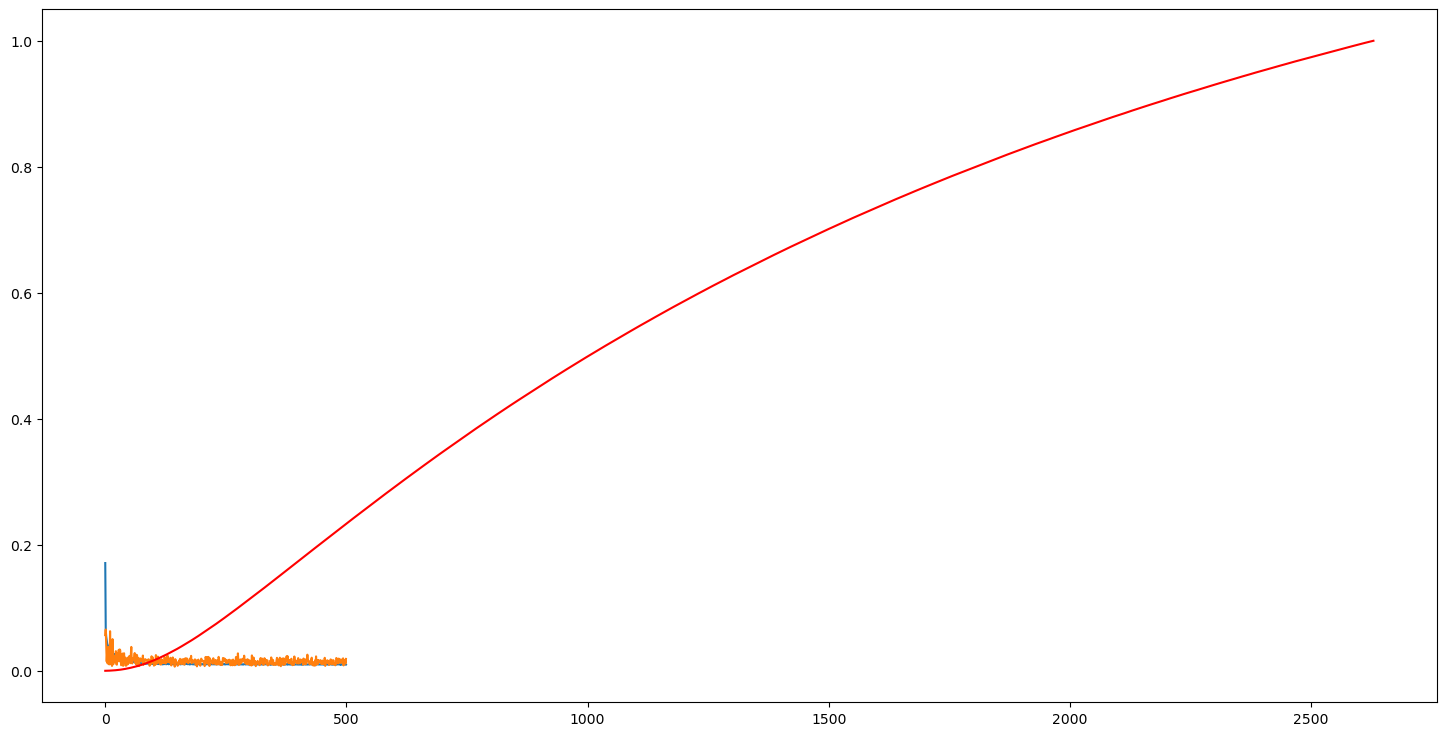

In [54]:
# Задаем количество временных шагов
time_steps = 120
out_steps_list = [6, 18, 36, 72, 144]

metrics_by_out_steps = {}

for out_steps in out_steps_list:
    # Файлы для обучающей выборки
    trainFiles = ['./Temperature/temp6_otkaz.csv', './Temperature/temp11_otkaz.csv']#,

    # trainFiles = ['./Temperature/temp1_norm.csv', './Temperature/temp3_norm.csv']

    # Тестовый файл
    testFile = './Temperature/temp13_otkaz.csv'

    # Подготовка обучающих и тестовых данных
    train_X, train_y, test_X, test_y, normalRawData = getAllData(trainFiles, testFile, time_steps, out_steps)



    # Преобразование данных в формат, подходящий для ввода в LSTM
    X_train = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    X_test = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

    print(X_train.shape)
    print(X_test.shape)

    model = Sequential()
    model.add(LSTM(100, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(out_steps))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mean_squared_error', 'mean_absolute_error'])

    history = model.fit(X_train, train_y, epochs=500, batch_size=32, verbose=1, validation_data=(X_test, test_y))

    model.save(f"./models/osf_riseDropModelWithWeightNoramal_800ep_{time_steps}ts_{out_steps}os")
    
    plt.clf()
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.savefig(f'./screens/osf_acc_{time_steps}ts_{out_steps}os.png')
    
    plt.clf()
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.savefig(f'./screens/osf_mse_{time_steps}ts_{out_steps}os.png')
    
    plt.clf()
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.savefig(f'./screens/osf_mae_{time_steps}ts_{out_steps}os.png')
    
    # Подготовка обучающих и тестовых данных
    testFile = './Temperature/temp11_otkaz.csv'
    _, _, test_X_180, test_y_180, normalRawData = getAllData([], testFile, time_steps, 180)

    test_X_180 = test_X_180[::10]
    test_y_180 = test_y_180[::10]
    
    X_test_180 = np.reshape(test_X_180, (test_X_180.shape[0], test_X_180.shape[1], 1))
    
    predictions = None
    counter = 0
    for el in X_test_180:    
        print(f"\r{counter} / {len(X_test_180)}\t\t\t\t\t\t", end='')
        counter += 1
        prediction = predictNvalue(el, 180).reshape(1, 180, 1)
        if (predictions is None):
            predictions = prediction
        else:
            predictions = np.concatenate((predictions, prediction), axis=0)
    
    predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])
    metrics_by_out_steps[time_steps] = {'mean_absolute_error': mean_absolute_error(test_y_180, predictions),
                                        'mean_squared_error': mean_squared_error(test_y_180, predictions), 
                                        'mean_absolute_percentage_error': mean_absolute_percentage_error(test_y_180, predictions),
                                        median_absolute_error : median_absolute_error(test_y_180, predictions)}
    
    print(mean_absolute_error(test_y_180, predictions))
    print(mean_squared_error(test_y_180, predictions))
    print(mean_absolute_percentage_error(test_y_180, predictions))
    print(median_absolute_error(test_y_180, predictions))

print(metrics_by_out_steps)